In [1]:
import numpy as np
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt_extent = 'OICCK'

In [3]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
50 5.0 10.0 
50 5.0 10.0 
25 5.0 10.0

In [5]:
varmodelpar = '''                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
varmodel.out                 -file for modeled variogram points output
2                            -number of directions to model points along
  45   0.0  1000   0.5      -  azm, dip, npoints, point separation
 135   0.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)
0   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
varcalc.out                  -    experimental output file 1
2   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
varmodelfit.var              -  file to save fit variogram model
'''
varmodel= gs.Program(program='varmodel',parfile='varmodel.par')
varmodel.run(parstr=varmodelpar.format())
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

Calling:  ['varmodel', 'varmodel.par']

varmodel version: 1.1.1

  output points file: varmodel.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  nst =           1
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            0      100000
  number of variogram files:            1
  variogram file: varcalc.out
  using variograms            1           4
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: varmodelfit.var
  Modeling points

varmodel completed successfully

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \


In [6]:
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \
0              1.0           0.5              1.0         0.010012   
1              1.0           1.0              1.0         0.010047   
2              1.0           1.5              1.0         0.010107   
3              1.0           2.0              1.0         0.010190   
4              1.0           2.5              1.0         0.010297   

   Variogram Number  Calculation Azimuth  Calculation Dip  
0               1.0                 45.0              0.0  
1               1.0                 45.0              0.0  
2               1.0                 45.0              0.0  
3               1.0                 45.0              0.0  
4               1.0                 45.0              0.0  


In [7]:
varg = ("1    0.01                   -nst, nugget effect\n\
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)")

print(varg)

1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)


In [8]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat           -file with data
1  2  3  4  0  0              -  columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -  trimming limits
0                             -transform the data (0=no, 1=yes)
sgsim.trn                     -  file for output trans table
0                             -  consider ref. dist (0=no, 1=yes)
histsmth.out                  -  file with ref. dist distribution
1  2                          -  columns for vr and wt
0.0    15.0                   -  zmin,zmax(tail extrapolation)
1       0.0                   -  lower tail option, parameter
1      15.0                   -  upper tail option, parameter
1                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output
sgsim.out                     -file for simulation output
1                             -number of realizations to generate
{grid}
69069                         -random number seed
0     8                       -min and max original data for sim
48                            -number of simulated nodes to use
1                             -assign data to nodes (0=no, 1=yes)
1     3                       -multiple grid search (0=no, 1=yes),num
0                             -maximum data per octant (0=not used)
250  250.0  150.0              -maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -angles for search ellipsoid
51    51    11                -size of covariance lookup table
0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -  file with LVM, EXDR, or COLC variable
4                             -  column for secondary variable
{varg}

'''
sgsim= gs.Program(program='sgsim',parfile='sgsim.par')
sgsim.run(parstr=sgsimpar.format(varg = varg,
                                 grid = griddef
                                ))
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.head())

Calling:  ['sgsim', 'sgsim.par']

 SGSIM Version: 4.000

  data file = cluster.dat                             
  input columns =            1           2           3           4           0
           0
  trimming limits =   -1.000000      1.0000000E+21
  transformation flag =            0
  transformation file = sgsim.trn                               
  consider smoothed distribution (1=yes) =            0
  file with smoothed distribution = histsmth.out                            
  columns =            1           2
  data limits (tails) =   0.0000000E+00   15.00000    
  lower tail =            1  0.0000000E+00
  upper tail =            1   15.00000    
  debugging level =            1
  debugging file = sgsim.dbg                               
  output file sgsim.out                               
  number of realizations =            1
  X grid specification =           50   5.000000       10.00000    
  Y grid specification =           50   5.000000       10.00000    
  Z grid

In [9]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                         -file with data
addcoord.out                      -file for output
1                                 -realization number
{grid}
3 3 6                            -decimals for x, y, z (-1=exclude)
'''
addcoord= gs.Program(program='addcoord',parfile='addcoord.par')
addcoord.run(parstr=addcoordpar.format(datafl=sgsimfl.flname
                                ,grid = griddef
                                ))
addcoordfl = gs.DataFile(flname='addcoord.out', griddef = griddef,
                       readfl=True)
print(addcoordfl.data.head())

Calling:  ['addcoord', 'addcoord.par']

 ADDCOORD VERSION: 4.1.0

 Data File = sgsim.out                               
 Output File = addcoord.out                            
 Realization number =            1
 X grid size =           50   5.00000000000000        10.0000000000000     
 Y grid size =           50   5.00000000000000        10.0000000000000     
 Z grid size =           25   5.00000000000000        10.0000000000000     
 decimals =            3           3           6
 
 Format: (f07.03,x,f07.03,x,f10.06,x,a)      

 ADDCOORD: 4.1.0 Finished

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [7]:
datafl = gs.DataFile(flname = 'addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)
print(datafl.data.head())

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [ ]:
gs.write_gslib(datafl,'addcoord.out')

In [ ]:
datafl['value'] = 0.0

In [ ]:
dataflpd = pd.DataFrame(datafl.data, dtype = np.float32)

In [ ]:
gs.write_gslib(dataflpd,'dataflpd.out')
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
print(sgsimfl.data.head())

In [ ]:
def points_in_circle_np(radius, x0, y0):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1,10, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1,10, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y

In [17]:
for j in range(245,95,-5):
    print(j)
    q = []
    a = pd.DataFrame(list(points_in_circle_np(j,250,250)))-4
    for i in range(5,250,5):
        a['z'] = i
        q.append(a)
        if i != 245:
            a = a.drop(columns='z')
    circle = np.vstack(q)
    circlepd = pd.DataFrame(circle, columns=['X','Y','Z'])
    idx,ingrid = griddef.coord_to_index1d(x=circlepd['X'],y=circlepd['Y'],z=circlepd['Z'])
    test = pd.DataFrame(np.vstack((sgsimfl.data['X'][idx],sgsimfl.data['Y'][idx],sgsimfl.data['Z'][idx],sgsimfl.data['value'][idx])).T,columns=['X','Y','Z','value'])
    print(len(idx))
    for k in idx:
        sgsimfl.data['value'][k] = np.power(math.e,(-2.25*np.power((1.70-(j/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1)) + np.power(math.e,(-2.25*np.power((1.25-(sgsimfl.data['Z'][k]/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1))
        if j == 100:
            sgsimfl.data['value'][k] = 0       

245
92120
240
88494
235
84868
230
81585
225
77616
220
74333
215
71148
210
67669
205
64533
200
61593
195
58408
190
55321
185
52528
180
49735
175
46942
170
44198
165
41944
160
39249
155
36848
150
34545
145
32340
140
29939
135
27979
130
25921
125
24010
120
21903
115
20384
110
18571
105
16807
100
15386


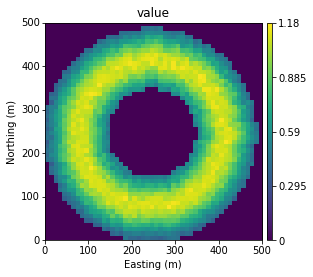

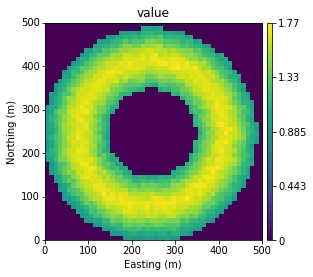

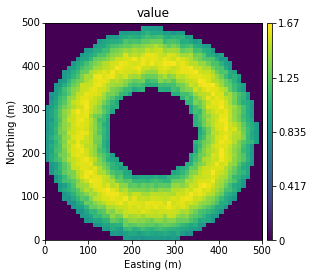

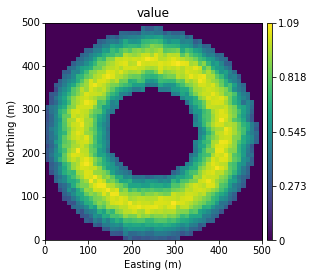

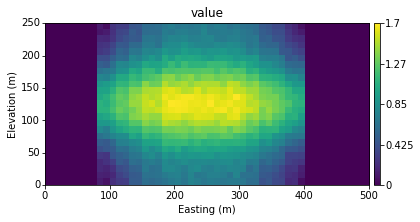

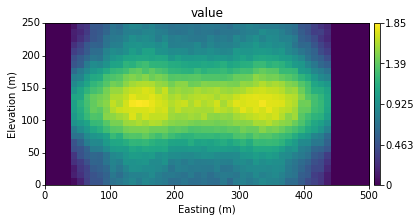

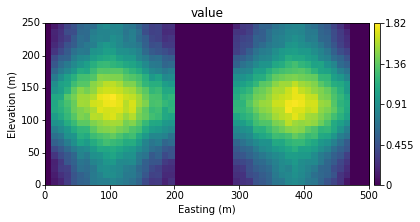

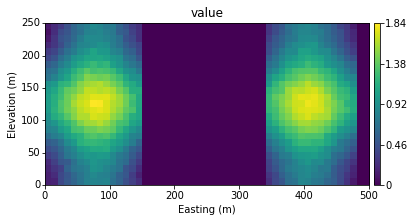

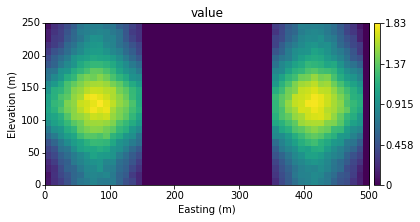

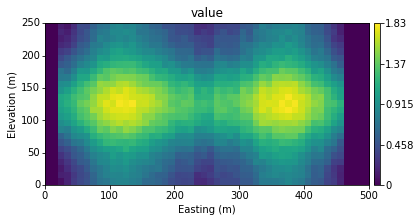

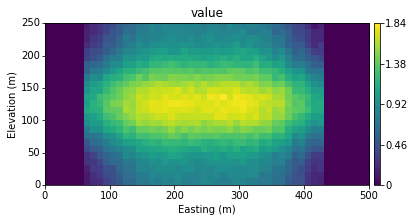

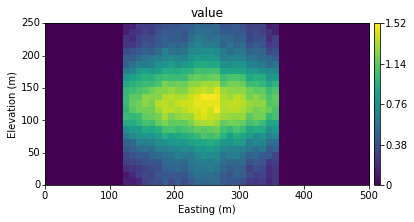

In [19]:
gs.pixelplt(sgsimfl,var='value',sliceno= 5)
gs.pixelplt(sgsimfl,var='value',sliceno= 10)
gs.pixelplt(sgsimfl,var='value',sliceno= 15)
gs.pixelplt(sgsimfl,var='value',sliceno= 20)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 5)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 10)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 15)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 20)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 25)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 35)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 40)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 45)

In [20]:
# gs.write_gslib(sgsimfl,'dataflpd.out')
# sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
# print(sgsimfl.data.describe())

                  X             Y             Z         value   values
count  62500.000000  62500.000000  62500.000000  62500.000000  62500.0
mean     250.000000    250.000000    125.000000      0.603846      0.0
std      144.309851    144.309851     72.111602      0.566735      0.0
min        5.000000      5.000000      5.000000      0.000000      0.0
25%      125.000000    125.000000     65.000000      0.000000      0.0
50%      250.000000    250.000000    125.000000      0.592674      0.0
75%      375.000000    375.000000    185.000000      1.060385      0.0
max      495.000000    495.000000    245.000000      1.849899      0.0


In [4]:
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
print(sgsimfl.data.describe())

                  X             Y             Z         value   values
count  62500.000000  62500.000000  62500.000000  62500.000000  62500.0
mean     250.000000    250.000000    125.000000      0.603846      0.0
std      144.309851    144.309851     72.111602      0.566735      0.0
min        5.000000      5.000000      5.000000      0.000000      0.0
25%      125.000000    125.000000     65.000000      0.000000      0.0
50%      250.000000    250.000000    125.000000      0.592674      0.0
75%      375.000000    375.000000    185.000000      1.060385      0.0
max      495.000000    495.000000    245.000000      1.849899      0.0


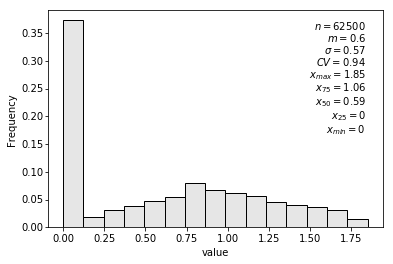

In [5]:
gs.histplt(sgsimfl.data['value'])

In [12]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}            - File with first grid
1  {varcol1}                        - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
80  80                       -  If 0, spacing in X, Y
45  45                     -  If 0, collar of the first sample, X and Y (inside sampling grid)
80  69069                    -  If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                            - Sample spacing downhole
1                          - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
5   495                       - Sampling grid: xmin, xmax
5   495                       -                ymin, ymax
5   245                       -                zmin, zmax
dhs.out        - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            -  If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out         - Keyout file
'''
gsample= gs.Program(program='gsample',parfile='gsample.par')
gsample.run(parstr=gsamplepar.format(datafl=sgsimfl.flname,
                                       varcol1=sgsimfl.gscol('value'),
                                         griddef=griddef
                                      ))

Calling:  ['gsample', 'gsample.par']

GSAMPLE Version: 1.000

PARAMETER FILE                  = gsample.par                                                                                                                                                                                                                                                     
-----------------------------------------------------------------------------

INPUT PARAMETERS 

Number of grids to sample       =   1
Total number of variables       =   1
 
Data file  1                    = 
dataflpd.out
Variable columns                =   4
 
Sample realization number       =   1
 
Input grid 
Input grid in X                 =   50        5.00   10.00
Input grid in Y                 =   50        5.00   10.00
Input grid in Z                 =   25        5.00   10.00
 
Sample option                   =   0
 
Consider regular spacing 

 
Spacing in X                    =    80.0    
Spacing in Y                    =    

In [13]:
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
print(dataflpoints.data.head())
dataflpoints.describe()

   Drill ID     X     Y      Z    MD  Block ID  value
0       1.0  45.0  45.0  245.0   0.0   60205.0    0.0
1       1.0  45.0  45.0  235.0  10.0   57705.0    0.0
2       1.0  45.0  45.0  225.0  20.0   55205.0    0.0
3       1.0  45.0  45.0  215.0  30.0   52705.0    0.0
4       1.0  45.0  45.0  205.0  40.0   50205.0    0.0


Drill ID          MD      Block ID       value
count  864.000000  864.000000    864.000000  864.000000
mean    18.500000  115.000000  32475.000000    0.718265
std     10.394312   69.261959  17328.980986    0.517947
min      1.000000    0.000000   2705.000000    0.000000
25%      9.750000   57.500000  17590.000000    0.242775
50%     18.500000  115.000000  32475.000000    0.722150
75%     27.250000  172.500000  47360.000000    1.126425
max     36.000000  230.000000  62245.000000    1.818200

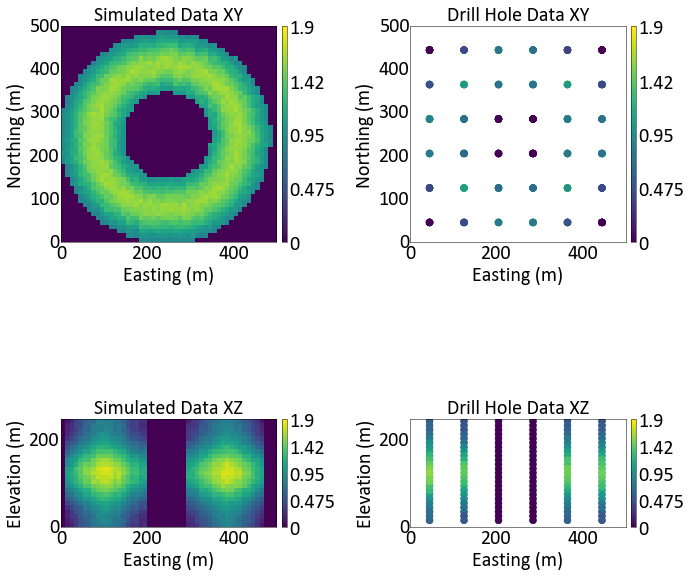

In [14]:
dataflpoints = dataflpoints[dataflpoints.data['Z'] != 0.1]
vlim = (0,1.9)
gs.set_style('pt20')
f, axes = plt.subplots(2, 2, figsize=(10, 10))
gs.locmap(dataflpoints,var = 'value',orient='xy', ax = axes[0,1],sliceno= 15,title = ('Drill Hole Data XY'),vlim=vlim)
gs.locmap(dataflpoints,var = 'value',orient='xz', ax = axes[1,1],sliceno= 15,title = ('Drill Hole Data XZ'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',sliceno= 15, ax = axes[0,0],title = ('Simulated Data XY'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 15, ax = axes[1,0],title = ('Simulated Data XZ'),vlim=vlim)
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Donut_Data.png',vlim=vlim)


In [15]:
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [16]:
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()

X           Y           Z       value
count  864.000000  864.000000  864.000000  864.000000
mean   245.000000  245.000000  130.000000    0.718266
std    136.705139  136.705139   69.261963    0.517947
min     45.000000   45.000000   15.000000    0.000000
25%    125.000000  125.000000   72.500000    0.242775
50%    245.000000  245.000000  130.000000    0.722150
75%    365.000000  365.000000  187.500000    1.126425
max    445.000000  445.000000  245.000000    1.818200

In [17]:
gs.write_gslib(datasamplefl, 'datasamplefl.out')

In [18]:
datatest = np.asarray(datasamplefl)

In [6]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
    tf.InteractiveSession.close(sess)
    sess.close()

In [20]:
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

0.0
1.8182
1
Working on Node 10 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp5twpoitp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026518738860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling 

Epoch: 1100/5000 err = 0.022446896880865097
Cost_test : 0.02655023
R^2:0.7055755257606506
Epoch: 1200/5000 err = 0.02316492237150669
Cost_test : 0.025171356
R^2:0.7114505767822266
Epoch: 1300/5000 err = 0.020020676776766777
Cost_test : 0.023461085
R^2:0.763670027256012
Epoch: 1400/5000 err = 0.017644332721829414
Cost_test : 0.021642458
R^2:0.7869869470596313
Epoch: 1500/5000 err = 0.016397863626480103
Cost_test : 0.019767659
R^2:0.7977665662765503
Epoch: 1600/5000 err = 0.014679299667477608
Cost_test : 0.017941032
R^2:0.8093946576118469
Epoch: 1700/5000 err = 0.013472003862261772
Cost_test : 0.016262835
R^2:0.8278915882110596
Epoch: 1800/5000 err = 0.011458182707428932
Cost_test : 0.01464255
R^2:0.8612273335456848
Epoch: 1900/5000 err = 0.01130891963839531
Cost_test : 0.01310079
R^2:0.8682941198348999
Epoch: 2000/5000 err = 0.009165351279079914
Cost_test : 0.011947304
R^2:0.8856704235076904
Epoch: 2100/5000 err = 0.008473166264593601
Cost_test : 0.0107126115
R^2:0.8890679478645325
Epoc

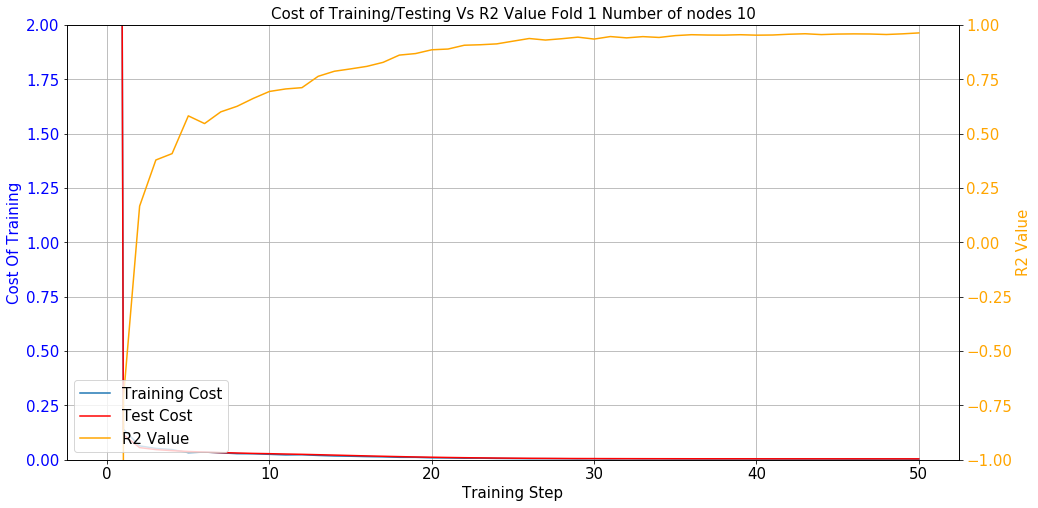

Working on Node 15 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpyvhvuzgp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000265149C57B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.020443838089704514
Cost_test : 0.02415866
R^2:0.745248556137085
Epoch: 1200/5000 err = 0.021267570555210114
Cost_test : 0.021673143
R^2:0.7448498010635376
Epoch: 1300/5000 err = 0.018435532227158546
Cost_test : 0.019307027
R^2:0.7764805555343628
Epoch: 1400/5000 err = 0.016245989128947258
Cost_test : 0.016714077
R^2:0.7962219715118408
Epoch: 1500/5000 err = 0.012353611178696156
Cost_test : 0.014506085
R^2:0.8371492624282837
Epoch: 1600/5000 err = 0.011323247104883194
Cost_test : 0.012583368
R^2:0.8521931171417236
Epoch: 1700/5000 err = 0.010533329099416733
Cost_test : 0.011149164
R^2:0.8653084635734558
Epoch: 1800/5000 err = 0.009141775779426098
Cost_test : 0.0097691445
R^2:0.8897258043289185
Epoch: 1900/5000 err = 0.007858232595026493
Cost_test : 0.008767182
R^2:0.9007965922355652
Epoch: 2000/5000 err = 0.007550959940999746
Cost_test : 0.0080355145
R^2:0.9039725065231323
Epoch: 2100/5000 err = 0.00641033286228776
Cost_test : 0.0074779014
R^2:0.9200133681297302

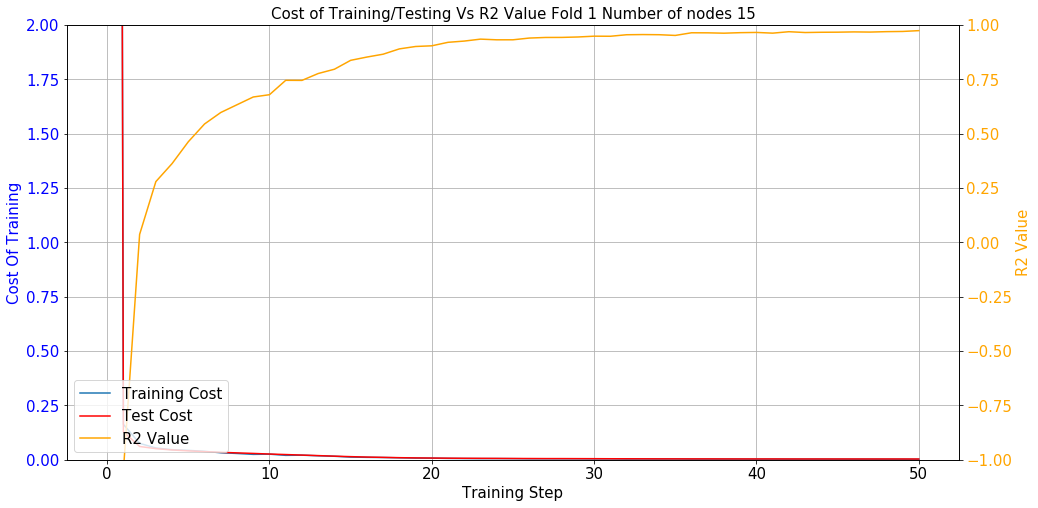

Working on Node 20 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpttjx59qd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000265134BAE10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.028709137812256813
Cost_test : 0.0323718
R^2:0.6102620363235474
Epoch: 1200/5000 err = 0.028546983376145363
Cost_test : 0.030034704
R^2:0.6406826972961426
Epoch: 1300/5000 err = 0.025971196591854095
Cost_test : 0.027839849
R^2:0.6698329448699951
Epoch: 1400/5000 err = 0.02397334575653076
Cost_test : 0.025671402
R^2:0.7033171653747559
Epoch: 1500/5000 err = 0.02300323359668255
Cost_test : 0.023971967
R^2:0.7138893604278564
Epoch: 1600/5000 err = 0.022491300478577614
Cost_test : 0.022076609
R^2:0.7269333004951477
Epoch: 1700/5000 err = 0.02049352042376995
Cost_test : 0.0204574
R^2:0.7464480996131897
Epoch: 1800/5000 err = 0.01760345697402954
Cost_test : 0.018921366
R^2:0.7761251926422119
Epoch: 1900/5000 err = 0.015452447347342968
Cost_test : 0.017116321
R^2:0.8061865568161011
Epoch: 2000/5000 err = 0.013960440643131733
Cost_test : 0.015701441
R^2:0.8248087167739868
Epoch: 2100/5000 err = 0.013590090908110142
Cost_test : 0.014590714
R^2:0.8383255004882812
Epoch: 

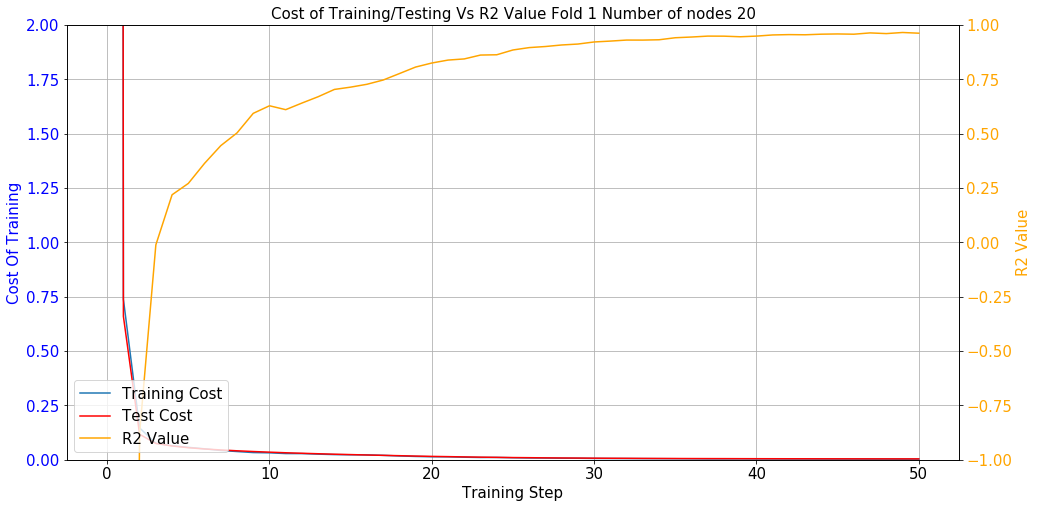

Working on Node 25 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp715nymzs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002650FFD3B70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.011867674067616463
Cost_test : 0.011767103
R^2:0.8360570669174194
Epoch: 1200/5000 err = 0.011324815452098846
Cost_test : 0.010159648
R^2:0.8589437007904053
Epoch: 1300/5000 err = 0.010720694437623024
Cost_test : 0.008984997
R^2:0.8659151792526245
Epoch: 1400/5000 err = 0.009368282742798328
Cost_test : 0.008110018
R^2:0.8808888792991638
Epoch: 1500/5000 err = 0.0087522491812706
Cost_test : 0.0074235806
R^2:0.8925785422325134
Epoch: 1600/5000 err = 0.007936062291264534
Cost_test : 0.0067947763
R^2:0.9015601277351379
Epoch: 1700/5000 err = 0.006939065642654896
Cost_test : 0.006442965
R^2:0.9160234928131104
Epoch: 1800/5000 err = 0.006675940938293934
Cost_test : 0.0061397743
R^2:0.9155910611152649
Epoch: 1900/5000 err = 0.0056393323466181755
Cost_test : 0.0059243985
R^2:0.9303849339485168
Epoch: 2000/5000 err = 0.005759412422776222
Cost_test : 0.005687441
R^2:0.9270235896110535
Epoch: 2100/5000 err = 0.005069715902209282
Cost_test : 0.0056254095
R^2:0.935917377471

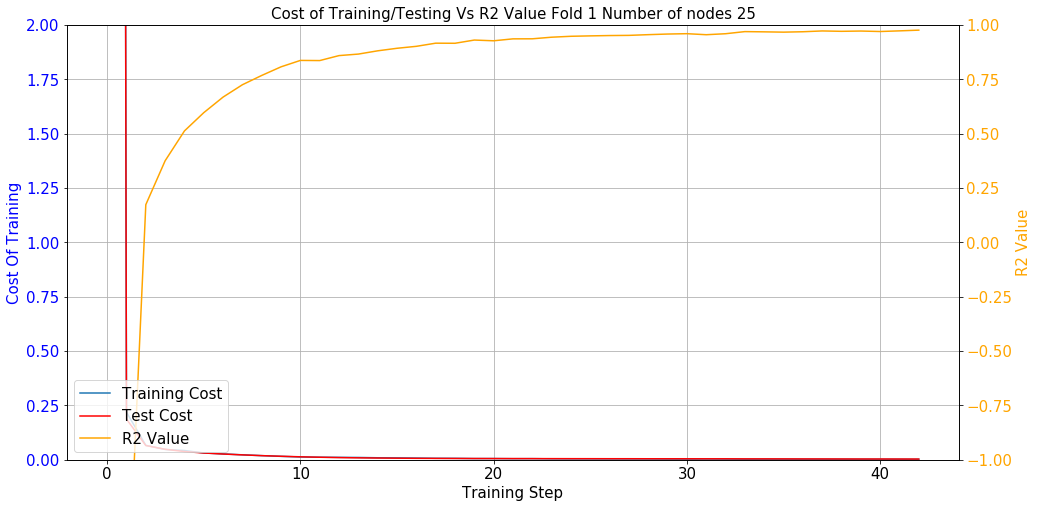

2
Working on Node 10 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpihmxzr6k', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000265118D5B70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.023176107555627823
Cost_test : 0.021725675
R^2:0.7133367657661438
Epoch: 1200/5000 err = 0.019750531762838364
Cost_test : 0.019903928
R^2:0.7601515054702759
Epoch: 1300/5000 err = 0.018494607880711555
Cost_test : 0.018085975
R^2:0.7677307724952698
Epoch: 1400/5000 err = 0.017196470871567726
Cost_test : 0.016322281
R^2:0.7778460383415222
Epoch: 1500/5000 err = 0.014182314276695251
Cost_test : 0.014495117
R^2:0.8168598413467407
Epoch: 1600/5000 err = 0.01311268750578165
Cost_test : 0.013024562
R^2:0.8406436443328857
Epoch: 1700/5000 err = 0.012026623822748661
Cost_test : 0.011670241
R^2:0.8521114587783813
Epoch: 1800/5000 err = 0.011236281134188175
Cost_test : 0.010586284
R^2:0.8625962734222412
Epoch: 1900/5000 err = 0.010509401559829712
Cost_test : 0.009707291
R^2:0.8729806542396545
Epoch: 2000/5000 err = 0.009532814845442772
Cost_test : 0.008920925
R^2:0.8815824389457703
Epoch: 2100/5000 err = 0.008752209134399891
Cost_test : 0.008261344
R^2:0.9023560881614685


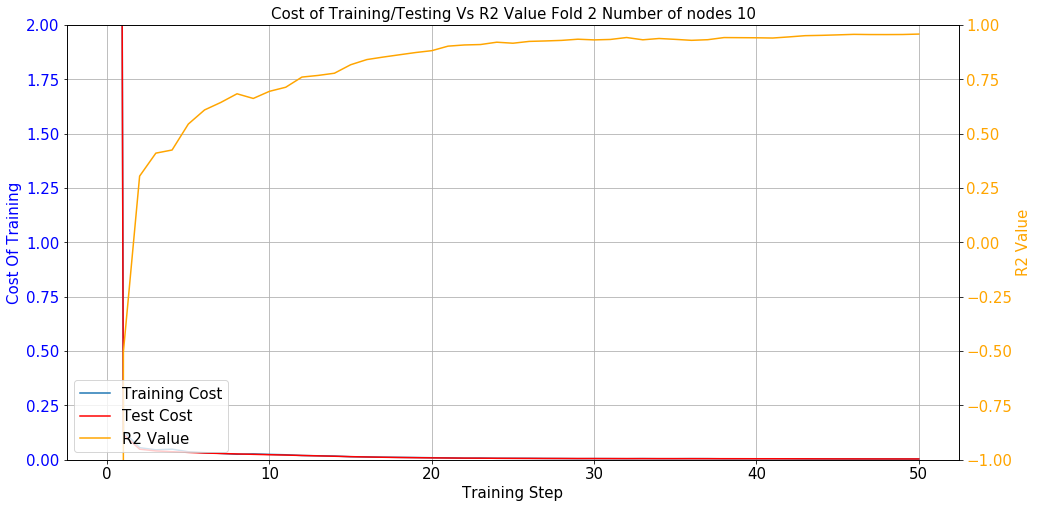

Working on Node 15 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpwc116c14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D12E1898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.018029648810625076
Cost_test : 0.017301075
R^2:0.7761890292167664
Epoch: 1200/5000 err = 0.017586033791303635
Cost_test : 0.015336014
R^2:0.8007716536521912
Epoch: 1300/5000 err = 0.014317759312689304
Cost_test : 0.013884837
R^2:0.8169972896575928
Epoch: 1400/5000 err = 0.01293844822794199
Cost_test : 0.012440892
R^2:0.8371318578720093
Epoch: 1500/5000 err = 0.012581528164446354
Cost_test : 0.01129434
R^2:0.842741847038269
Epoch: 1600/5000 err = 0.010657532140612602
Cost_test : 0.010395582
R^2:0.8786386847496033
Epoch: 1700/5000 err = 0.010015754960477352
Cost_test : 0.009550776
R^2:0.8822581768035889
Epoch: 1800/5000 err = 0.00879913941025734
Cost_test : 0.00897284
R^2:0.8823353052139282
Epoch: 1900/5000 err = 0.008681844919919968
Cost_test : 0.008504997
R^2:0.8948490619659424
Epoch: 2000/5000 err = 0.007714022416621447
Cost_test : 0.0080392165
R^2:0.9092391133308411
Epoch: 2100/5000 err = 0.006854538805782795
Cost_test : 0.007739313
R^2:0.9173043966293335
Epo

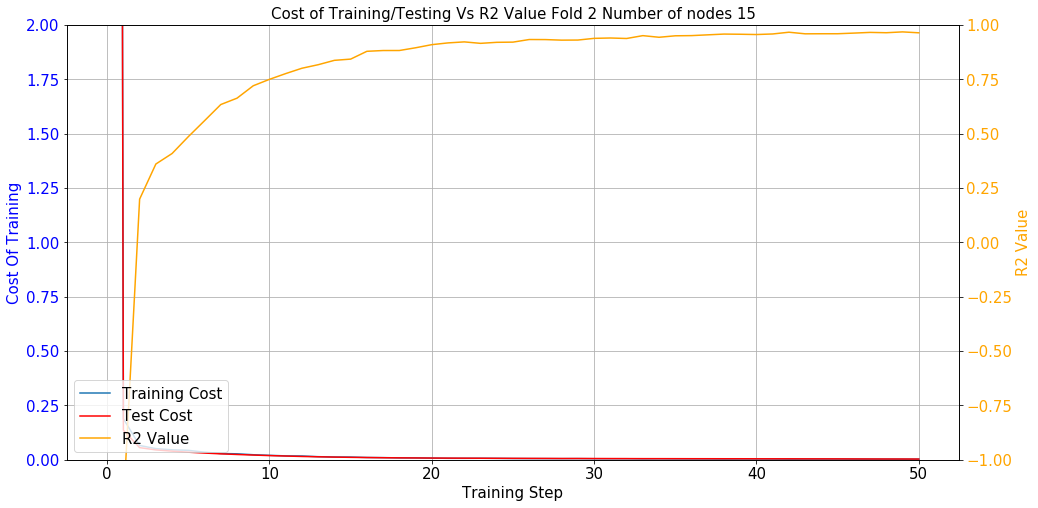

Working on Node 20 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpdftnoijk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026514BCB940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

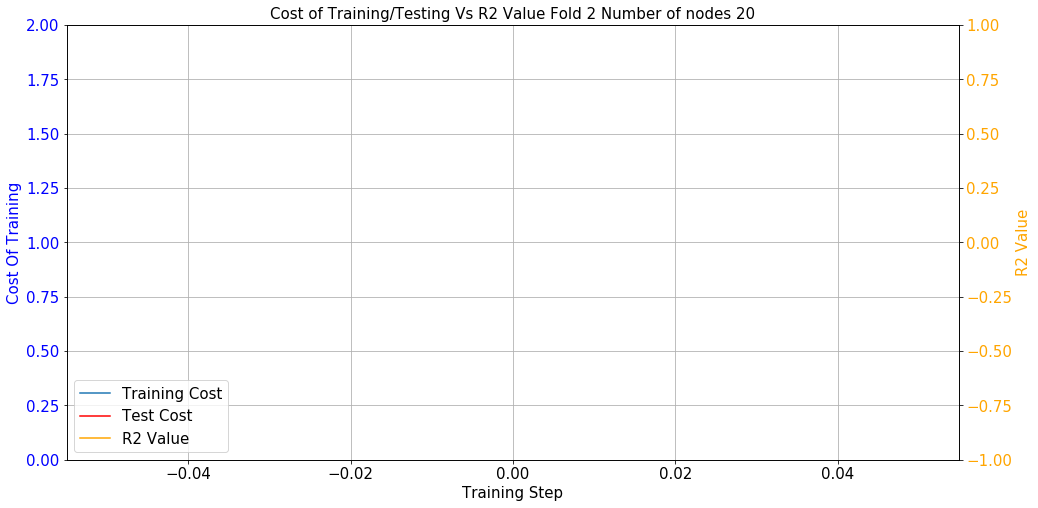

Working on Node 25 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpx5jcbolk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D0D1BDA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.017481045797467232
Cost_test : 0.01592617
R^2:0.7817203998565674
Epoch: 1200/5000 err = 0.01663055643439293
Cost_test : 0.014644595
R^2:0.7979599833488464
Epoch: 1300/5000 err = 0.01532738283276558
Cost_test : 0.013687442
R^2:0.8114268779754639
Epoch: 1400/5000 err = 0.01392875611782074
Cost_test : 0.0127215395
R^2:0.8267228603363037
Epoch: 1500/5000 err = 0.012336631305515766
Cost_test : 0.01185986
R^2:0.8489353656768799
Epoch: 1600/5000 err = 0.01155694667249918
Cost_test : 0.01112563
R^2:0.8589867353439331
Epoch: 1700/5000 err = 0.010896440595388412
Cost_test : 0.010337421
R^2:0.8703864216804504
Epoch: 1800/5000 err = 0.009707540273666382
Cost_test : 0.00971147
R^2:0.885368824005127
Epoch: 1900/5000 err = 0.00823234487324953
Cost_test : 0.009081441
R^2:0.8986461162567139
Epoch: 2000/5000 err = 0.008270501159131527
Cost_test : 0.008443978
R^2:0.899677574634552
Epoch: 2100/5000 err = 0.006964505650103092
Cost_test : 0.007911522
R^2:0.9195144176483154
Epoch: 22

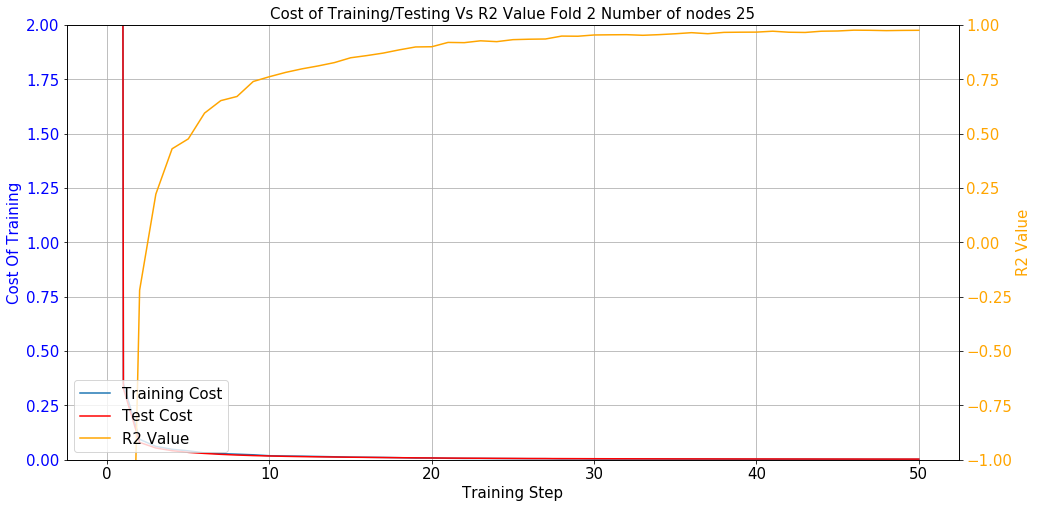

3
Working on Node 10 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp6ks03ml_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D19C3D68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.019204897806048393
Cost_test : 0.025998104
R^2:0.7622898817062378
Epoch: 1200/5000 err = 0.017950328066945076
Cost_test : 0.023491917
R^2:0.7710447311401367
Epoch: 1300/5000 err = 0.014391633681952953
Cost_test : 0.020923328
R^2:0.8211996555328369
Epoch: 1400/5000 err = 0.01431132573634386
Cost_test : 0.018419478
R^2:0.8263043165206909
Epoch: 1500/5000 err = 0.013163984753191471
Cost_test : 0.016214458
R^2:0.8347241878509521
Epoch: 1600/5000 err = 0.01184522733092308
Cost_test : 0.014269097
R^2:0.8408679366111755
Epoch: 1700/5000 err = 0.009672638028860092
Cost_test : 0.012470922
R^2:0.8881307244300842
Epoch: 1800/5000 err = 0.008620535023510456
Cost_test : 0.010964416
R^2:0.8937168121337891
Epoch: 1900/5000 err = 0.008655952289700508
Cost_test : 0.0098388335
R^2:0.8871548771858215
Epoch: 2000/5000 err = 0.007618804927915335
Cost_test : 0.008941069
R^2:0.9085224270820618
Epoch: 2100/5000 err = 0.007241412065923214
Cost_test : 0.008324346
R^2:0.9123534560203552


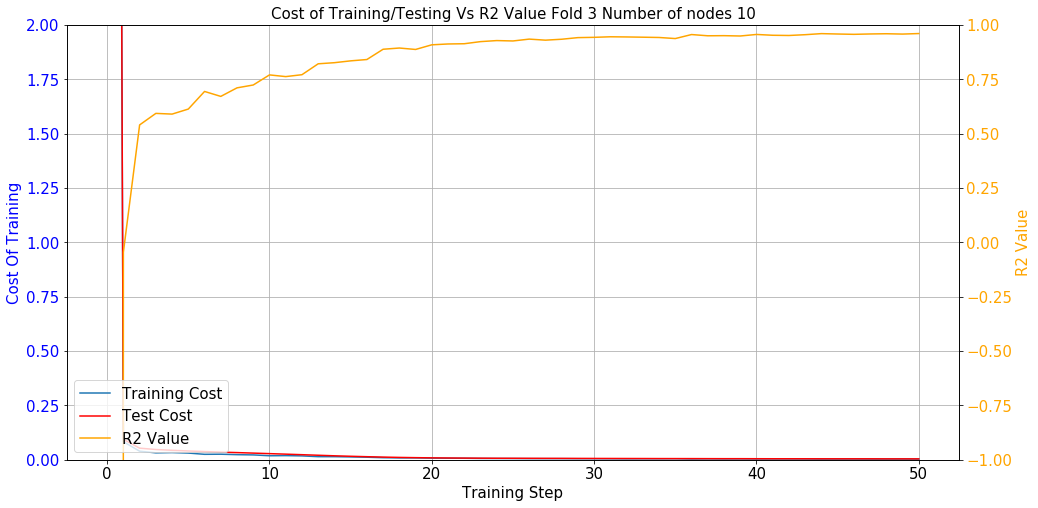

Working on Node 15 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp0e3bunkm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D1D6DCF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.023808887228369713
Cost_test : 0.026782868
R^2:0.7040785551071167
Epoch: 1200/5000 err = 0.021053241565823555
Cost_test : 0.02430683
R^2:0.7395328879356384
Epoch: 1300/5000 err = 0.02031617984175682
Cost_test : 0.022016712
R^2:0.762367844581604
Epoch: 1400/5000 err = 0.019273696467280388
Cost_test : 0.02000374
R^2:0.7548402547836304
Epoch: 1500/5000 err = 0.015179046429693699
Cost_test : 0.018049695
R^2:0.8189308643341064
Epoch: 1600/5000 err = 0.015368874184787273
Cost_test : 0.01615654
R^2:0.8005641102790833
Epoch: 1700/5000 err = 0.013107886537909508
Cost_test : 0.014572894
R^2:0.8462862372398376
Epoch: 1800/5000 err = 0.012413019314408302
Cost_test : 0.013099698
R^2:0.8570932149887085
Epoch: 1900/5000 err = 0.011204934678971767
Cost_test : 0.011669131
R^2:0.8608831763267517
Epoch: 2000/5000 err = 0.0089498870074749
Cost_test : 0.010443101
R^2:0.8864123225212097
Epoch: 2100/5000 err = 0.007677352987229824
Cost_test : 0.009410102
R^2:0.904634952545166
Epoch: 

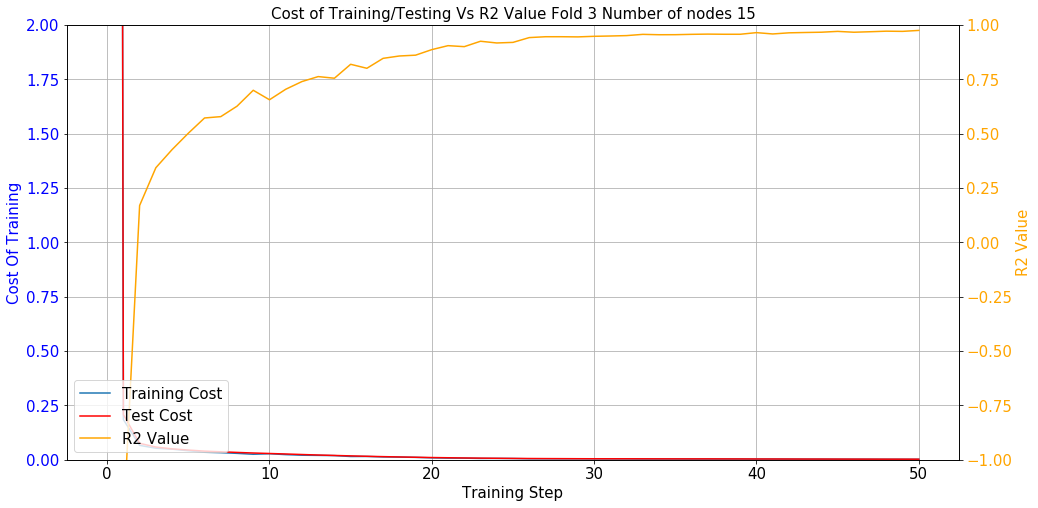

Working on Node 20 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpg7agmzqz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D19C3CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.029033329337835312
Cost_test : 0.039930955
R^2:0.641986608505249
Epoch: 1200/5000 err = 0.025848891586065292
Cost_test : 0.037105363
R^2:0.704500675201416
Epoch: 1300/5000 err = 0.024406949058175087
Cost_test : 0.03383419
R^2:0.6993989944458008
Epoch: 1400/5000 err = 0.023238616064190865
Cost_test : 0.031215845
R^2:0.706899881362915
Epoch: 1500/5000 err = 0.022157438099384308
Cost_test : 0.028715858
R^2:0.7300673723220825
Epoch: 1600/5000 err = 0.01978744938969612
Cost_test : 0.026465222
R^2:0.7496227025985718
Epoch: 1700/5000 err = 0.017677180469036102
Cost_test : 0.024407277
R^2:0.7794232368469238
Epoch: 1800/5000 err = 0.016694705933332443
Cost_test : 0.022662003
R^2:0.8042067885398865
Epoch: 1900/5000 err = 0.01565949246287346
Cost_test : 0.02043271
R^2:0.8071815371513367
Epoch: 2000/5000 err = 0.014001473784446716
Cost_test : 0.01901478
R^2:0.8256521224975586
Epoch: 2100/5000 err = 0.013600209727883339
Cost_test : 0.017254494
R^2:0.827857494354248
Epoch: 2

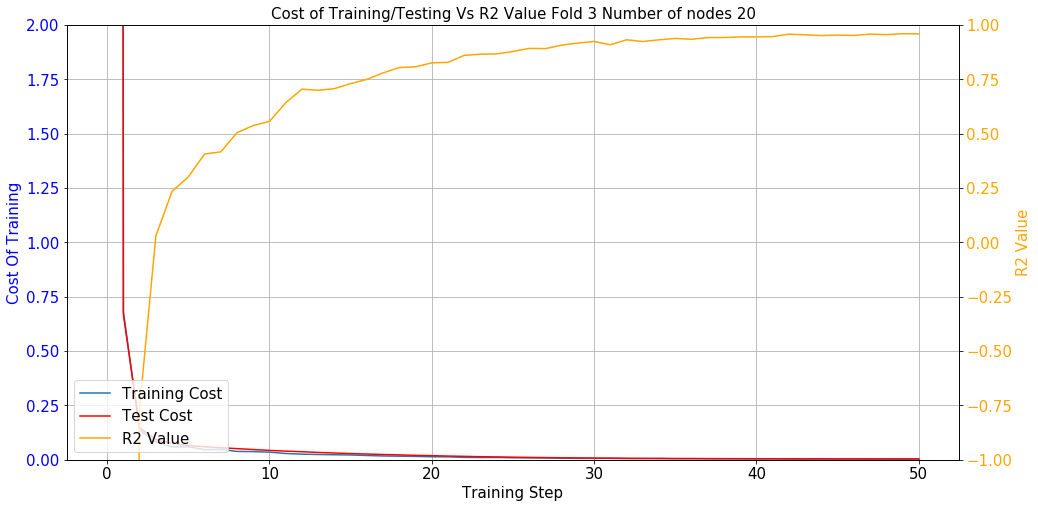

Working on Node 25 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpyec27ol5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D18B6358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.022420203313231468
Cost_test : 0.026816592
R^2:0.7263585329055786
Epoch: 1200/5000 err = 0.019344402477145195
Cost_test : 0.023902588
R^2:0.7660159468650818
Epoch: 1300/5000 err = 0.01799945719540119
Cost_test : 0.0212961
R^2:0.7817357778549194
Epoch: 1400/5000 err = 0.018569273874163628
Cost_test : 0.019091005
R^2:0.7681902050971985
Epoch: 1500/5000 err = 0.013666264712810516
Cost_test : 0.016973931
R^2:0.8305451273918152
Epoch: 1600/5000 err = 0.013370863161981106
Cost_test : 0.015224815
R^2:0.8463541269302368
Epoch: 1700/5000 err = 0.011870060116052628
Cost_test : 0.013696539
R^2:0.8513526916503906
Epoch: 1800/5000 err = 0.01045694388449192
Cost_test : 0.01220365
R^2:0.868309497833252
Epoch: 1900/5000 err = 0.009136008098721504
Cost_test : 0.01103303
R^2:0.8963168859481812
Epoch: 2000/5000 err = 0.008346480317413807
Cost_test : 0.009940274
R^2:0.896409809589386
Epoch: 2100/5000 err = 0.00796586461365223
Cost_test : 0.009089586
R^2:0.9062492251396179
Epoch: 2

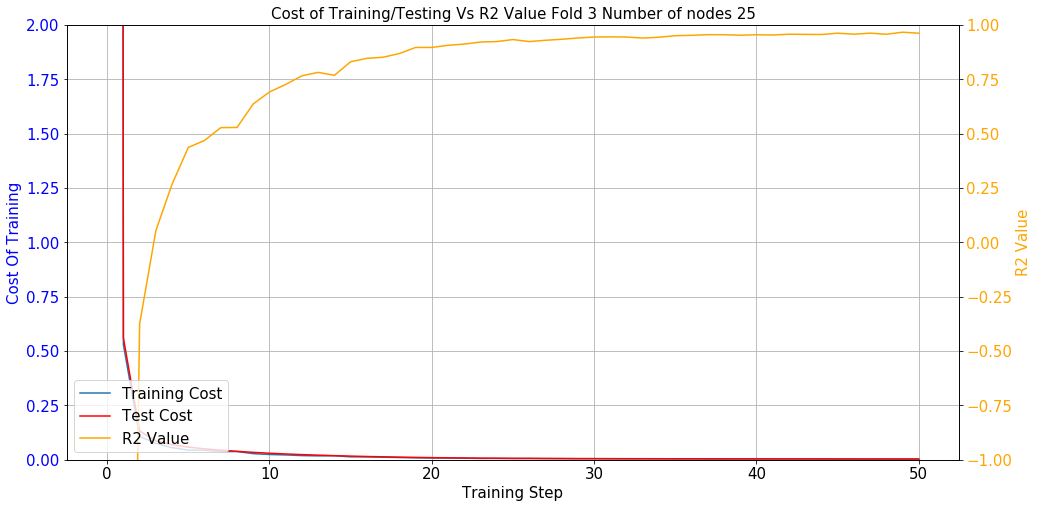

4
Working on Node 10 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp16gg5g3w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026517645E48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.016985801979899406
Cost_test : 0.023244416
R^2:0.7754945158958435
Epoch: 1200/5000 err = 0.015595857985317707
Cost_test : 0.021057377
R^2:0.8090481758117676
Epoch: 1300/5000 err = 0.014451130293309689
Cost_test : 0.01897228
R^2:0.8163116574287415
Epoch: 1400/5000 err = 0.013754100538790226
Cost_test : 0.016974859
R^2:0.841006338596344
Epoch: 1500/5000 err = 0.010482341051101685
Cost_test : 0.0151805915
R^2:0.8683382272720337
Epoch: 1600/5000 err = 0.009632664732635021
Cost_test : 0.0134091955
R^2:0.8860154151916504
Epoch: 1700/5000 err = 0.008407843299210072
Cost_test : 0.011927194
R^2:0.9012176990509033
Epoch: 1800/5000 err = 0.00651582982391119
Cost_test : 0.010830752
R^2:0.9195584654808044
Epoch: 1900/5000 err = 0.006861886940896511
Cost_test : 0.009736243
R^2:0.9165080785751343
Epoch: 2000/5000 err = 0.006821430288255215
Cost_test : 0.008955676
R^2:0.9193943738937378
Epoch: 2100/5000 err = 0.005684347823262215
Cost_test : 0.008225006
R^2:0.9249898195266724


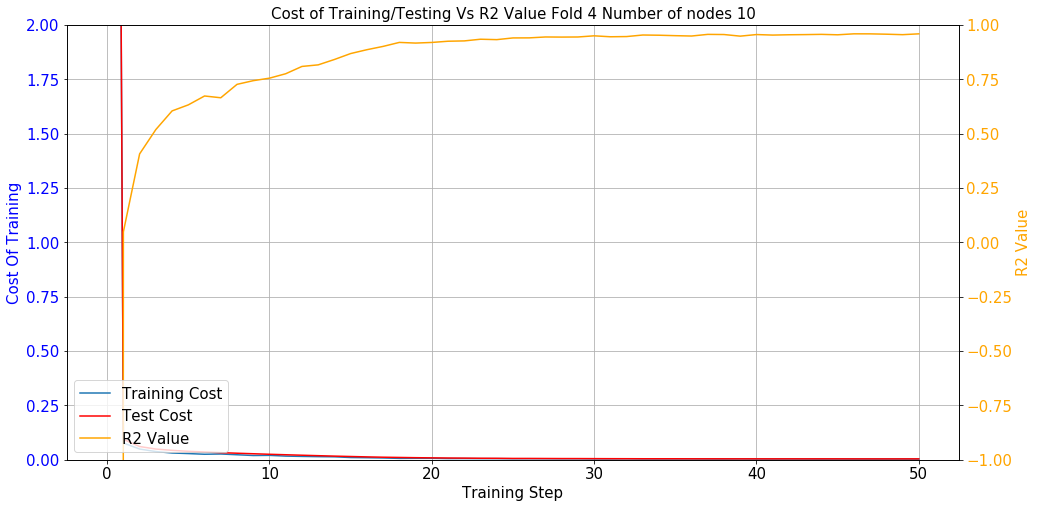

Working on Node 15 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp9vgul2xk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026502862EB8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.015187080018222332
Cost_test : 0.019864686
R^2:0.8203789591789246
Epoch: 1200/5000 err = 0.013734307140111923
Cost_test : 0.017509364
R^2:0.8393292427062988
Epoch: 1300/5000 err = 0.012764199636876583
Cost_test : 0.0155564705
R^2:0.8465084433555603
Epoch: 1400/5000 err = 0.01080042403191328
Cost_test : 0.014135486
R^2:0.8669904470443726
Epoch: 1500/5000 err = 0.008459012024104595
Cost_test : 0.0128276
R^2:0.885079026222229
Epoch: 1600/5000 err = 0.009372352622449398
Cost_test : 0.011726598
R^2:0.8749635815620422
Epoch: 1700/5000 err = 0.008527984842658043
Cost_test : 0.0108084865
R^2:0.8911897540092468
Epoch: 1800/5000 err = 0.0077512226998806
Cost_test : 0.010027389
R^2:0.8996714949607849
Epoch: 1900/5000 err = 0.006704327184706926
Cost_test : 0.009417299
R^2:0.9122360348701477
Epoch: 2000/5000 err = 0.006299028638750315
Cost_test : 0.008882542
R^2:0.9230086803436279
Epoch: 2100/5000 err = 0.006316242273896933
Cost_test : 0.00847587
R^2:0.9213302135467529
Epoc

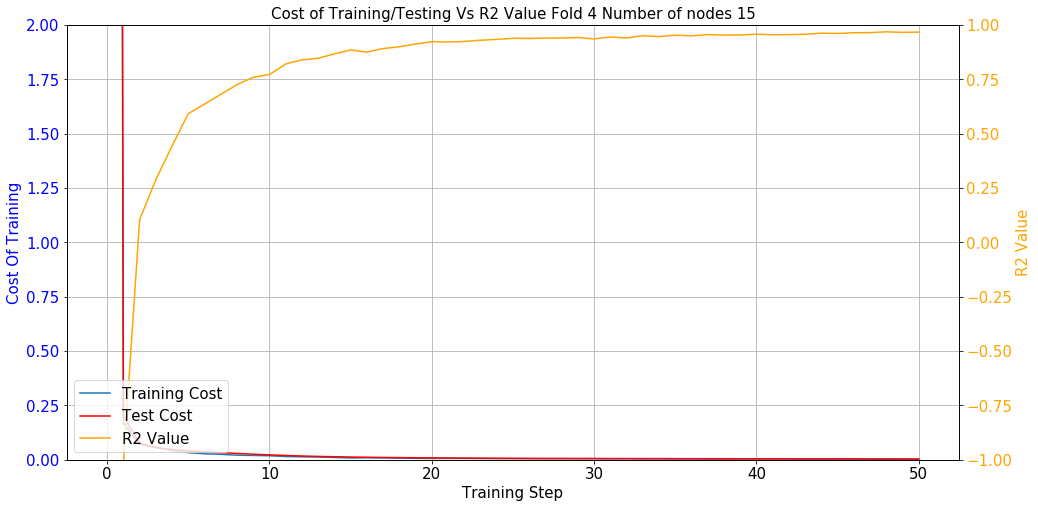

Working on Node 20 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpty5s5wsy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D67808D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.027834320440888405
Cost_test : 0.032413136
R^2:0.6568021178245544
Epoch: 1200/5000 err = 0.02332998812198639
Cost_test : 0.029817294
R^2:0.697975218296051
Epoch: 1300/5000 err = 0.021914707496762276
Cost_test : 0.027193746
R^2:0.7237584590911865
Epoch: 1400/5000 err = 0.02187250554561615
Cost_test : 0.024927737
R^2:0.7412225604057312
Epoch: 1500/5000 err = 0.01871701143682003
Cost_test : 0.022856656
R^2:0.7634421586990356
Epoch: 1600/5000 err = 0.017166726291179657
Cost_test : 0.020808518
R^2:0.789336085319519
Epoch: 1700/5000 err = 0.015164419077336788
Cost_test : 0.019032476
R^2:0.8143917918205261
Epoch: 1800/5000 err = 0.015545951202511787
Cost_test : 0.017351296
R^2:0.8128290176391602
Epoch: 1900/5000 err = 0.012727370485663414
Cost_test : 0.01583466
R^2:0.8473677635192871
Epoch: 2000/5000 err = 0.01135855633765459
Cost_test : 0.014581223
R^2:0.8498561382293701
Epoch: 2100/5000 err = 0.010336765088140965
Cost_test : 0.013321565
R^2:0.8664736747741699
Epoch:

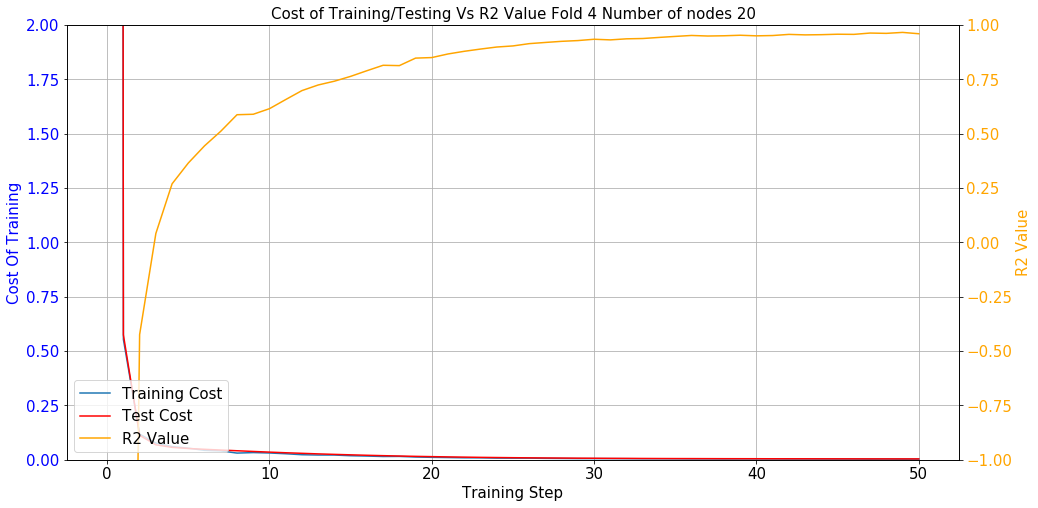

Working on Node 25 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp8922df8t', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D6780FD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.017501002177596092
Cost_test : 0.021426212
R^2:0.7757736444473267
Epoch: 1200/5000 err = 0.016841011121869087
Cost_test : 0.019769905
R^2:0.7840215563774109
Epoch: 1300/5000 err = 0.014364168979227543
Cost_test : 0.018136598
R^2:0.8198651075363159
Epoch: 1400/5000 err = 0.013733748346567154
Cost_test : 0.016998818
R^2:0.8270348906517029
Epoch: 1500/5000 err = 0.01169606763869524
Cost_test : 0.015646555
R^2:0.8521724343299866
Epoch: 1600/5000 err = 0.012192743830382824
Cost_test : 0.014633853
R^2:0.8514772653579712
Epoch: 1700/5000 err = 0.011243894696235657
Cost_test : 0.013602877
R^2:0.8647961616516113
Epoch: 1800/5000 err = 0.009390933439135551
Cost_test : 0.01261542
R^2:0.8768518567085266
Epoch: 1900/5000 err = 0.008535580709576607
Cost_test : 0.011950889
R^2:0.8831060528755188
Epoch: 2000/5000 err = 0.009296129457652569
Cost_test : 0.011052018
R^2:0.8798213005065918
Epoch: 2100/5000 err = 0.007559158839285374
Cost_test : 0.010319729
R^2:0.9028220176696777
E

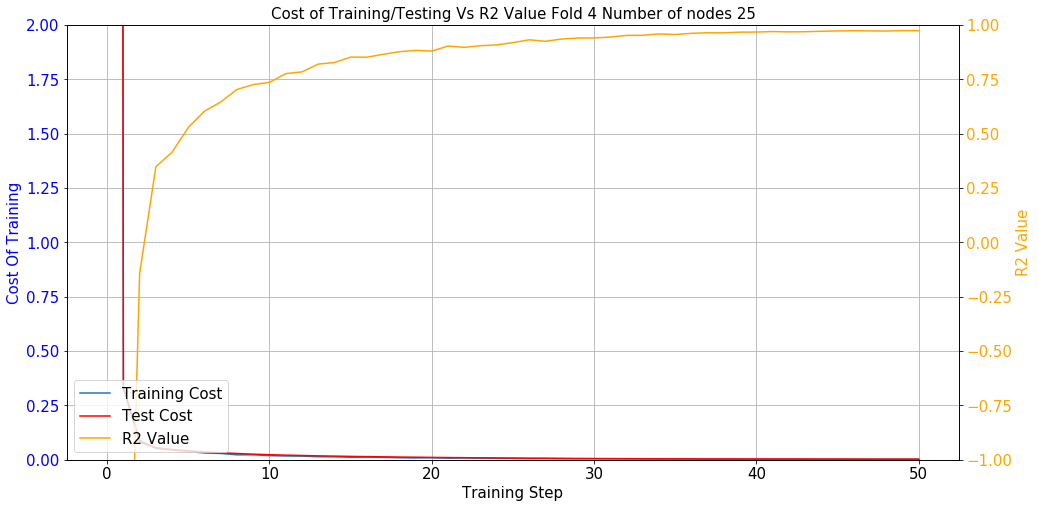

5
Working on Node 10 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpcqtfry3o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026502B415C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.025571633130311966
Cost_test : 0.025504868
R^2:0.6663790941238403
Epoch: 1200/5000 err = 0.02586357109248638
Cost_test : 0.024384657
R^2:0.6662228107452393
Epoch: 1300/5000 err = 0.027212142944335938
Cost_test : 0.022908963
R^2:0.6767920255661011
Epoch: 1400/5000 err = 0.02559516578912735
Cost_test : 0.02179165
R^2:0.685883104801178
Epoch: 1500/5000 err = 0.022971929982304573
Cost_test : 0.02048081
R^2:0.7209458351135254
Epoch: 1600/5000 err = 0.02165316790342331
Cost_test : 0.019039
R^2:0.7163101434707642
Epoch: 1700/5000 err = 0.020526988431811333
Cost_test : 0.017697122
R^2:0.7456769943237305
Epoch: 1800/5000 err = 0.0182294100522995
Cost_test : 0.016205164
R^2:0.7704253792762756
Epoch: 1900/5000 err = 0.016009872779250145
Cost_test : 0.014679325
R^2:0.7920088171958923
Epoch: 2000/5000 err = 0.014183728955686092
Cost_test : 0.013268233
R^2:0.834201991558075
Epoch: 2100/5000 err = 0.012653844431042671
Cost_test : 0.011933954
R^2:0.8428580164909363
Epoch: 2200

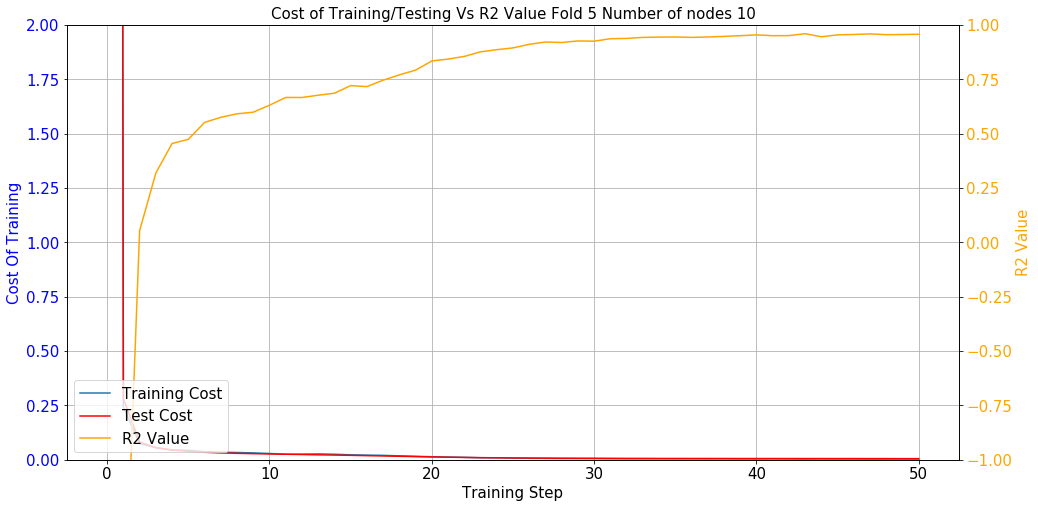

Working on Node 15 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpysut958z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002651180A2E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.022368237376213074
Cost_test : 0.022831924
R^2:0.7167048454284668
Epoch: 1200/5000 err = 0.02279190719127655
Cost_test : 0.021119066
R^2:0.7232770919799805
Epoch: 1300/5000 err = 0.02126248925924301
Cost_test : 0.019525807
R^2:0.7368415594100952
Epoch: 1400/5000 err = 0.01728617027401924
Cost_test : 0.017948614
R^2:0.7815877199172974
Epoch: 1500/5000 err = 0.01613580621778965
Cost_test : 0.016493544
R^2:0.800325870513916
Epoch: 1600/5000 err = 0.013403386808931828
Cost_test : 0.015065452
R^2:0.8168898820877075
Epoch: 1700/5000 err = 0.013430063612759113
Cost_test : 0.013751214
R^2:0.8404164910316467
Epoch: 1800/5000 err = 0.011484330520033836
Cost_test : 0.012535135
R^2:0.8527635335922241
Epoch: 1900/5000 err = 0.010236719623208046
Cost_test : 0.011431838
R^2:0.8694215416908264
Epoch: 2000/5000 err = 0.009469714015722275
Cost_test : 0.010533052
R^2:0.8748841881752014
Epoch: 2100/5000 err = 0.0077334195375442505
Cost_test : 0.009644923
R^2:0.902661144733429
Epoc

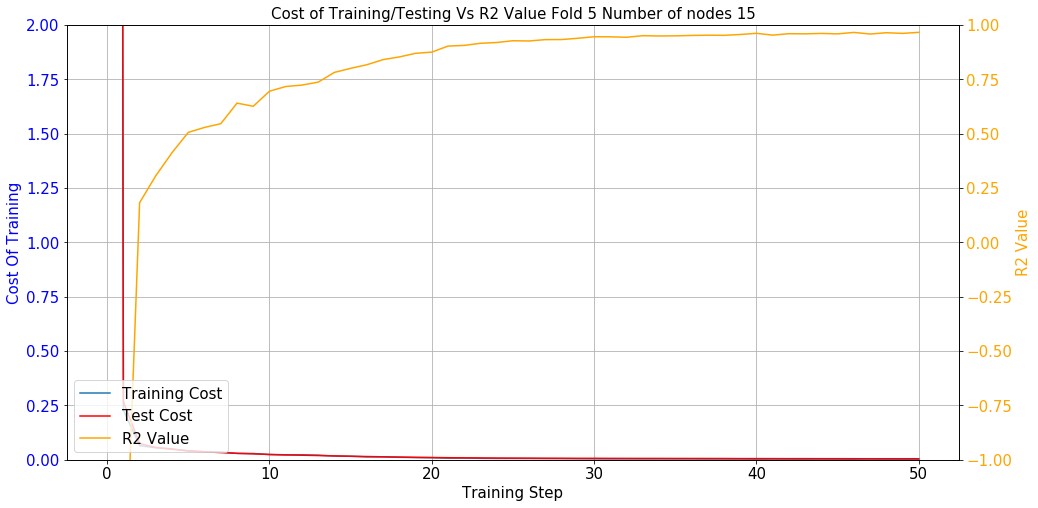

Working on Node 20 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpw_7xb3me', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D0D32C88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.013832242228090763
Cost_test : 0.014769434
R^2:0.8312651515007019
Epoch: 1200/5000 err = 0.010437979362905025
Cost_test : 0.013422216
R^2:0.8574589490890503
Epoch: 1300/5000 err = 0.011144600808620453
Cost_test : 0.01241252
R^2:0.8709123134613037
Epoch: 1400/5000 err = 0.009545557200908661
Cost_test : 0.011337371
R^2:0.8718830347061157
Epoch: 1500/5000 err = 0.007749680895358324
Cost_test : 0.010658149
R^2:0.9039351344108582
Epoch: 1600/5000 err = 0.0069670709781348705
Cost_test : 0.010000753
R^2:0.9117001891136169
Epoch: 1700/5000 err = 0.005900055170059204
Cost_test : 0.009614357
R^2:0.9277071356773376
Epoch: 1800/5000 err = 0.005790658760815859
Cost_test : 0.009084749
R^2:0.9272403120994568
Epoch: 1900/5000 err = 0.005186223890632391
Cost_test : 0.008697373
R^2:0.933098554611206
Epoch: 2000/5000 err = 0.004602221772074699
Cost_test : 0.0083679
R^2:0.9455355405807495
Epoch: 2100/5000 err = 0.004096250515431166
Cost_test : 0.0080005005
R^2:0.9454642534255981
E

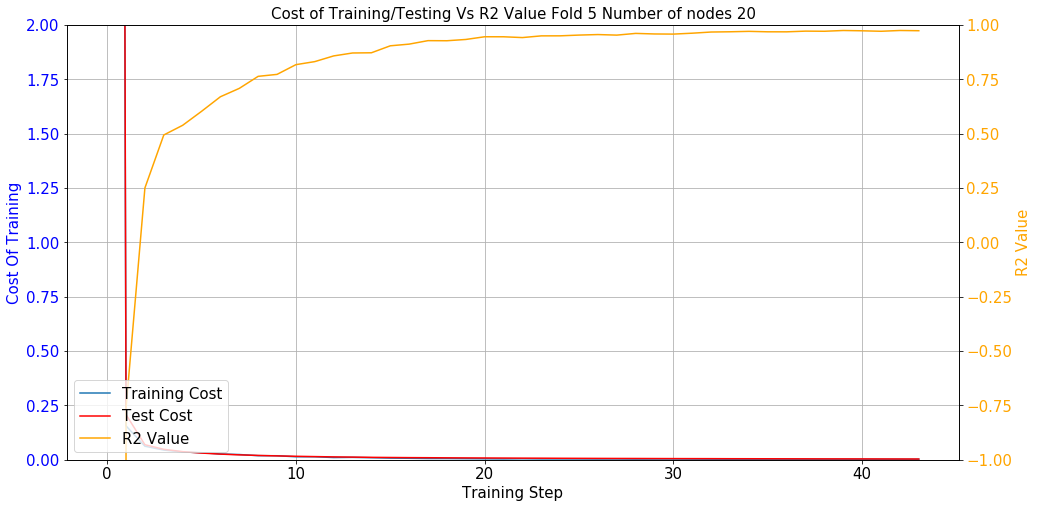

Working on Node 25 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpwergi5yx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000264D6979978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.016905955970287323
Cost_test : 0.015242866
R^2:0.7796282768249512
Epoch: 1200/5000 err = 0.013447546400129795
Cost_test : 0.013604335
R^2:0.8386378288269043
Epoch: 1300/5000 err = 0.013497104868292809
Cost_test : 0.012382173
R^2:0.83286452293396
Epoch: 1400/5000 err = 0.0116572929546237
Cost_test : 0.011385927
R^2:0.8536936640739441
Epoch: 1500/5000 err = 0.010368939489126205
Cost_test : 0.010548274
R^2:0.8671354651451111
Epoch: 1600/5000 err = 0.009687053970992565
Cost_test : 0.00988007
R^2:0.8735697269439697
Epoch: 1700/5000 err = 0.00890450831502676
Cost_test : 0.0093271155
R^2:0.8859758377075195
Epoch: 1800/5000 err = 0.007896327413618565
Cost_test : 0.008896002
R^2:0.9028670787811279
Epoch: 1900/5000 err = 0.007798324339091778
Cost_test : 0.008497579
R^2:0.9030378460884094
Epoch: 2000/5000 err = 0.007123524788767099
Cost_test : 0.00818696
R^2:0.9097723364830017
Epoch: 2100/5000 err = 0.0067711868323385715
Cost_test : 0.007968073
R^2:0.9115701913833618
Epoc

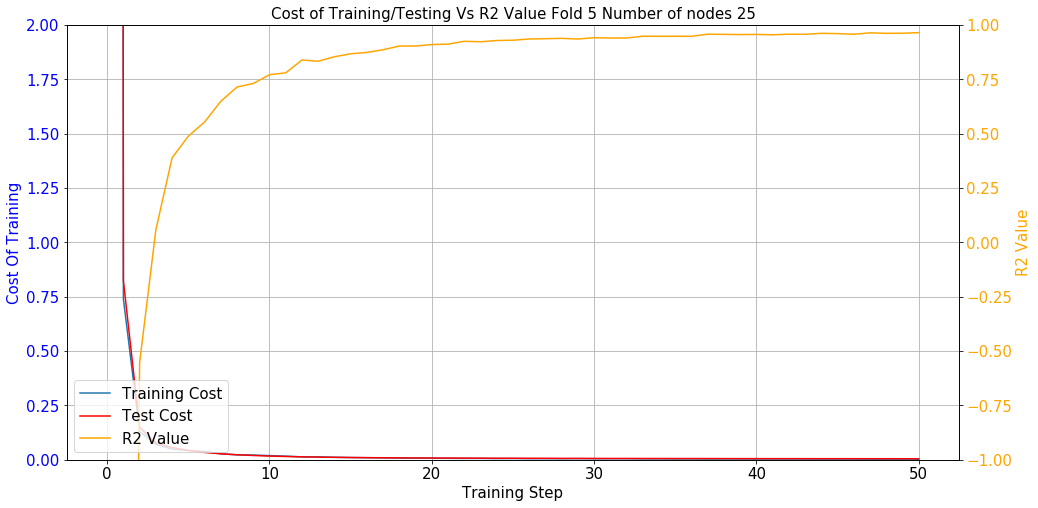

In [41]:
from sklearn.model_selection import KFold
#Prediction Grid
x,y,z = griddef.gridcoord()
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])
print(min_val)
print(max_val)
datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)
data_x = np.hstack((x.reshape(len(x),1),y.reshape(len(y),1),z.reshape(len(z),1)))/100
kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(datatest)
fold_num= 0
columns = ['X','Y','Z','value']
n_batch = 1
RFB_type = 'Gaussian'
for train_index, test_index in kf.split(datatest):
    fold_num += 1
    print(fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    data_train, data_test = datatest[train_index,0:3]/100, datatest[test_index,0:3]/100
    target_train, target_test = datatest[train_index,3:4], datatest[test_index,3:4]
    gs.write_gslib(pd.DataFrame(np.hstack((data_train*100,target_train*(max_val-min_val)+min_val)),columns=columns), './data/data_train_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(np.hstack((data_test*100,target_test*(max_val-min_val)+min_val)),columns=columns), './data/data_test_{}.dat'.format(fold_num))
    row = 0
    NN = 'ERBFN' # RBFN or GRNN or 'EBFN'
    data_type = 'Continuous' # Continuous or Categorical
    test_nodes = [10,15,20,25]
    pred_all = np.zeros((len(test_nodes)*data_x.shape[0],target_train.shape[1]))
    pred_all_row = np.zeros((data_x.shape[0],target_train.shape[1],len(test_nodes)))
    info_matrix = np.zeros((len(test_nodes),8))
    for nodes in test_nodes:
        c_t = []
        c_test = []
        c_r2 = []
        start_time = time.time()
        print("Working on Node {} fold {} ".format(nodes,fold_num))
        k = nodes
        data_trainpd = pd.DataFrame(data_train)
        data = data_trainpd

        with tf.device('/device:CPU:0'):
            #clustering
            def input_fn():
              return tf.train.limit_epochs(
                  tf.convert_to_tensor(data_train, dtype=tf.float32), num_epochs=1)

            kmeans = tf.contrib.factorization.KMeansClustering(
                num_clusters=nodes, use_mini_batch=False)


            # train
            num_iterations = 10
            previous_centers = None
            for _ in range(num_iterations):
              kmeans.train(input_fn)
              cluster_centers = kmeans.cluster_centers()
              #if previous_centers is not None:
                #print('delta:', cluster_centers - previous_centers)
              previous_centers = cluster_centers
              #print('score:', kmeans.score(input_fn))
            #print('cluster centers:', cluster_centers)
            
            
        with tf.device('/device:GPU:0'):
            from tensorflow.python.framework import ops
            ops.reset_default_graph()


            RANDOM_SEED = 42
            tf.set_random_seed(RANDOM_SEED)

            N_INSTANCES = np.shape(data_train)[0]
            N_INPUT = data_train.shape[0]
            N_FEATURE = data_train.shape[1]
            N_CLASSES = target_train.shape[1]
            TRAIN_SIZE = int(N_INSTANCES)
            batch_size = int(np.shape(data_train)[0]/n_batch)
            training_epochs = 5000
            if nodes >= 2:
                training_epochs = 5000
            if nodes >= 25:
                training_epochs = 5000
            if nodes >= 100:
                training_epochs = 5000
            if nodes >= 1000:
                training_epochs = 5000
            learning_rate = 0.01
            epsilon = 0.001
            display_step = 100
            hidden_size = nodes

            target_ = np.zeros((N_INSTANCES, N_CLASSES))
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            x_data = tf.placeholder(shape=[None, N_FEATURE], dtype=tf.float32, name = 'Features')
            y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32, name = 'Known_Values')


            dist = np.zeros((k,k))
            for i in range (0,k):
                for j in range (0,k):
                    dist[i:j] = distance.euclidean(cluster_centers[i], cluster_centers[j])
                    maxdist = dist.max()
            sigma = maxdist/np.sqrt(2*k)
            if nodes == 1 :
                beta = 0.2
            else:        
                beta = 1/math.pow(2*sigma,2)

            #EBFN
            if NN == 'ERBFN':
                def rbf_network(input_layer, cluster_centers ,weights):

                    exp_list= []
                    with tf.name_scope('Cluster_Centers'):
                        yy = weights['cluster_centers']

                    with tf.name_scope('Input_Layer'):
                        input_layer

                    for i in range(nodes):
                        with tf.name_scope('Covariance_Matrix'):
                            vv = weights['cov_mat'][:,:,i]
                            symA = 0.5 * tf.math.add(vv , tf.transpose(vv))

                        with tf.name_scope('Mahalanobis_Distance'):
                            cc_i = yy[i]

                            diff = tf.subtract(input_layer, cc_i , name = 'subtract')

                            dt = tf.transpose(diff,name = 'Transpose')

                            M1 = tf.matmul(diff,symA,name = 'M1')

                            M2 = tf.matmul(M1,dt,name = 'M2')

                            sqrt = tf.math.sqrt(tf.math.abs(M2),name = 'sqrt')

                            diag = tf.linalg.tensor_diag_part(sqrt,name = 'diag') 

                        with tf.name_scope('Gaussian_Activation_Layer'):
                            gauss_f = tf.math.exp((-tf.math.pow((weights['beta'][:,i]*diag), 2)))
                            exp_list.append(gauss_f)

                    with tf.name_scope('Output_Layer'):        
                        layer2_act = tf.stack(exp_list)   
                        output = tf.add(tf.matmul(layer2_act, weights['output'],transpose_a=True,name = 'mult_layer2_by_weights'), bias['output'], 
                                    name = 'add_bias_to_output')     
                    return output


            weights = {
                'h1': tf.Variable(tf.ones([N_FEATURE, N_FEATURE,nodes]), name = 'layer1_dims'),
                'output': tf.Variable(tf.ones([nodes, N_CLASSES]), name = 'layer2_output_Weights'),
                'cov_mat': tf.Variable(tf.ones(shape = [N_FEATURE,N_FEATURE,nodes]), name = 'cov'),
                'beta' : tf.Variable(tf.constant(beta,shape = [1,nodes]) ,name = 'beta'),            
                'cluster_centers' : tf.Variable(tf.constant(np.asarray(cluster_centers).reshape(nodes,N_FEATURE),
                                    shape = [nodes,N_FEATURE]), name = 'cluster_center')
            }

            bias = {
                'output' : tf.Variable([0],name='output_bias',dtype=tf.float32)  
            }


            pred = rbf_network(x_data, cluster_centers ,weights)

            if data_type == 'Continuous':
                with tf.name_scope('cost'):
                    cost = tf.reduce_mean(tf.square(pred - y_target))
                    #cost = tf.math.reduce_sum(tf.square(pred - y_target)) 
                    my_opt = tf.train.AdamOptimizer(learning_rate,beta1=0.5).minimize(cost)  
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    total_error = tf.reduce_sum(tf.square(tf.subtract(y_target, tf.reduce_mean(y_target))))
                    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_target, pred)))
                    accuracy = tf.subtract(1.00, tf.divide(unexplained_error, total_error))

            if data_type == 'Categorical':
                with tf.name_scope('cost'):
                    if N_CLASSES == 1:
                        cost = tf.reduce_mean(tf.square(tf.round(pred) - y_target)) 
                    else:
                        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = pred))
                    my_opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    correct_prediction = tf.equal(tf.round(pred), y_target)
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#             tf.summary.histogram("cov_mat", weights['cov_mat'])
#             tf.summary.histogram("Weights_Output_Layer", weights['output'])
#             tf.summary.histogram("Bias_Output_Layer", bias['output'])




            init = tf.global_variables_initializer()
            sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
            merged = tf.summary.merge_all()
            saver = tf.train.Saver()
            writer = tf.summary.FileWriter('./test',sess.graph)
            sess.run(init)
            tol = 0.00001
            epoch, err, acc=0, 1, 0
            # Training loop
            #saver.restore(sess,'./spatial/test_dataset_{}.ckpt'.format(nodes))
            while epoch <= training_epochs and err >= tol and acc <= 0.98:

                avg_cost = 0.
                acc = 0.
                total_batch = int(data_train.shape[0] / batch_size)
                for i in range(total_batch):
                    randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
                    batch_xs = data_train[randidx , :]
                    batch_ys = target_train[randidx , :]
                    sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
                    avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                    acc += sess.run(accuracy, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                err = avg_cost
                if epoch % 100 == 0:
                    #summary = sess.run([merged],feed_dict={x_data: batch_xs, y_target: batch_ys})
                    #writer.add_summary(summary,epoch)
                    print("Epoch: {}/{} err = {}".format(epoch, training_epochs, avg_cost))
                    print('Cost_test :',sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_t.append(avg_cost)
                    c_test.append(sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_r2.append(acc)
                    if data_type == 'Categorical': 
                        print("Accuracy:{}".format(acc))
                    else:
                        print("R^2:{}".format(acc))    

                epoch +=1

            print ("End of learning process")
            print ("Final epoch = {}/{} ".format(epoch, training_epochs))
            print ("Final error = {}".format(err) )
            print ("Final R^2 = {}".format(acc) )
            saver.save(sess,'./spatial/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            w = np.vsplit(data_x,500)[0].shape[0]
            pred1 = np.zeros((data_x.shape[0],N_CLASSES))
            for i in range(0,500):
                pred1[i*w:(1+i)*w,0:N_CLASSES] = (sess.run(pred, feed_dict={x_data:np.vsplit(data_x,500)[i]}))*(max_val-min_val)+min_val
                pred_all[i*w+(row*data_x.shape[0]):(1+i)*w+(row*data_x.shape[0]),0:N_CLASSES] = pred1[i*w:(1+i)*w,0:N_CLASSES]
                pred_all_row[i*w:(1+i)*w,0:N_CLASSES,row] = pred1[i*w:(1+i)*w,0:N_CLASSES]

            writer = tf.summary.FileWriter("sess_graph", sess.graph)
            saver.save(sess,'test/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            sess.close() 

            gs.write_gslib(pd.DataFrame(pred1), './predictions/real_{}_{}.dat'.format(nodes,fold_num))

            info_matrix[row,0] = k
            info_matrix[row,1] = beta
            info_matrix[row,2] = 0 #r2_score(sgsimfl['value'],pred1)
            info_matrix[row,3] = np.mean(pred1)
            info_matrix[row,4] = np.var(pred1)
            info_matrix[row,5] = 0 #mean_squared_error(sgsimfl['value'],pred1)
            info_matrix[row,6] = err
            info_matrix[row,7] = (time.time() - start_time) 
            row +=1
            tf.InteractiveSession.close(sess)
        print(info_matrix)
        SMALL_SIZE = 15
        plt.rc('font', size=SMALL_SIZE)
        plt.rc('axes', titlesize=SMALL_SIZE)
        f, (ax1) = plt.subplots(1, 1,figsize=(16, 8))
        ax1.set_ylim([0,2])
        ax1.plot(range(len(c_t)), c_t, label ='Training Cost')
        ax1.plot(range(len(c_t)), c_test, color="red",label ='Test Cost')
        ax1.set_xlabel('Training Step')
        ax1.grid(True)
        ax1.set_title('Cost of Training/Testing Vs R2 Value Fold {} Number of nodes {}'.format(fold_num,nodes))
        ax1.set_ylabel('Cost Of Training', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.plot(range(len(c_t)), c_r2,'-',color="orange",label ='R2 Value')
        ax2.set_ylim([-1,1])
        ax2.set_ylabel('R2 Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=3)
        plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Training_R2_ERBFN_{}_{}_{}.png'.format(nodes,fold_num,plt_extent))
        plt.show()


    ensemble = numpy.nanmean(pred_all_row, axis = 2)
    gs.write_gslib(pd.DataFrame(ensemble), './predictions/ensemble_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(pred_all), './predictions/all_real_{}.dat'.format(fold_num))

In [21]:
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
2                                 -number of directions
0 90 200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  80  40                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill



NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
2                            -number of directions to model points along
    0.0  00.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0:0.99    0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        50:175     50:175     25:3000    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
25    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
500.0  500.0  250.0              -maximum search radii
0.0  0.0   0.0                 -angles for search ellipsoid
0                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.62 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""

In [28]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
for fold in range(1,6):
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))

    

    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold))

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_1.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   80.0000000000000     
   40.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   10.0000000000000     
   5.00000000000000     
  output file: ./vargs/varcalc_1.out
  legacy output?      

 Final objective value =   2.800761137614714E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.100

  data file = ./data/data_train_2.dat                 
  columns =            0           1           2           3           4
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_2.out               
  nx, xmn, xsiz =           50   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

   currently on estimate      6250
   currently on estimate     12500
   currently on estimate     18750
   currently on estimate     25000
   currently on estimate     31250
   currently on estimate     37500
   currently on estimate     43750
   currently on estimate     50000
   currently on estimate     56250
   currently on estimate     62500

 KT3DN Version:    7.100 Finished

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_4.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   80.0000000000000     

 Final objective value =   2.713897535434190E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.100

  data file = ./data/data_train_5.dat                 
  columns =            0           1           2           3           4
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_5.out               
  nx, xmn, xsiz =           50   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

In [8]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21          -  trimming limits
./declus/declus_{fold}.sum                  -file for summary output
./declus/declus_{fold}.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
99  10.0  110.0               -number of cell sizes, min size, max size
100                           -number of origin offsets
"""


varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
2                                 -number of directions
0  90   200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
2                            -number of directions to model points along
    0.0  00.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0:0.99    0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        175     175     25:3000    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
0                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}              -file with data
0  {xyzcol}  {varcol}  {seisnscol}                 -  columns for DH,X,Y,Z,var,sec var
-99    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./ML+ICCK/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
10    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
200  200  200              -maximum search radii
 0   0.0   0.0                 -angles for search ellipsoid
7                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0  {corr}  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
{seisfl}                     -gridded file with drift/mean
{seiscol}                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""


In [9]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
declus = gs.Program('declus')   

griddef2 = gs.GridDef(gridfl='griddef2.txt')

for fold in range(1,6):
    
    sesi_data = gs.DataFile('predictions\ensemble_{}.dat'.format(fold))
    
    sesi_data = gaussian_filter((sesi_data.data['0']),sigma = 0)
    
    gs.write_gslib(pd.DataFrame(sesi_data),'predictions\smooth_ensemble_{}.dat'.format(fold))
    
    sesi_data = gs.DataFile('predictions\smooth_ensemble_{}.dat'.format(fold))
    
    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('value'),
                         fold = fold))
    
    Testdat = gs.DataFile('declus/declus_{}.out'.format(fold),griddef=griddef)
    
    idx,ingrid = griddef.coord_to_index1d(x=Testdat.data['X'],y=Testdat.data['Y'],z=Testdat.data['Z'])
    
    Testdat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Testdat,'./data/data_test_NS_{}.dat'.format(fold))
    
    Testdat = gs.DataFile('./data/data_test_NS_{}.dat'.format(fold))   
    
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))
    
    idx,ingrid = griddef.coord_to_index1d(x=Traindat.data['X'],y=Traindat.data['Y'],z=Traindat.data['Z']) 
    
    Traindat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Traindat,'./data/data_train_NS_{}.dat'.format(fold))
    
    Traindat = gs.DataFile('./data/data_train_NS_{}.dat'.format(fold))
    

    
#     Traindat = gs.DataFile('declus.out',griddef=griddef)  
        
#     for i in range(len(Traindat['value'])):
#         if Traindat['sesi_data'].isna()[i] == True:
#             Traindat['sesi_data'][i] = Traindat['value'][i]
            
    gs.write_gslib(Traindat,'./nscore/runfl_{}.out'.format(fold))      

    Traindat = gs.DataFile('nscore/runfl_{}.out'.format(fold),griddef=griddef)
    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))


    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open('./vargs/varmodel_{}.var'.format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    declus_mean = np.min(np.asarray(gs.DataFile('./declus/declus_{}.sum'.format(fold)).data['Declustered Mean'][gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                                 seisfl = sesi_data.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             seiscol = sesi_data.gscol('0'),
                             griddef = griddef2,
                             varg = varg,
                             mean = declus_mean,
                             seisnscol = Traindat.gscol('sesi_data'),
                             corr = np.corrcoef(Traindat.data.dropna()['value'],Traindat.data.dropna()['sesi_data'])[0,1],
                             fold = fold))
    
    
    kt3dnfl = gs.DataFile('./ML+ICCK/kt3dn_{}.out'.format(fold))
    
    kt3dnfl.data['Back Transform'] = kt3dnfl.data['Estimate']
    
    gs.write_gslib(kt3dnfl,'./backtr/backtr_UDDH_{}.out'.format(fold))
    

NameError: name 'Traindat' is not defined

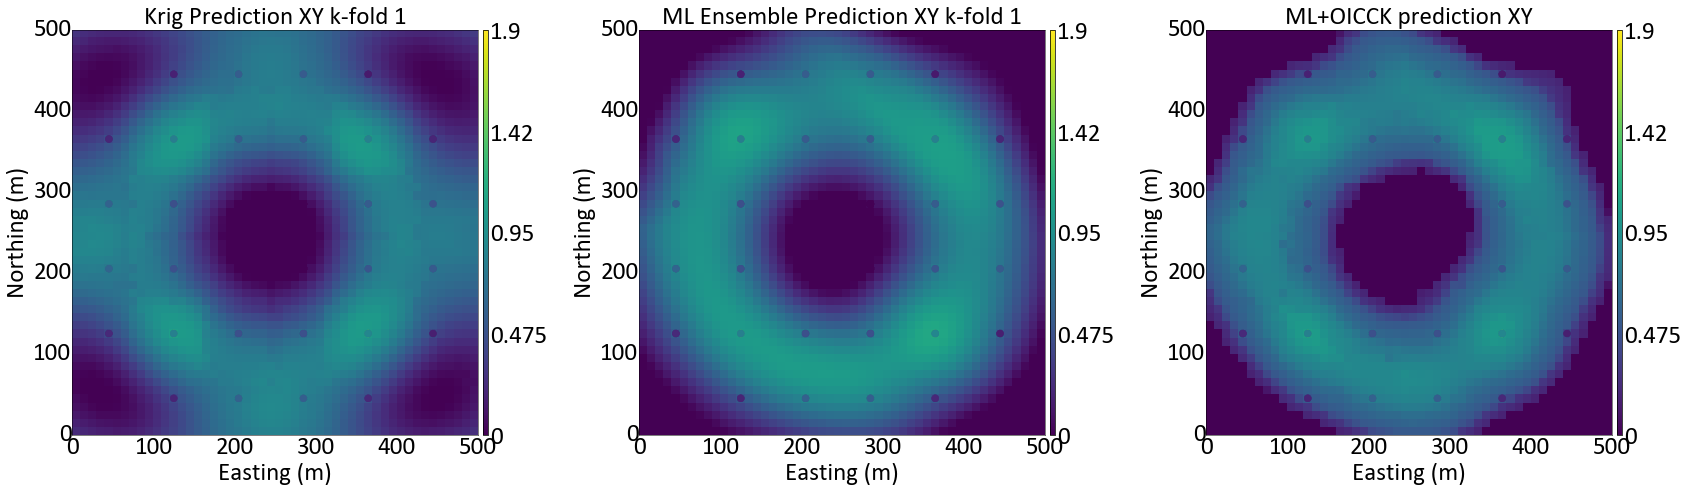

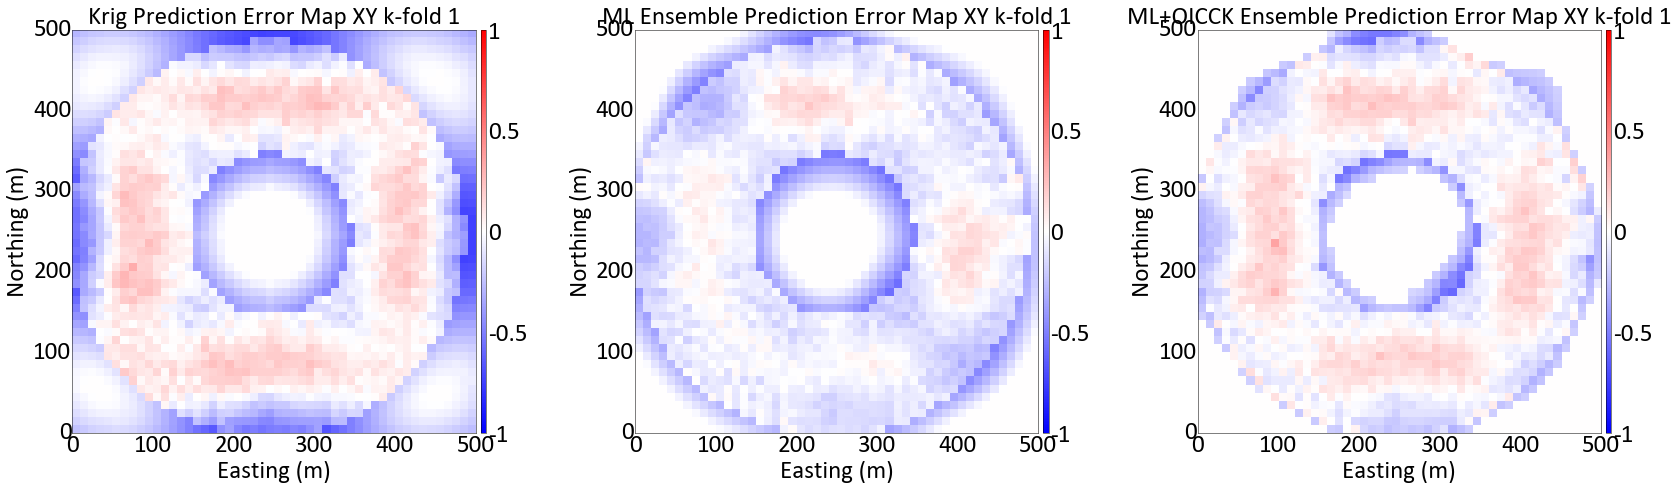

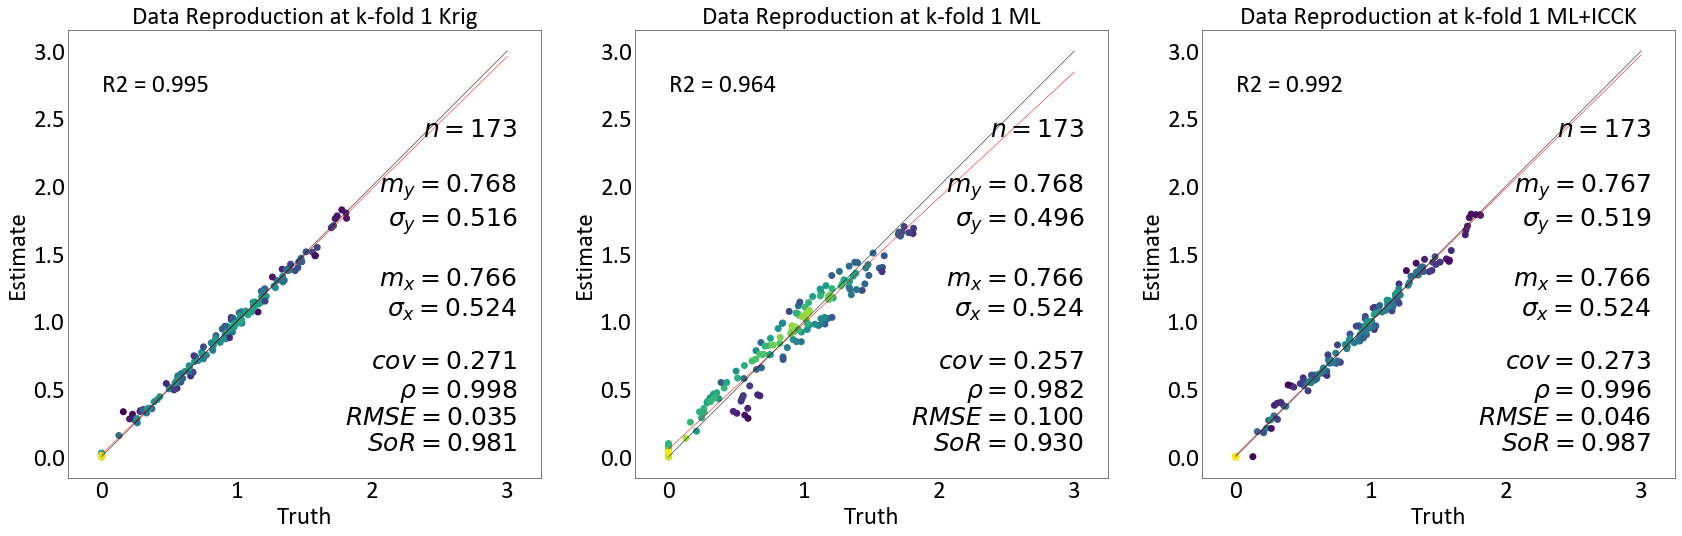

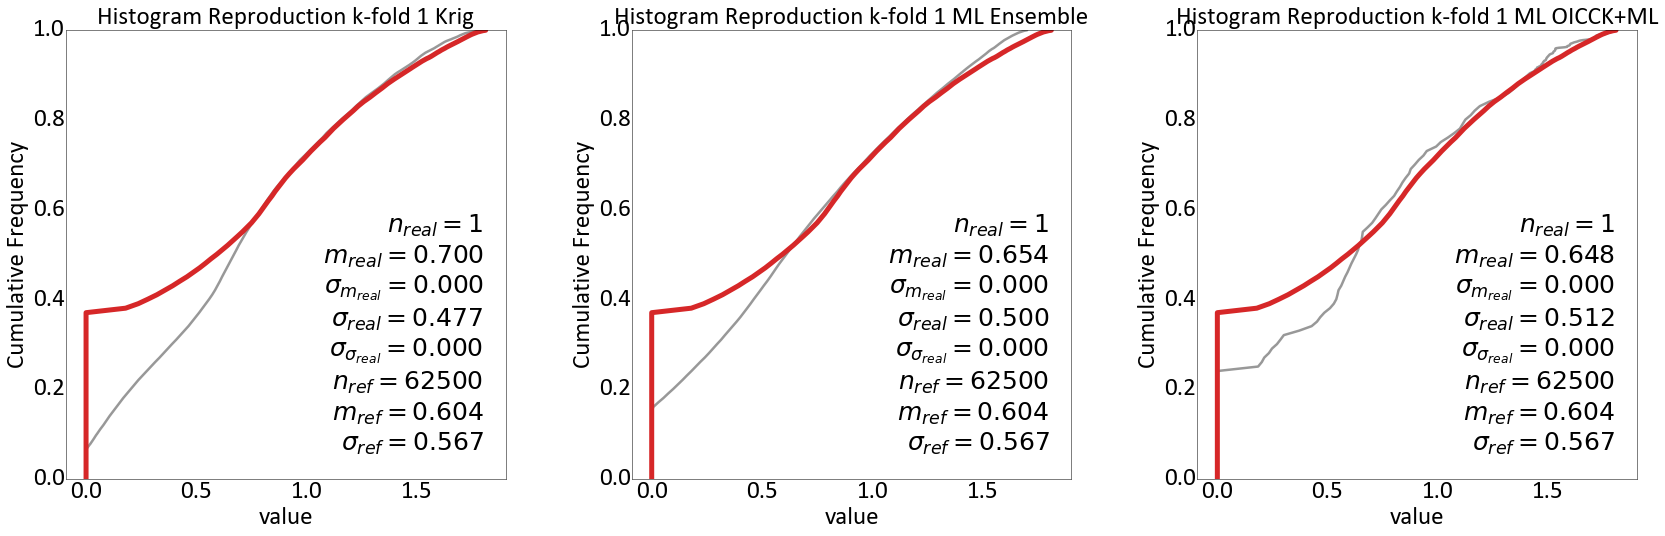

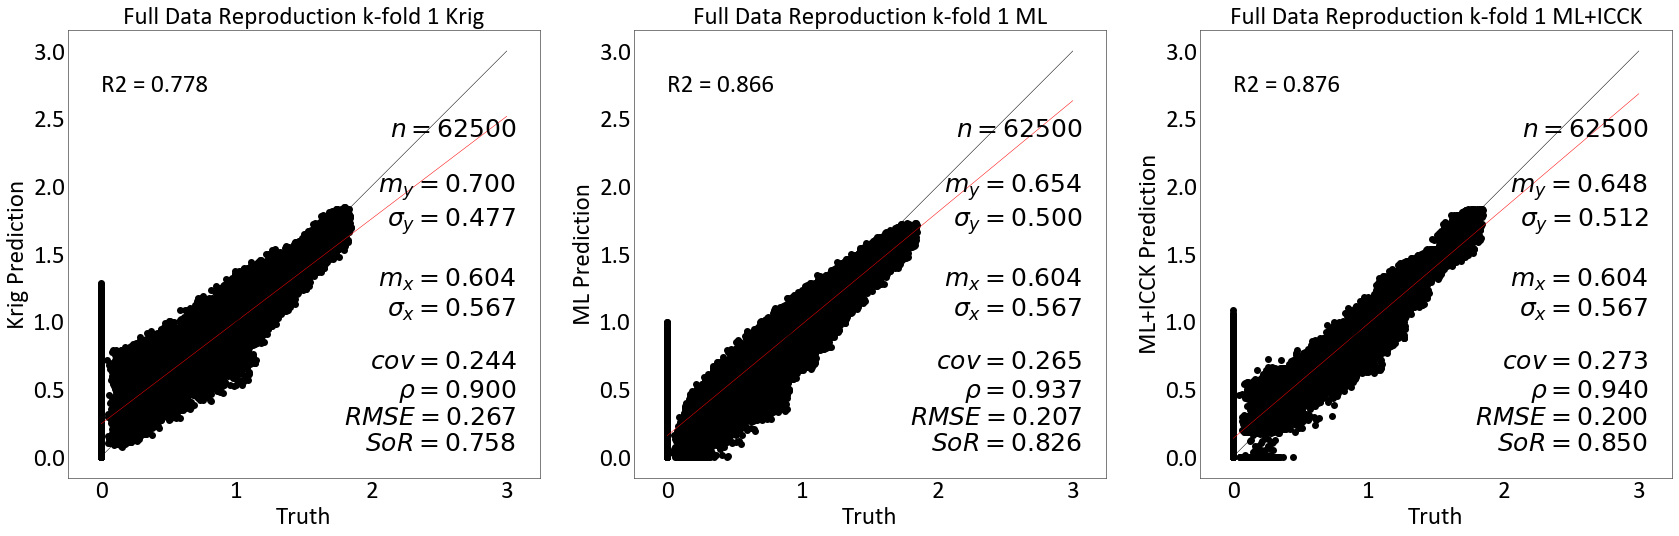

the r2 for krig k-fold 0.9954517882185149
the r2 for ML k-fold 0.9636456675489523
the r2 for krig full 0.7777882307829793
the r2 for ML full 0.8663064571268217


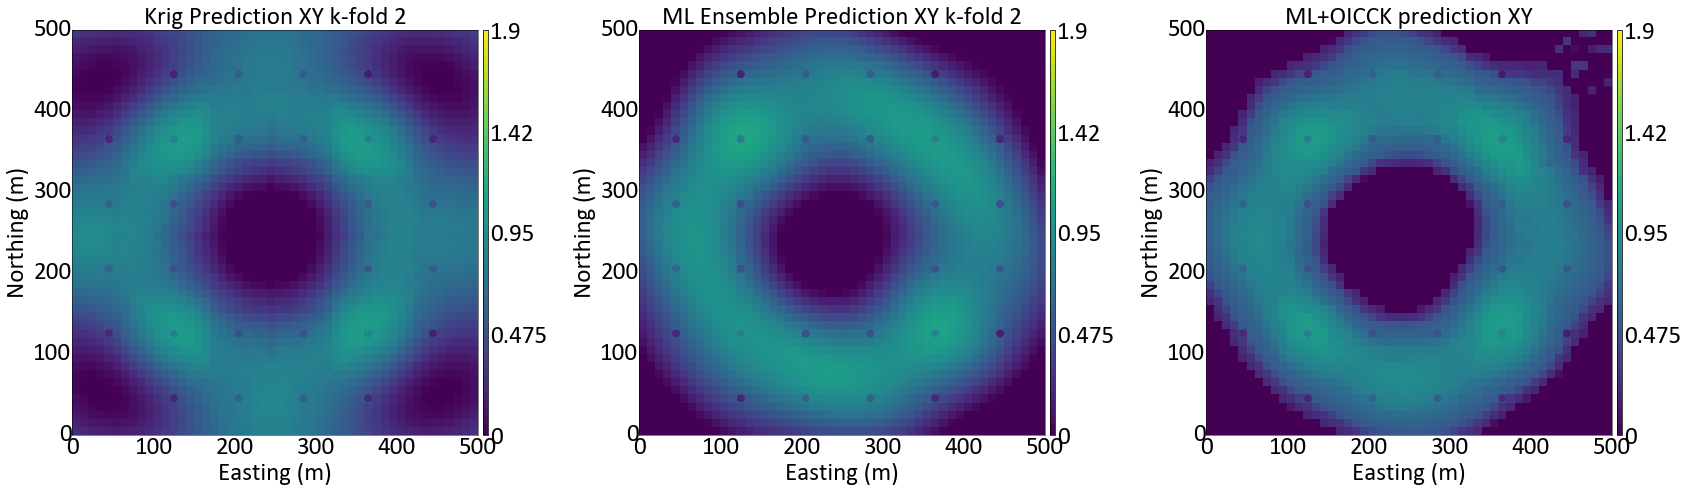

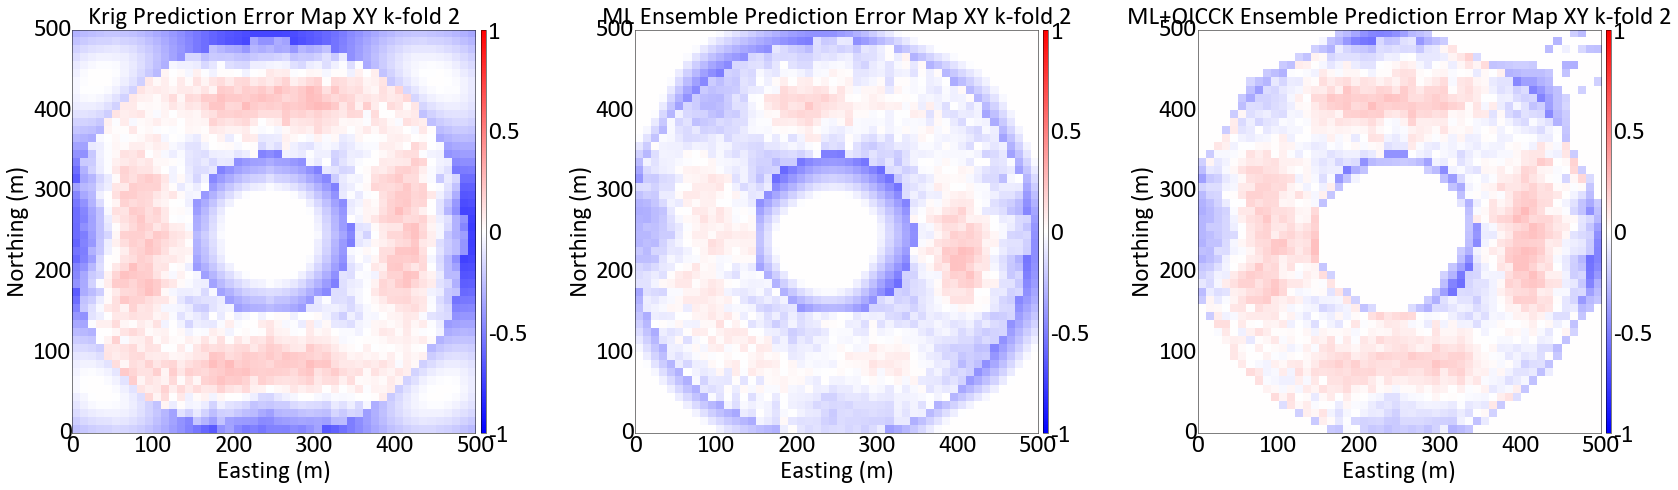

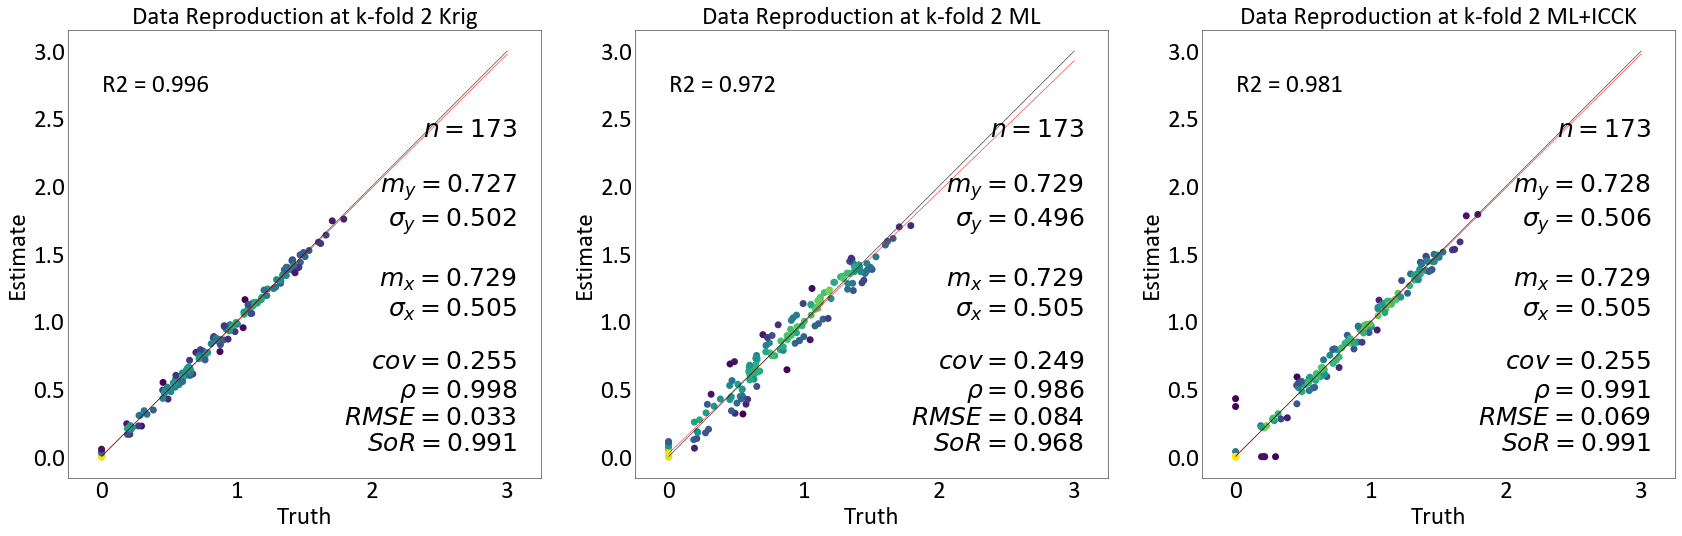

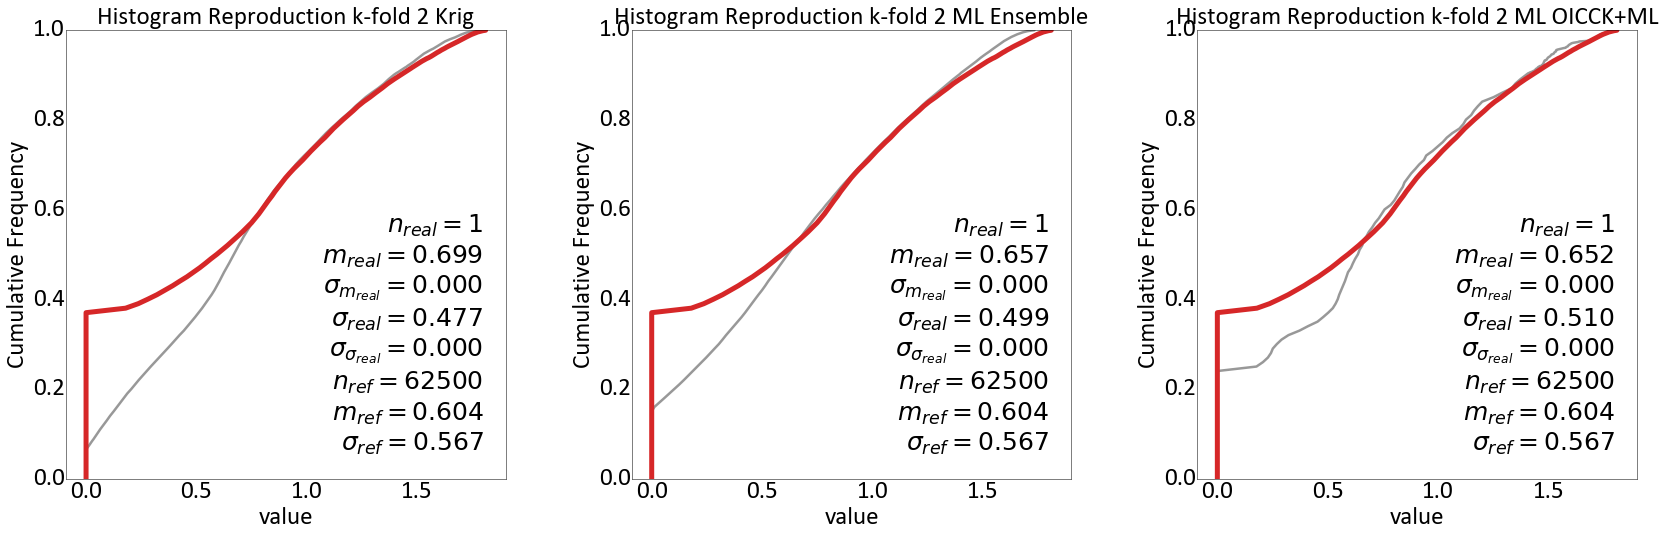

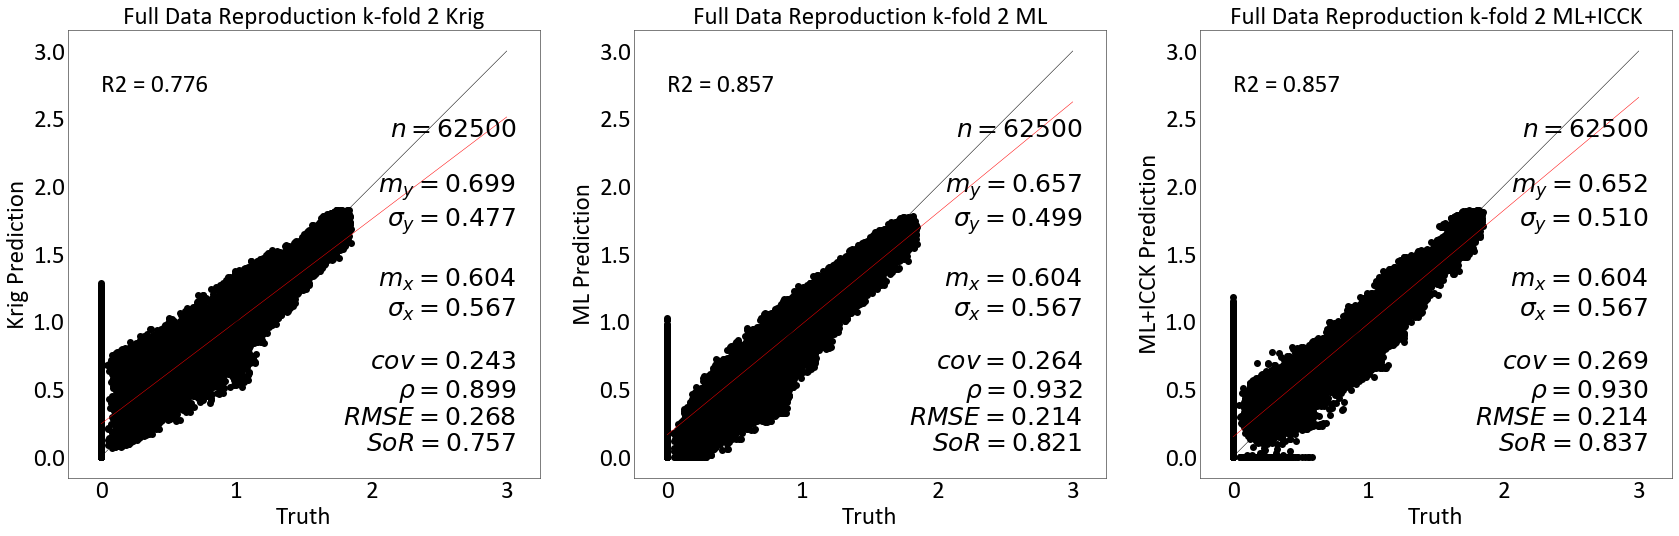

the r2 for krig k-fold 0.9957086974258458
the r2 for ML k-fold 0.9723645199864005
the r2 for krig full 0.7762829533064728
the r2 for ML full 0.8571364907643895


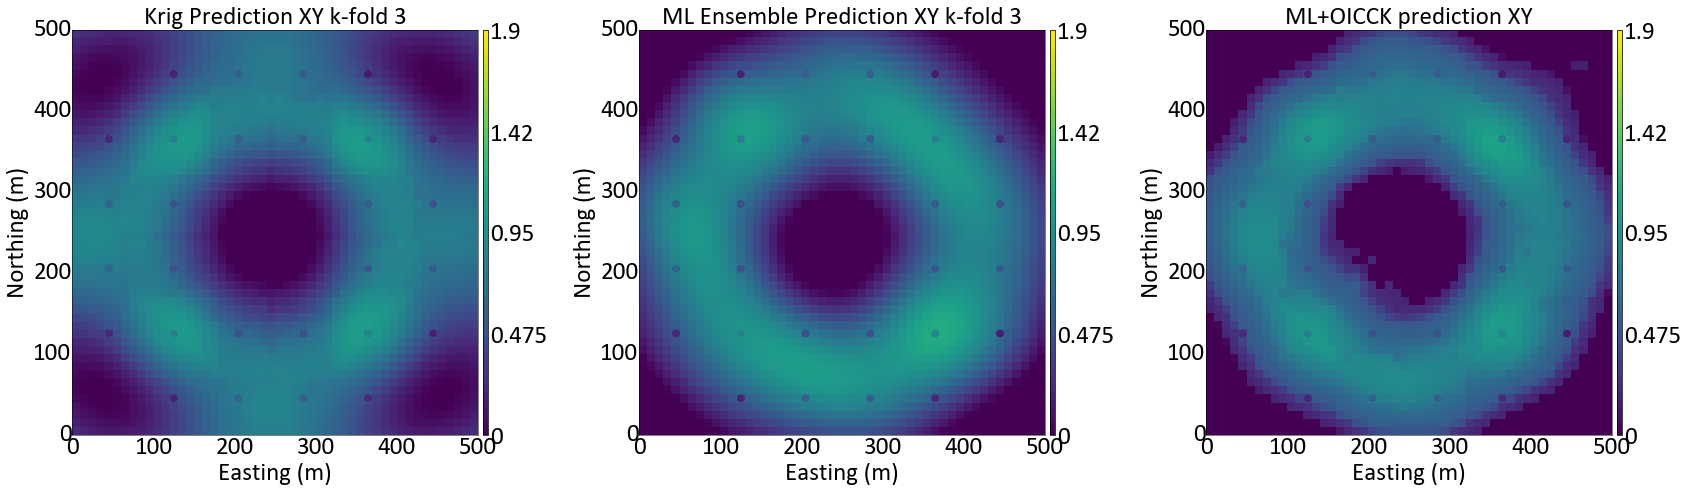

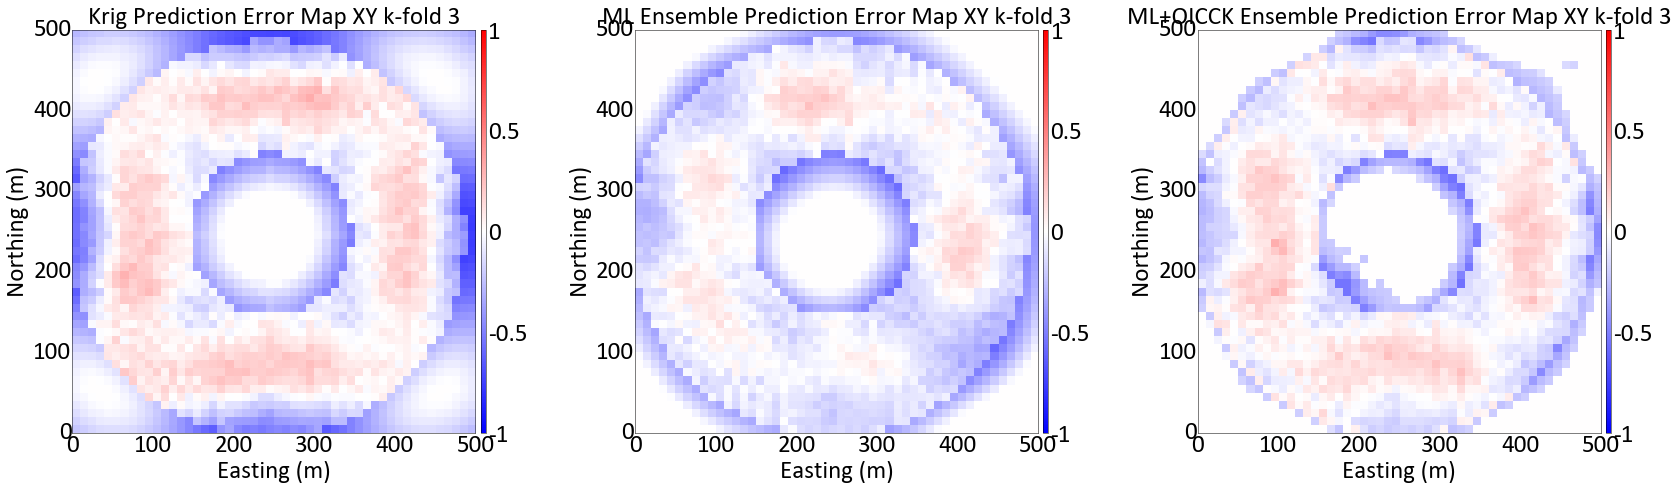

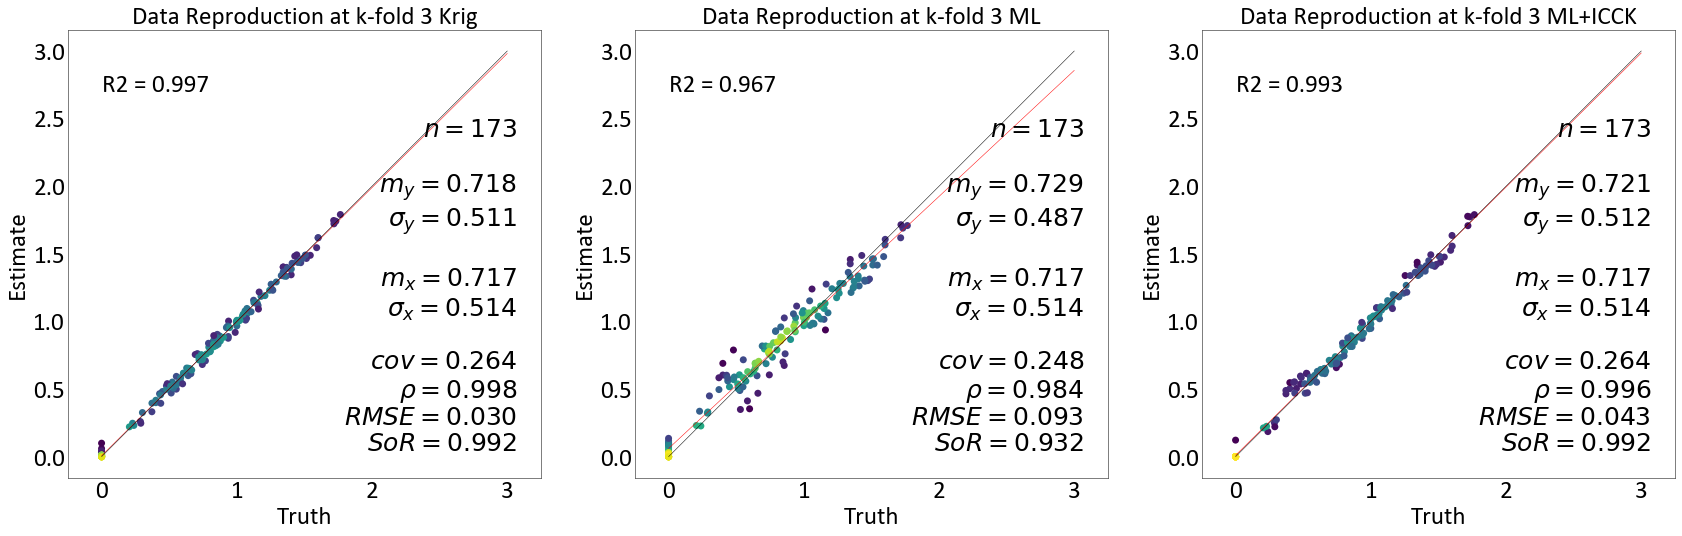

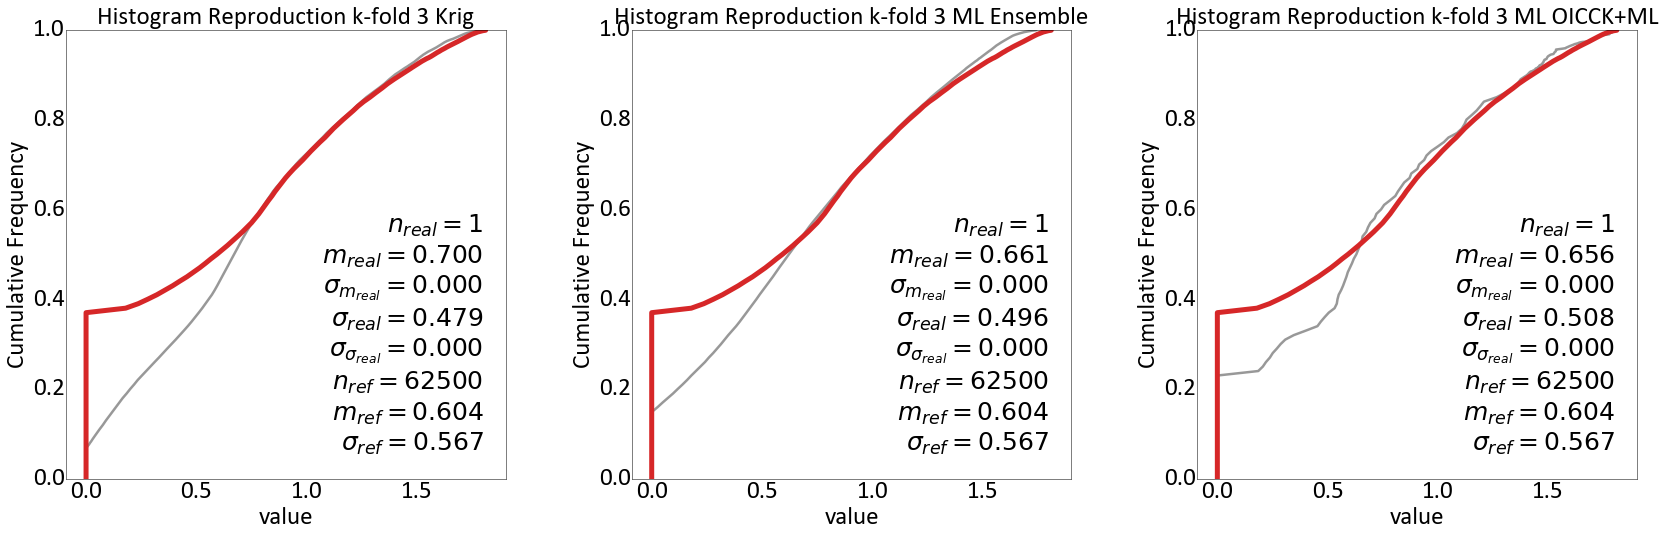

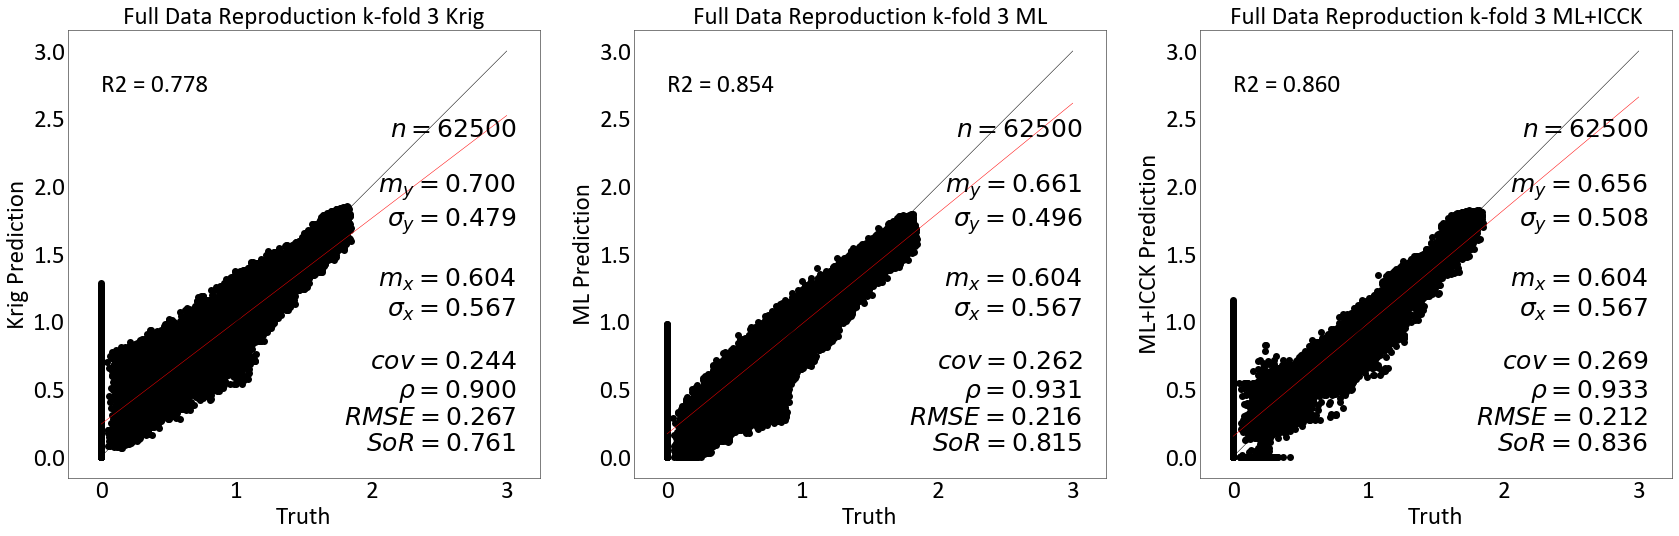

the r2 for krig k-fold 0.9965005203467531
the r2 for ML k-fold 0.9671680753396537
the r2 for krig full 0.7782102633195465
the r2 for ML full 0.8544070283462742


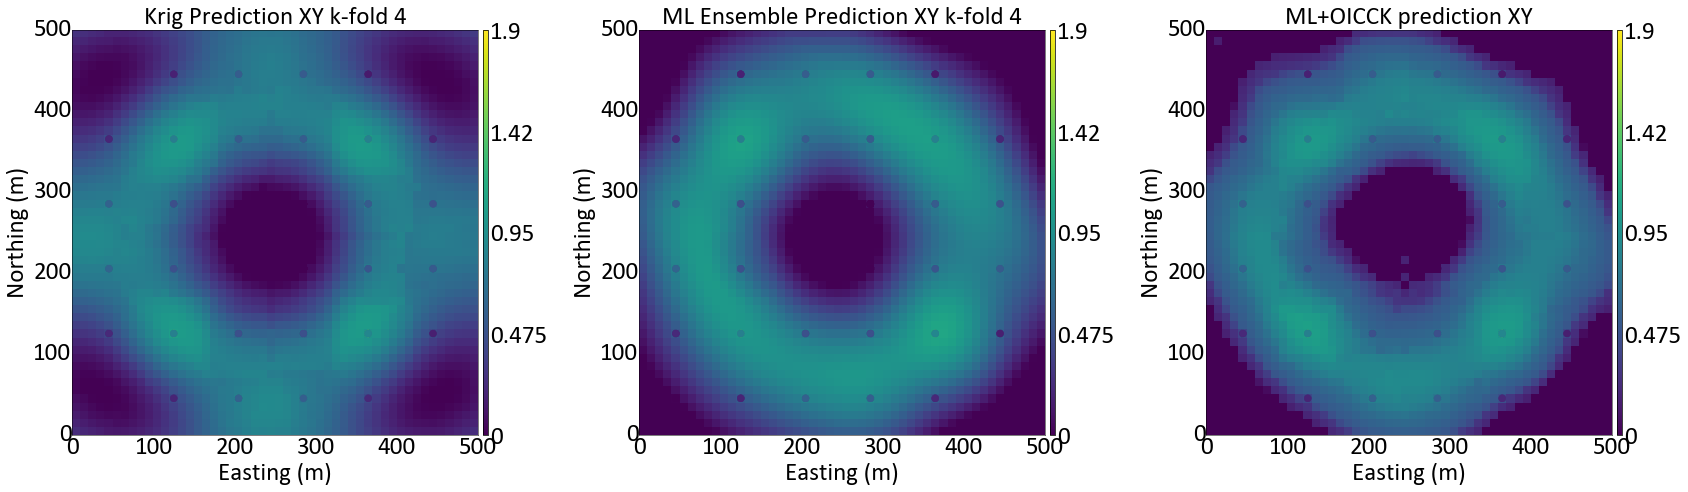

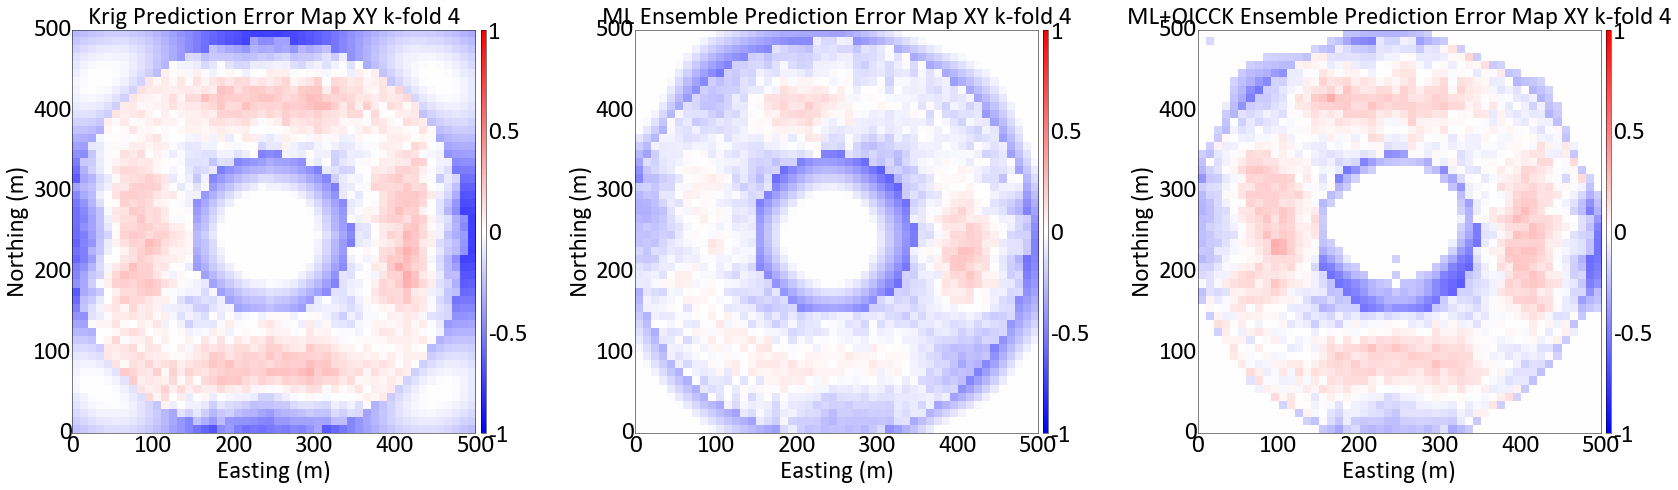

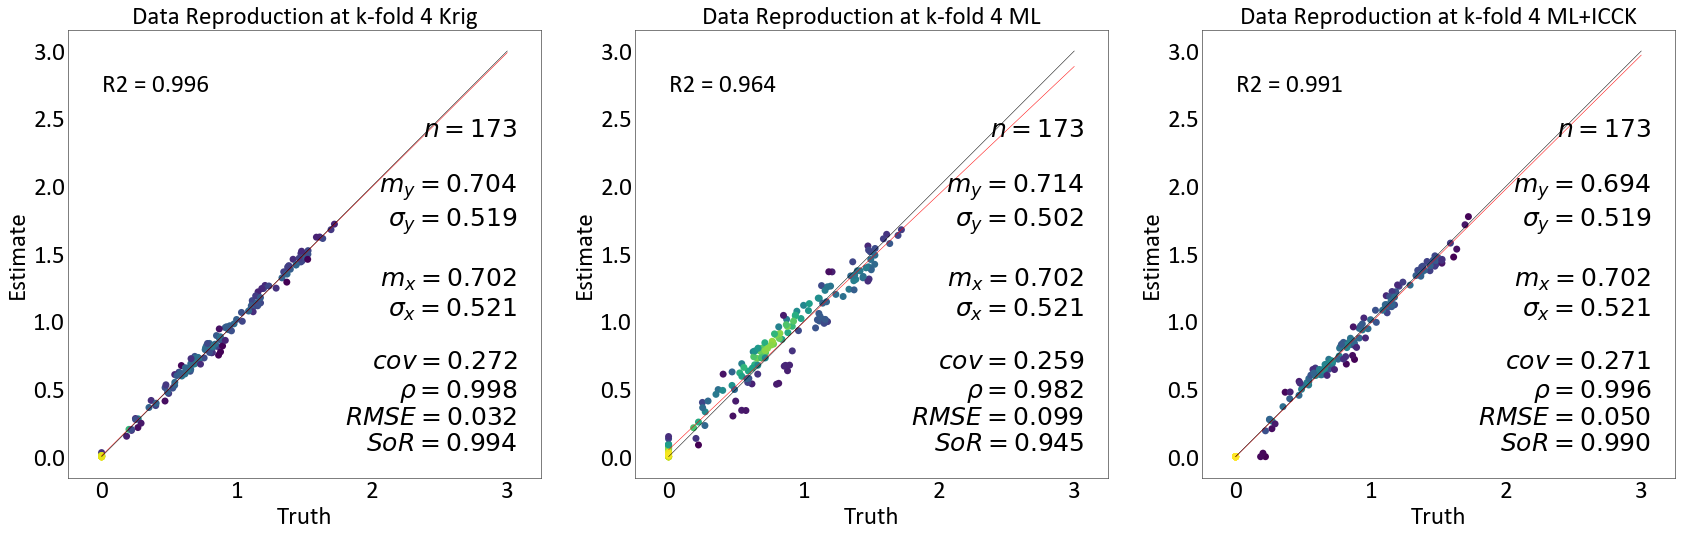

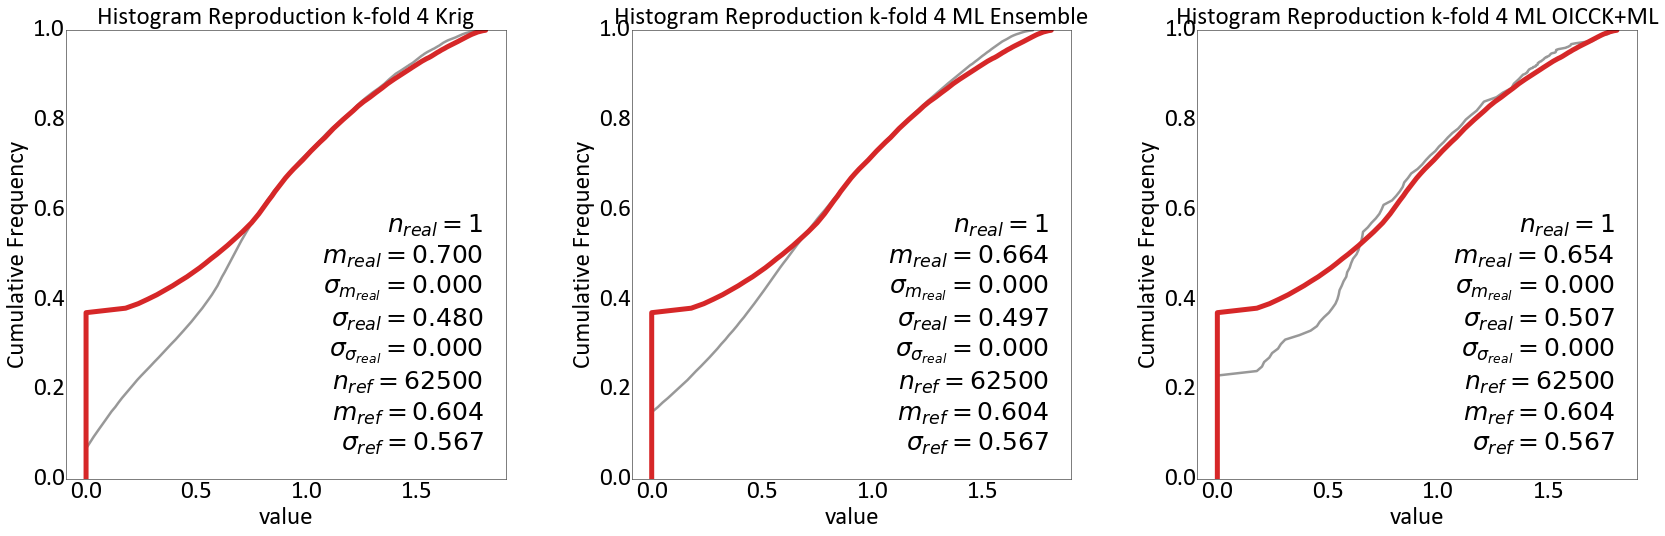

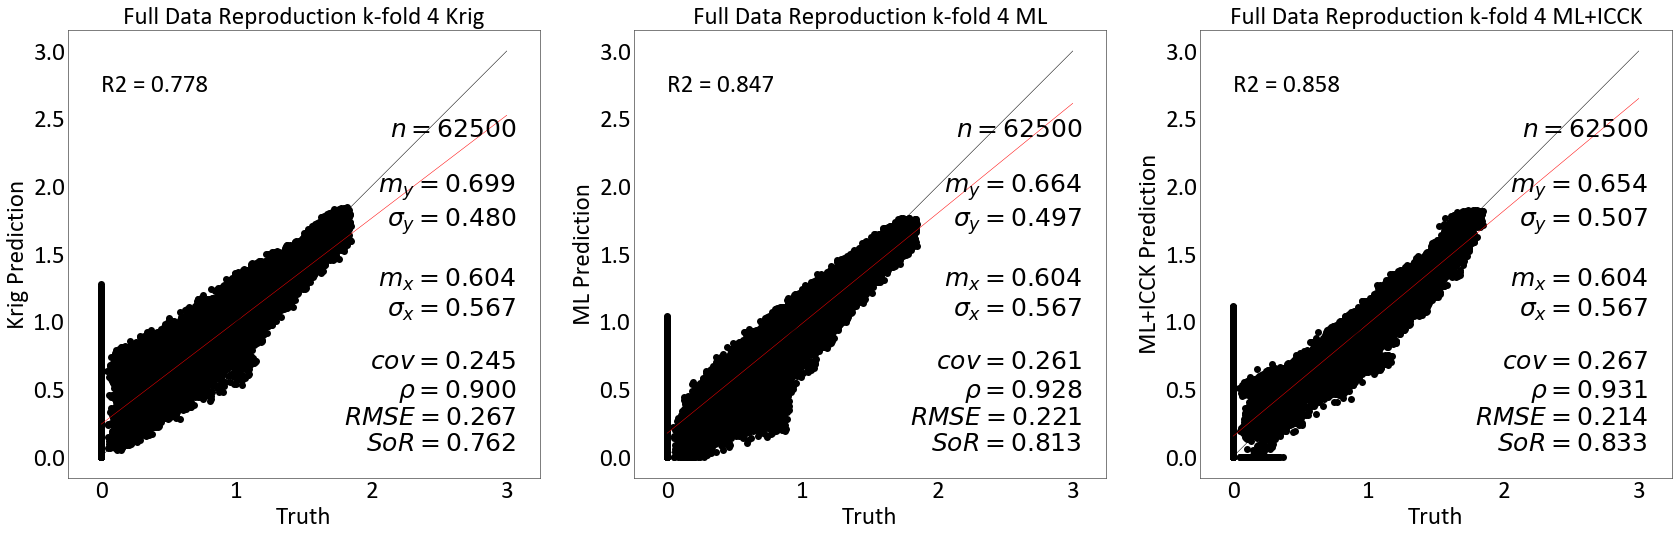

the r2 for krig k-fold 0.9962669084725204
the r2 for ML k-fold 0.9639228039579321
the r2 for krig full 0.7782863648538059
the r2 for ML full 0.8473617165868959


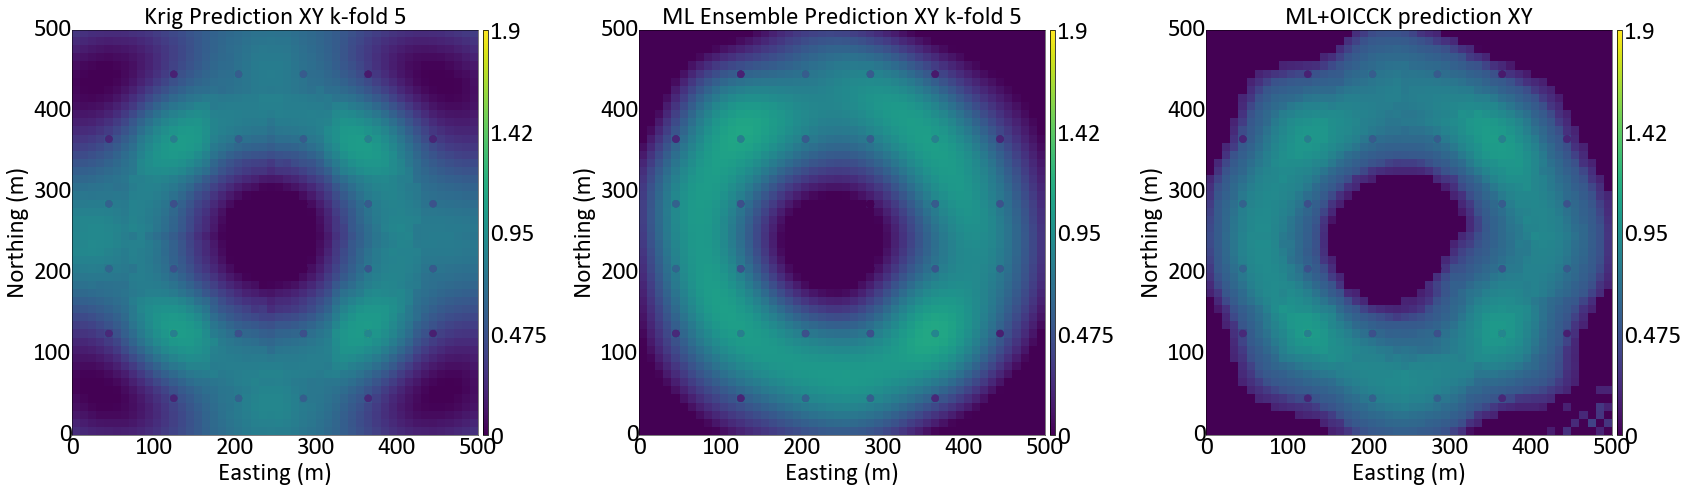

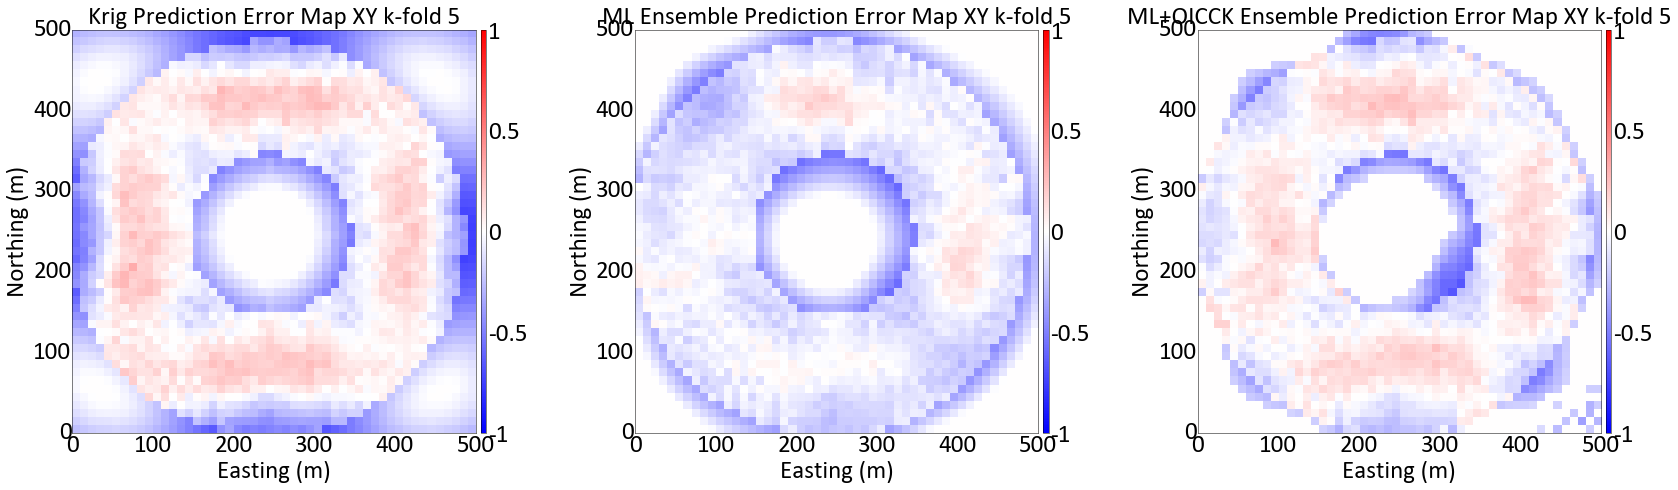

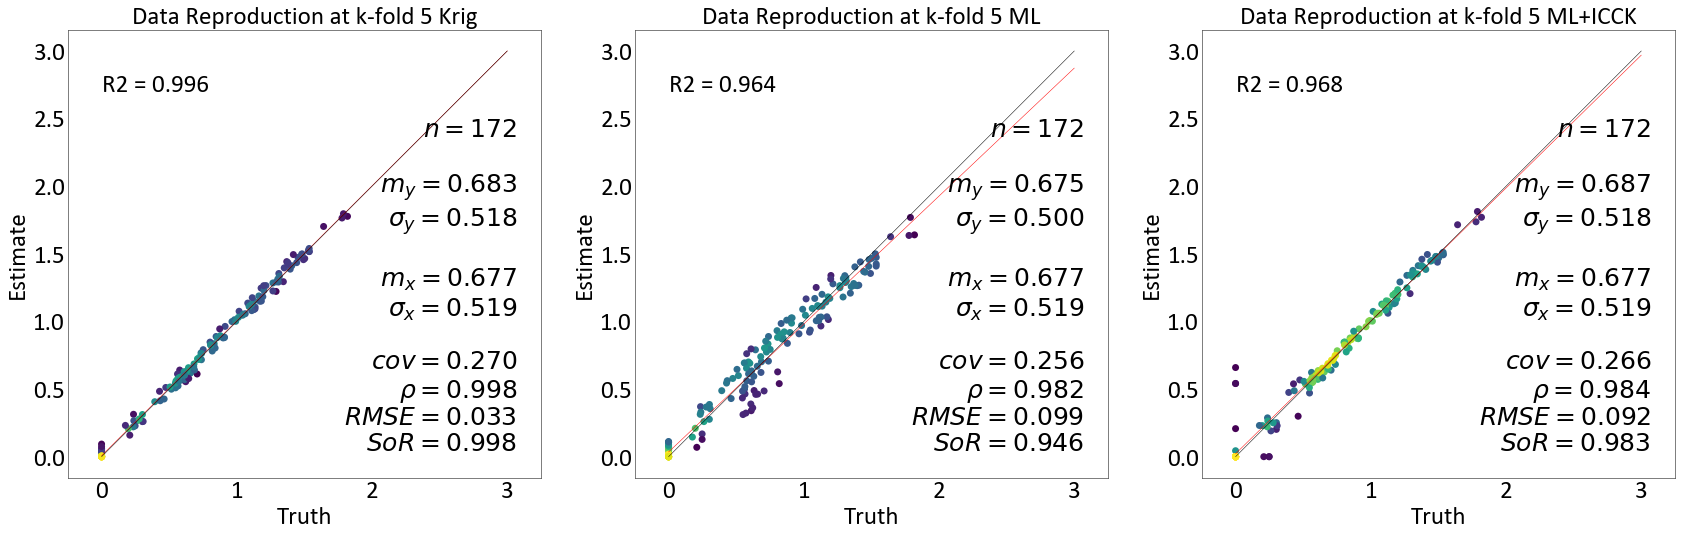

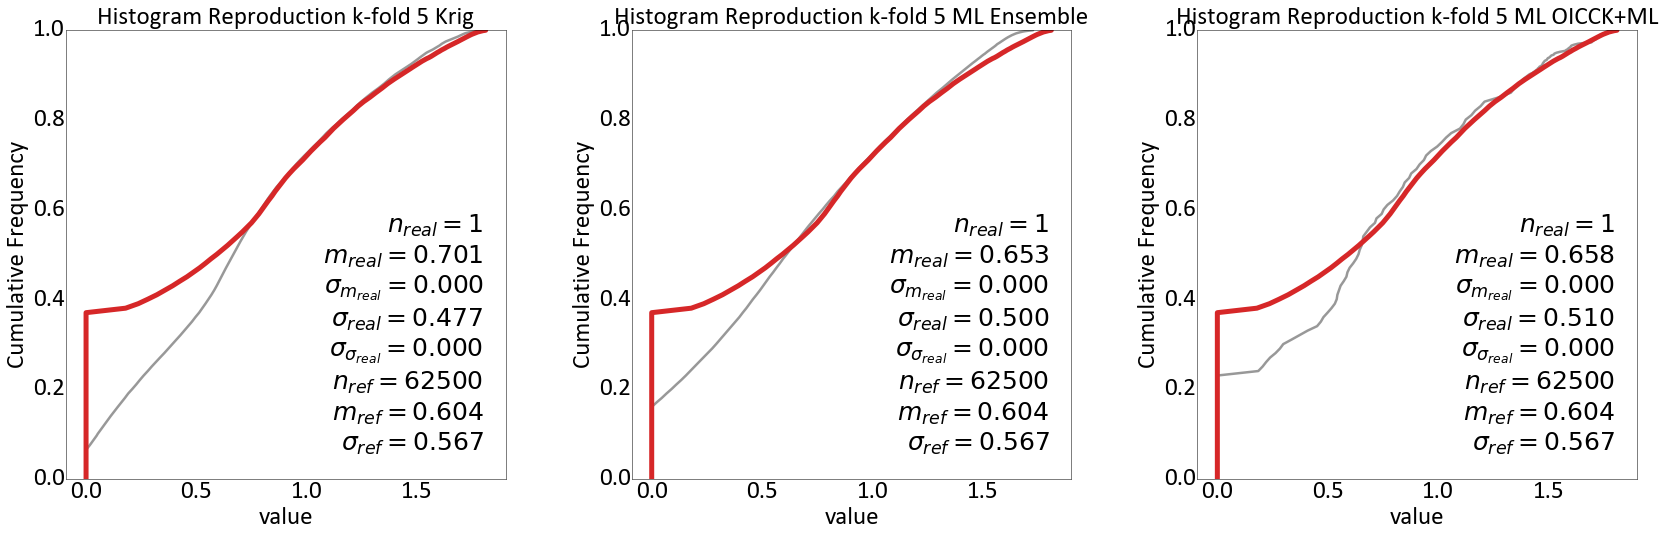

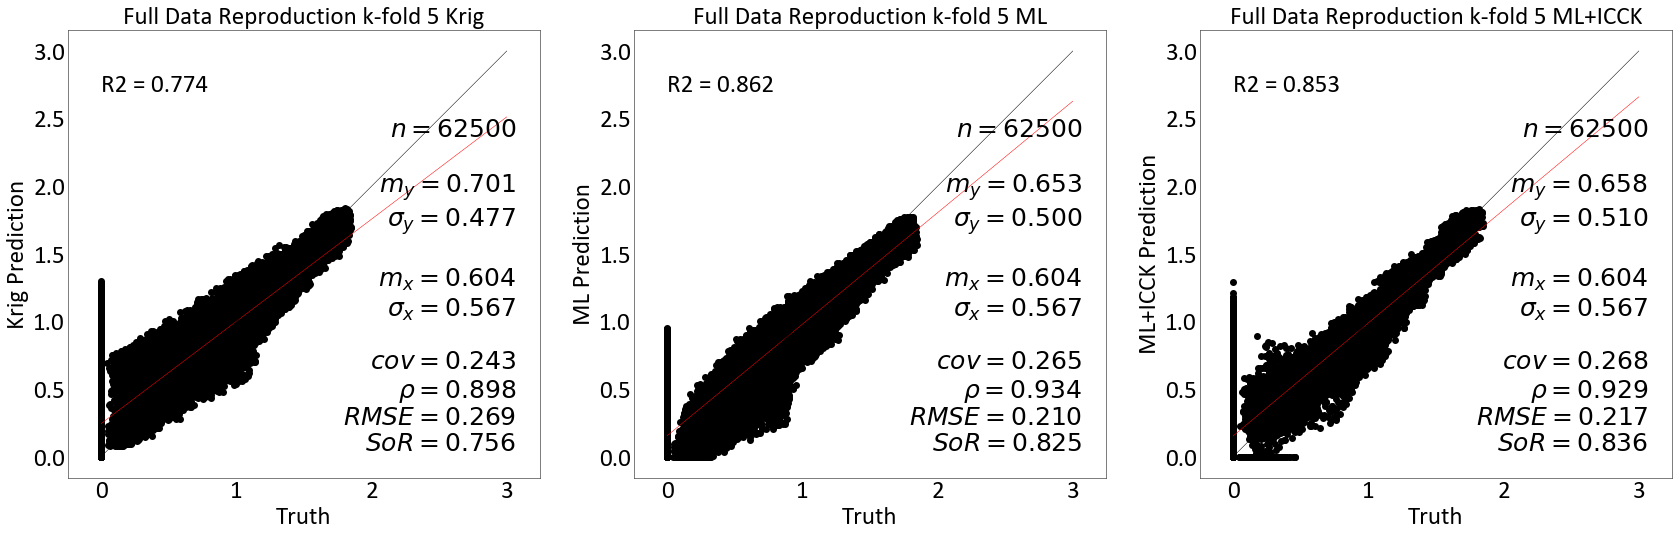

the r2 for krig k-fold 0.9958759828652927
the r2 for ML k-fold 0.9638705764562754
the r2 for krig full 0.7744676413059983
the r2 for ML full 0.8623286550191438
the average r2 of the krig is 0.9959607794657854
the average r2 of the ML is 0.9661943286578427
the average r2 of the ML_ICCK is 0.9851226593381804
the average rmse of the krig is 0.0328496660091088
the average rmse of the ML is 0.09513774844902041
the average rmse of the ML_icck is 0.06291489595902054
the average r2 of the full model for krig is 0.7770070907137606
the average r2 of the full model for ML is 0.8575080695687051
the average r2 of the full model for ML_icck is 0.8606931740090641
the average rmse of the full model for krig is 0.2676220409300402
the average rmse of the full model for ML is 0.21392989926549139
the average rmse of the full model for ML_icck is 0.21152541227997815


In [10]:
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
gs.set_style('pt25')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
vlim =(0,1.9)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
r2_krg_full = 0 
r2_ML_full = 0
mse_krg_full = 0
mse_ML_full = 0
mse_ML_icck = 0
r2_ML_icck = 0
r2_ML_icck_full = 0
mse_ML_icck_full = 0

r_2_Full_ML_List = []
r_2_kfold_ML_List = []
rmse_Full_ML_List = []
rmse_kfold_ML_List = []
mean_ML = []
sigma_ML = []

r_2_Full_krig_List = []
r_2_kfold_krig_List = []
rmse_Full_krig_List = []
rmse_kfold_krig_List = []
mean_krig = []
sigma_krig = []

r_2_Full_ML_icck_List = []
r_2_kfold_ML_icck_List = []
rmse_Full_ML_icck_List = []
rmse_kfold_ML_icck_List = []
mean_ML_icck = []
sigma_ML_icck = []

var = 'value'
sigma = 0
for fold in range(1,6):
    i += 1
    testfile = gs.DataFile('./data/data_test_{}.dat'.format(fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    pltdat_kt3dn.data['Estimate'][pltdat_kt3dn.data['Estimate'] < 0] = 0
    pltdat_ml = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
    pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = sigma))
    pltdat_ml[pltdat_ml < 0] = 0
    pltdat_ml_icck = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
    pltdat_ml_icck.data['Back Transform'][pltdat_ml_icck.data['Back Transform'] < 0] = 0
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')

    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'Krig Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'Krig Prediction XY k-fold {}'.format(fold))

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Ensemble Prediction XY k-fold {}'.format(fold))

    ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno)
    ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML+OICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/pix_xy_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))

    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_kt3dn.data['Estimate']),ax = axes[0],
                title = 'Krig Prediction Error Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr',griddef=griddef)
    #ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'krig prediction XY', orient = 'xz')

    ax3 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction Error Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
    
    ax4 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml_icck.data['Back Transform']),griddef=griddef,ax = axes[2],vlim=(-1,1),
                title = 'ML+OICCK Ensemble Prediction Error Map XY k-fold {}'.format(fold), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z',orient = 'xy',var = var , vlim=vlim,title = 'ML+OICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/error_xy_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values,xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} Krig'.format(fold),dens=True,ax = axes[0],vlim=(0,3))
    
    ax2.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values)),size=25)
    
    ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} ML'.format(fold),dens=True,ax = axes[1],vlim=(0,3))
    ax3.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml[idx])),size=25)
    
    ax4 = gs.scatxval(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values,xlabel='Truth', ylabel='Estimate',
         title = 'Data Reproduction at k-fold {} ML+ICCK'.format(fold),dens=True,ax = axes[2],vlim=(0,3))
    ax4.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values)),size=25)
    
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/kfold_datarep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],sgsimfl['value'],ax=axes[0],lw=5,title = 'Histogram Reproduction k-fold {} Krig'.format(fold),griddef=griddef,nreal=1)


    ax3 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[1],lw=5,title = 'Histogram Reproduction k-fold {} ML Ensemble'.format(fold),griddef=griddef,nreal=1)

    ax4 = gs.histpltsim(pltdat_ml_icck.data['Back Transform'],sgsimfl['value'],ax=axes[2],lw=5,griddef=griddef,nreal=1,
                       title = 'Histogram Reproduction k-fold {} ML OICCK+ML'.format(fold))

    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/histsim_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(sgsimfl['value'],pltdat_kt3dn.data['Estimate'],ax=axes[0],griddef=griddef,xlabel='Truth',vlim=(0,3),
                      title = 'Full Data Reproduction k-fold {} Krig'.format(fold), ylabel ='Krig Prediction',desn=True)
    ax2.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])),size=25)

    ax3 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[1],griddef=griddef,xlabel='Truth',ylabel='ML Prediction',vlim=(0,3),
                      title = 'Full Data Reproduction k-fold {} ML'.format(fold),label ='ML Prediction',desn=True)
    ax3.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml)),size=25)
    
    ax4 = gs.scatxval(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'],ax=axes[2], title = 'Full Data Reproduction k-fold {} ML+ICCK'.format(fold),
                      griddef=griddef,xlabel='Truth', ylabel ='ML+ICCK Prediction',vlim =(0,3))
    ax4.text(0,2.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])),size=25)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/full_datarep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    print('the r2 for krig k-fold {}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
    print('the r2 for krig full {}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))
    
    r_2_Full_ML_List.append(r2_score(sgsimfl['value'],pltdat_ml))
    r_2_kfold_ML_List.append(r2_score(testfile.data[var],pltdat_ml[idx]))
    r_2_Full_ML_icck_List.append(r2_score(sgsimfl['value'],pltdat_ml_icck.data['Back Transform']))
    r_2_kfold_ML_icck_List.append(r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx]))
    r_2_Full_krig_List.append(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate']))
    r_2_kfold_krig_List.append(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx]))

    rmse_Full_ML_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_ml)))
    rmse_kfold_ML_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_ml[idx])))
    rmse_Full_ML_icck_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])))
    rmse_kfold_ML_icck_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])))
    rmse_Full_krig_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    rmse_kfold_krig_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    
    mean_ML.append(np.mean(pltdat_ml))
    sigma_ML.append(np.std(pltdat_ml))
    mean_ML_icck.append(np.mean(pltdat_ml_icck.data['Back Transform']))
    sigma_ML_icck.append(np.std(pltdat_ml_icck.data['Back Transform']))
    mean_krig.append(np.mean(pltdat_kt3dn.data['Estimate']))
    sigma_krig.append(np.std(pltdat_kt3dn.data['Estimate']))
    
    
    
    mse_krg = mse_krg + mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    mse_ML = mse_ML + mean_squared_error(testfile.data[var],pltdat_ml[idx])
    mse_ML_icck = mse_ML_icck + mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg = r2_krg + r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    r2_ML = r2_ML + r2_score(testfile.data[var],pltdat_ml[idx])
    r2_ML_icck = r2_ML_icck + r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg_full = r2_krg_full + r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    r2_ML_full = r2_ML_full + r2_score(sgsimfl['value'],pltdat_ml)
    r2_ML_icck_full = r2_ML_icck_full + r2_score(sgsimfl['value'].values,pltdat_ml_icck.data['Back Transform'].values)
    mse_krg_full = mse_krg_full + mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    mse_ML_full = mse_ML_full + mean_squared_error(sgsimfl['value'],pltdat_ml)
    mse_ML_icck_full = mse_ML_icck_full + mean_squared_error(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])
    
    gs.write_gslib(pd.DataFrame(pltdat_ml),'./predictions/ML_pred_{}.dat'.format(fold))
    
print('the average r2 of the krig is {}'.format(r2_krg/i))
print('the average r2 of the ML is {}'.format(r2_ML/i))
print('the average r2 of the ML_ICCK is {}'.format(r2_ML_icck/i))
print('the average rmse of the krig is {}'.format(np.sqrt(mse_krg/i)))
print('the average rmse of the ML is {}'.format(np.sqrt(mse_ML/i)))
print('the average rmse of the ML_icck is {}'.format(np.sqrt(mse_ML_icck/i)))
print('the average r2 of the full model for krig is {}'.format(r2_krg_full/i))
print('the average r2 of the full model for ML is {}'.format(r2_ML_full/i))
print('the average r2 of the full model for ML_icck is {}'.format(r2_ML_icck_full/i))
print('the average rmse of the full model for krig is {}'.format(np.sqrt(mse_krg_full/i)))
print('the average rmse of the full model for ML is {}'.format(np.sqrt(mse_ML_full/i)))
print('the average rmse of the full model for ML_icck is {}'.format(np.sqrt(mse_ML_icck_full/i)))

In [11]:
num_folds = [1,2,3,4,5]
ML_Stats = np.vstack((num_folds,rmse_kfold_ML_List,r_2_kfold_ML_List,rmse_Full_ML_List,r_2_Full_ML_List,sigma_ML,mean_ML)).T
ML_icck_Stats = np.vstack((num_folds,rmse_kfold_ML_icck_List,r_2_kfold_ML_icck_List,rmse_Full_ML_icck_List,r_2_Full_ML_icck_List,sigma_ML_icck,mean_ML_icck)).T
Krig_Stats = np.vstack((num_folds,rmse_kfold_krig_List,r_2_kfold_krig_List,rmse_Full_krig_List,r_2_Full_krig_List,sigma_krig,mean_krig)).T


In [12]:
np.savetxt('ML_stats.csv', ML_Stats, delimiter = ',')
np.savetxt('Krig_stats.csv', Krig_Stats, delimiter = ',')
np.savetxt('ML_icck_stats.csv', ML_icck_Stats, delimiter = ',')

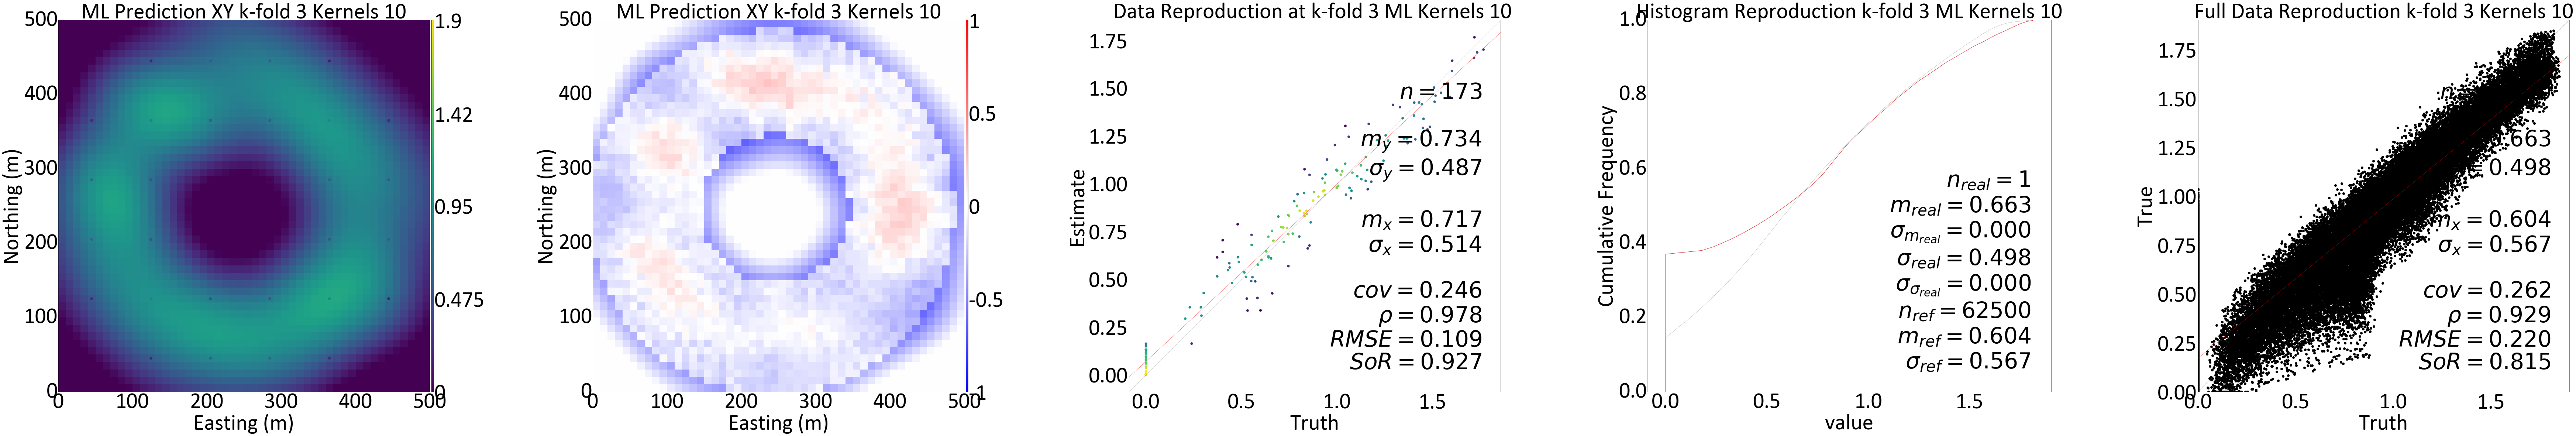

the r2 for ML k-fold 0.9552921311373666
the r2 for ML full 0.8491104682954415


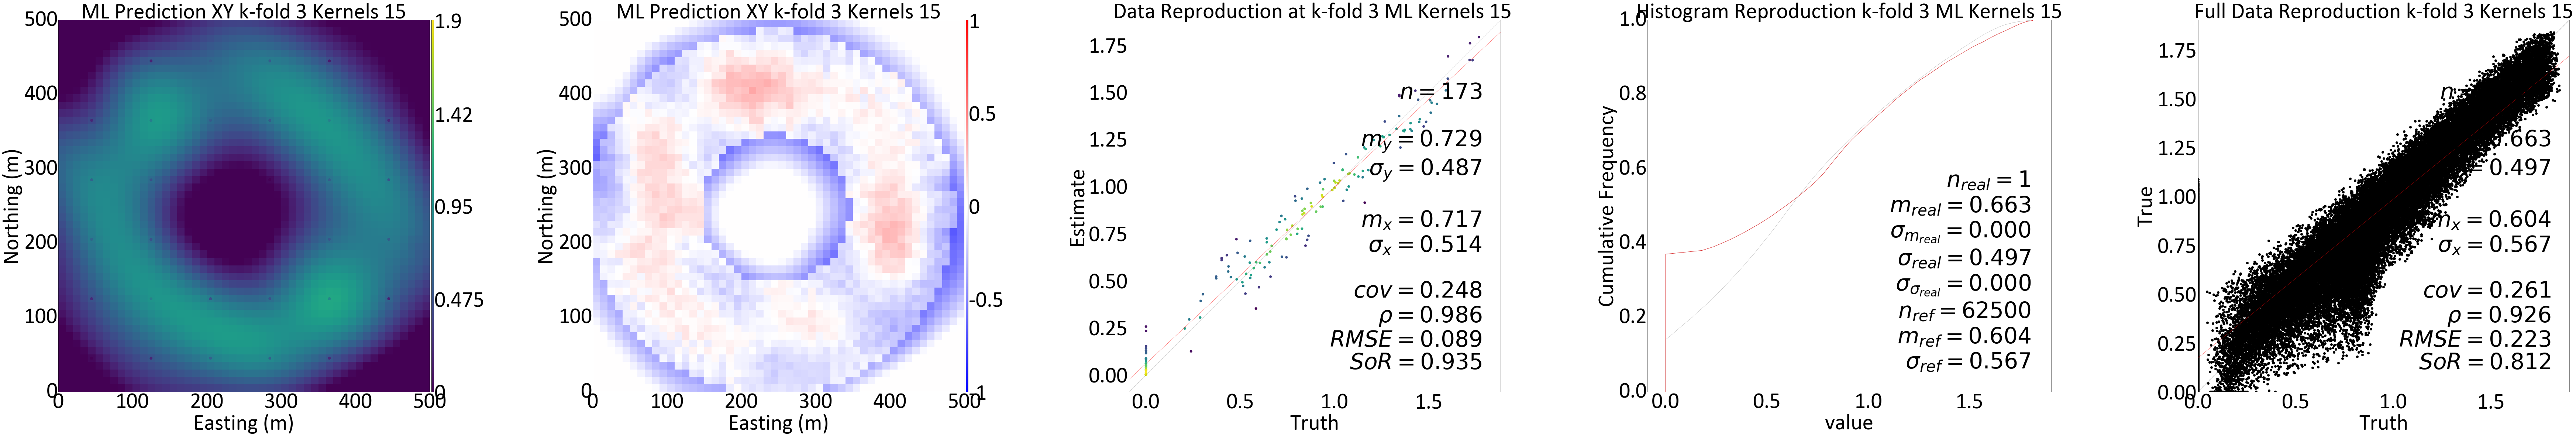

the r2 for ML k-fold 0.9697219864851094
the r2 for ML full 0.8447182819170468


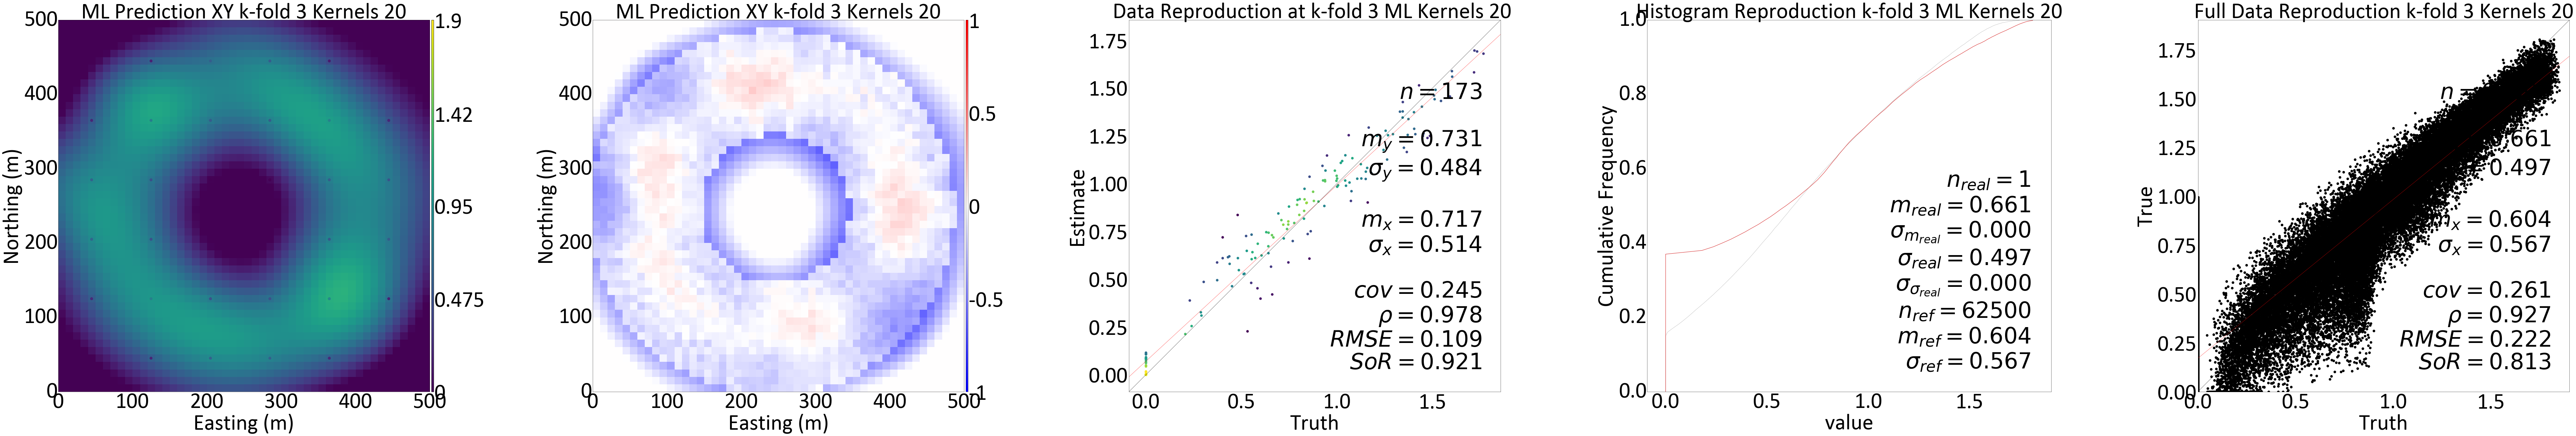

the r2 for ML k-fold 0.9549578089324312
the r2 for ML full 0.8459488023644962


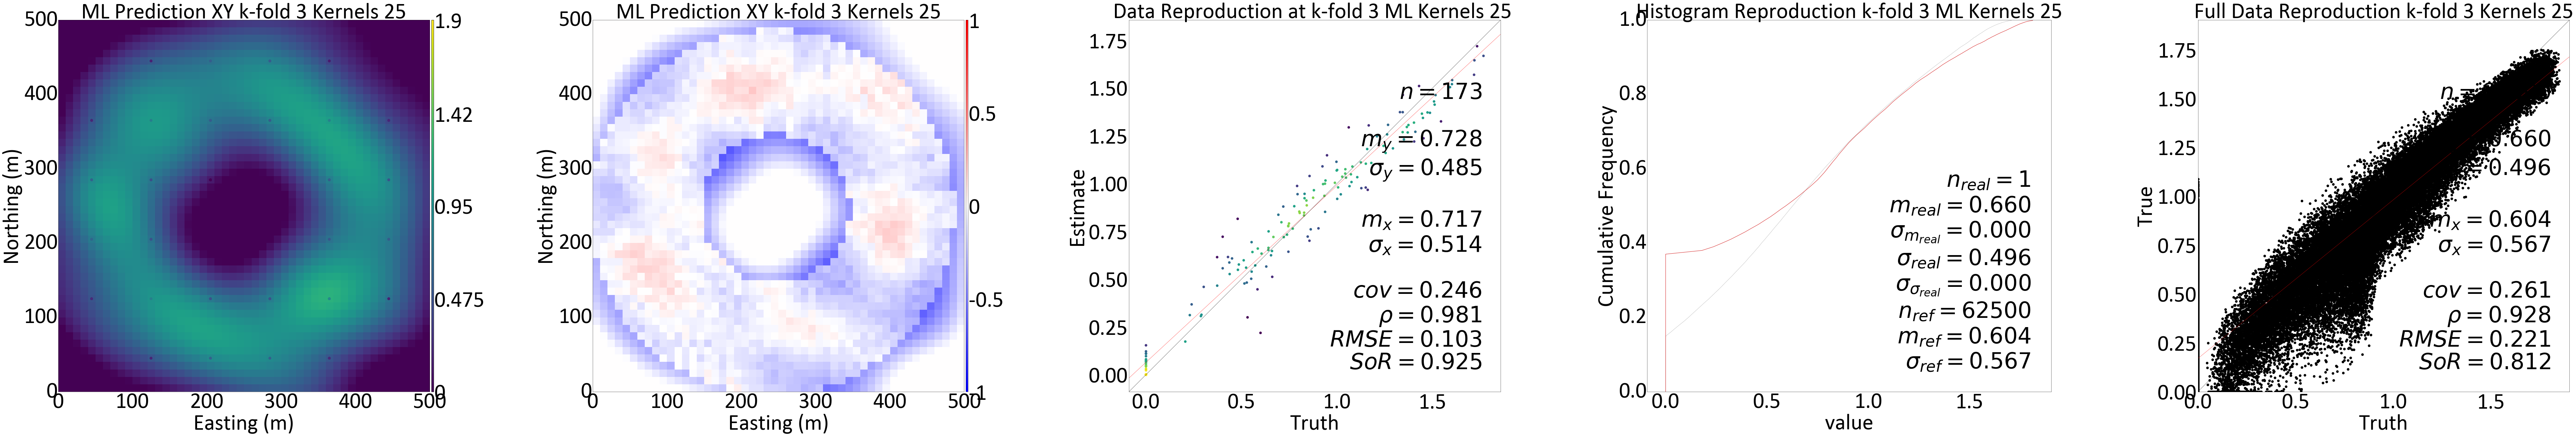

the r2 for ML k-fold 0.9596989224079612
the r2 for ML full 0.8480333870788294


In [13]:
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
test_nodes = [10,15,20,25]
gs.set_style('pt60')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
vlim =(0,1.9)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
r2_krg_full = 0 
r2_ML_full = 0
mse_krg_full = 0
mse_ML_full = 0
mse_ML_icck = 0
r2_ML_icck = 0
r2_ML_icck_full = 0
mse_ML_icck_full = 0

var = 'value'
sigma = 0
for nodes in test_nodes:
    i += 1
    testfile = gs.DataFile('./data/data_test_3.dat'.format(nodes))

    pltdat_ml = gs.DataFile('./predictions/real_{}_3.dat'.format(nodes),griddef=griddef)
    
    pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = 0))
    pltdat_ml[pltdat_ml < 0] = 0
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    f, axes = plt.subplots(1, 5, figsize=(100, 18))
    
    ax1 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[0],
                title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes),vlim=vlim, sliceno=slinceno)
    ax1 = gs.locmap(datasamplefl,griddef=griddef, ax=ax1,sliceno=slinceno,
                    x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes))
    
    ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
                title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    
    ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
    title = 'Data Reproduction at k-fold 3 ML Kernels {} '.format(nodes),dens=True,ax = axes[2])
    
    ax4 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[3],
                        title = 'Histogram Reproduction k-fold 3 ML Kernels {}'.format(nodes),griddef=griddef,nreal=1)
    
    ax5 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[4],griddef=griddef,xlabel='Truth',
                  title = 'Full Data Reproduction k-fold 3 Kernels {}'.format(nodes),label ='ML Prediction',vlim =vlim,desn=True)
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    axes[4].set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/nodes_comp_ERBFN_{}_{}.png'.format(plt_extent,nodes))
    plt.show()
    
    print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
    print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))

In [10]:
# dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
#                        readfl=True)
# f, axes = plt.subplots(2, 2, figsize=(16, 16))
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[0,0], griddef = griddef,  title = 'Simulated Truth XY')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[0,1], griddef = griddef,orient='xy', title = 'Location Map of Drill Holes XY')
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[1,0], griddef = griddef,orient='xz', title = 'Simulated Truth XZ')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[1,1], griddef = griddef,orient='xz', title = 'Location Map of Drill Holes XZ')
# plt.tight_layout()
# plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Data_01.png')
# plt.show()

In [11]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat        -file with lithology information
0   7                        -   lithology column (0=not used), code
{datafl}             -file with data
1   {col}                -   number of variables, column numbers
-1.0e21     1.0e21    -   trimming limits
./vargs/varsim_reals_{p_type}_{fold}.out      -output file for variograms of realizations
./vargs/varsim_avg_{p_type}_{fold}.out        -output file for average variogram
{griddef}
1                  -number of realizations
3  100                 -number of directions, number of lags
1  0  0              -ixd(1),iyd(1),izd(1)
0  1  0              -ixd(2),iyd(2),izd(2)
0  0  1              -ixd(2),iyd(2),izd(2)
0                     -standardize sill? (0=no, 1=yes)
1                     -number of variograms
1   1   1             -tail variable, head variable, variogram type
"""

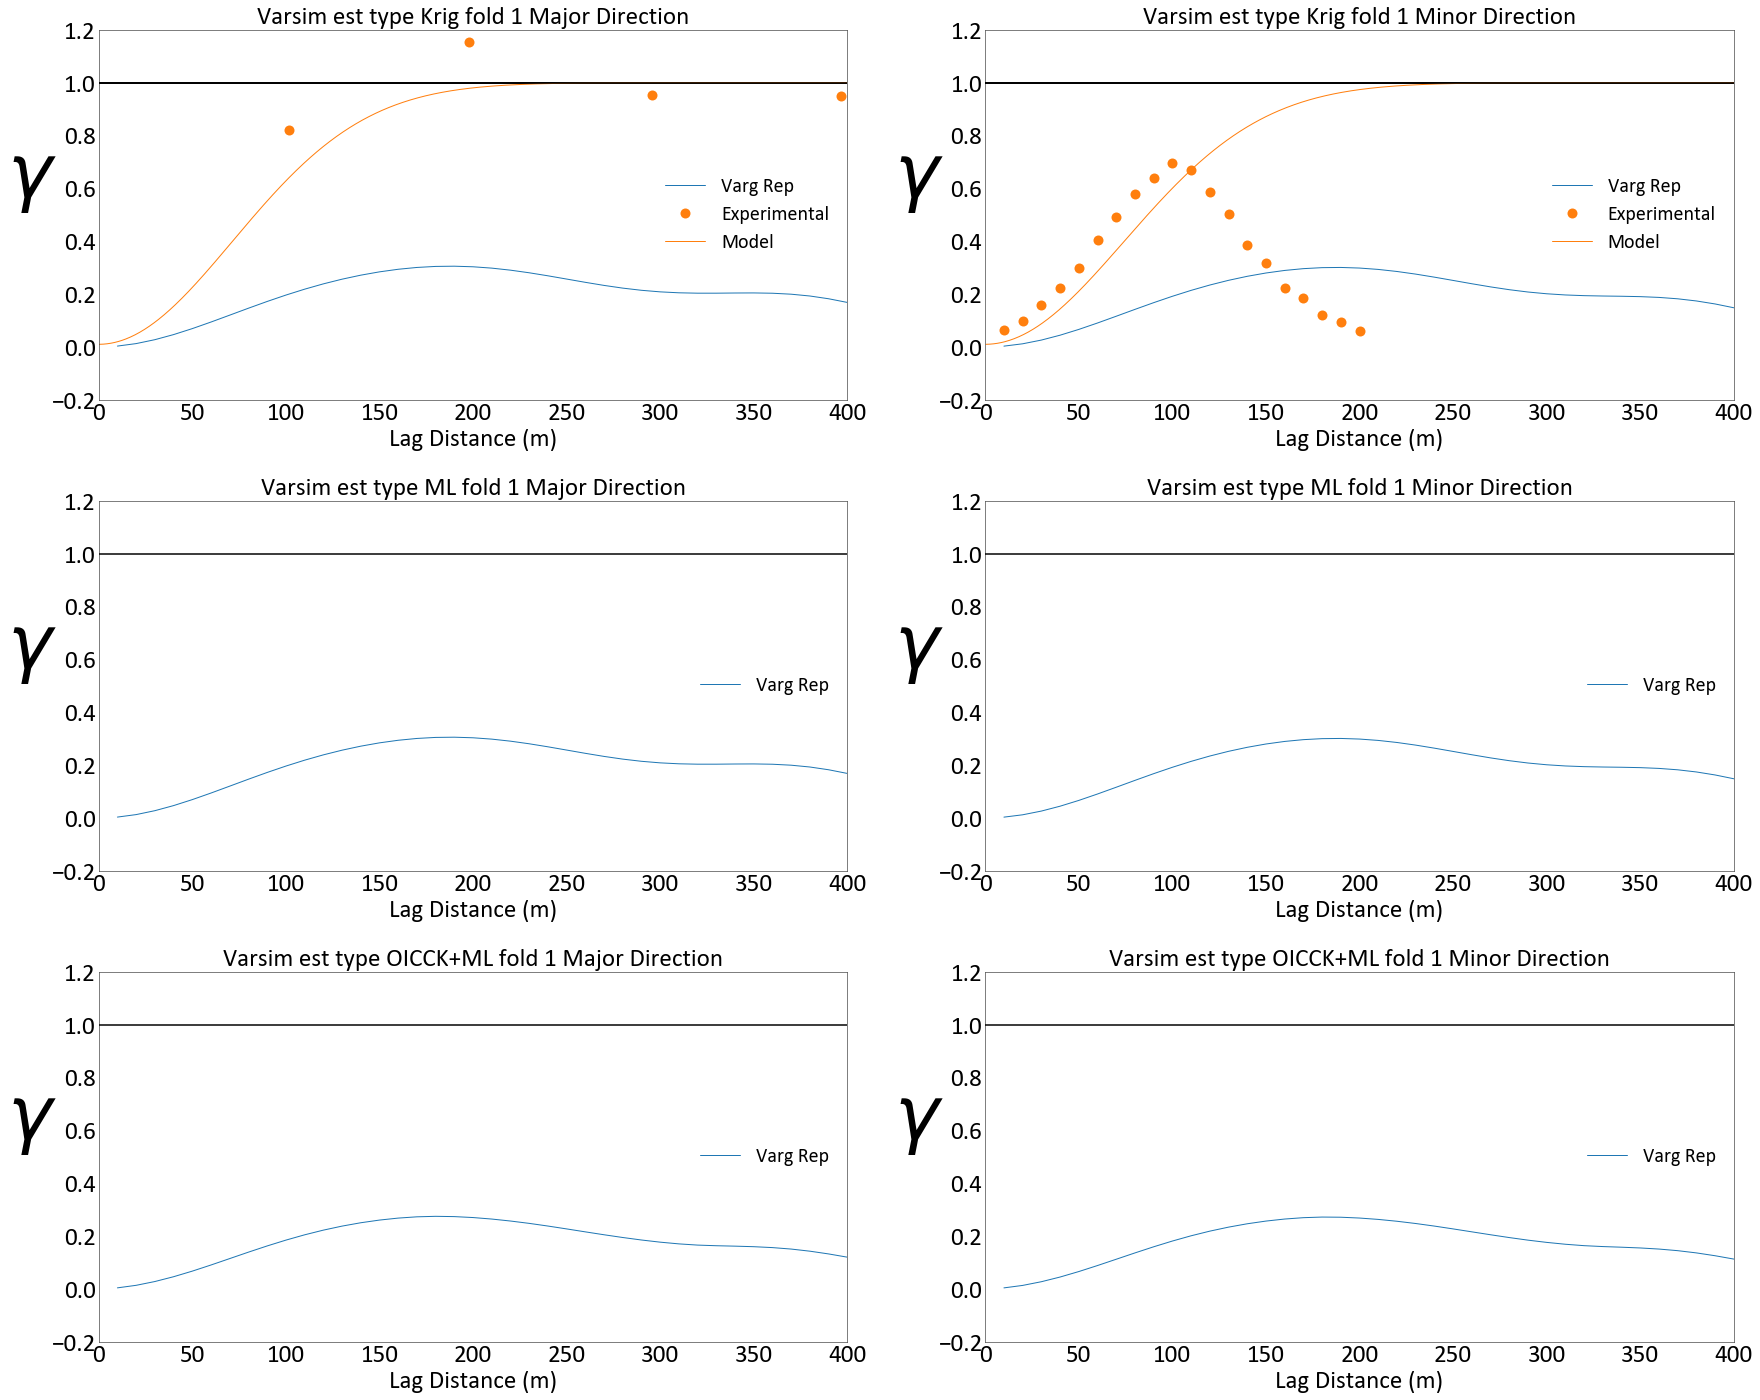

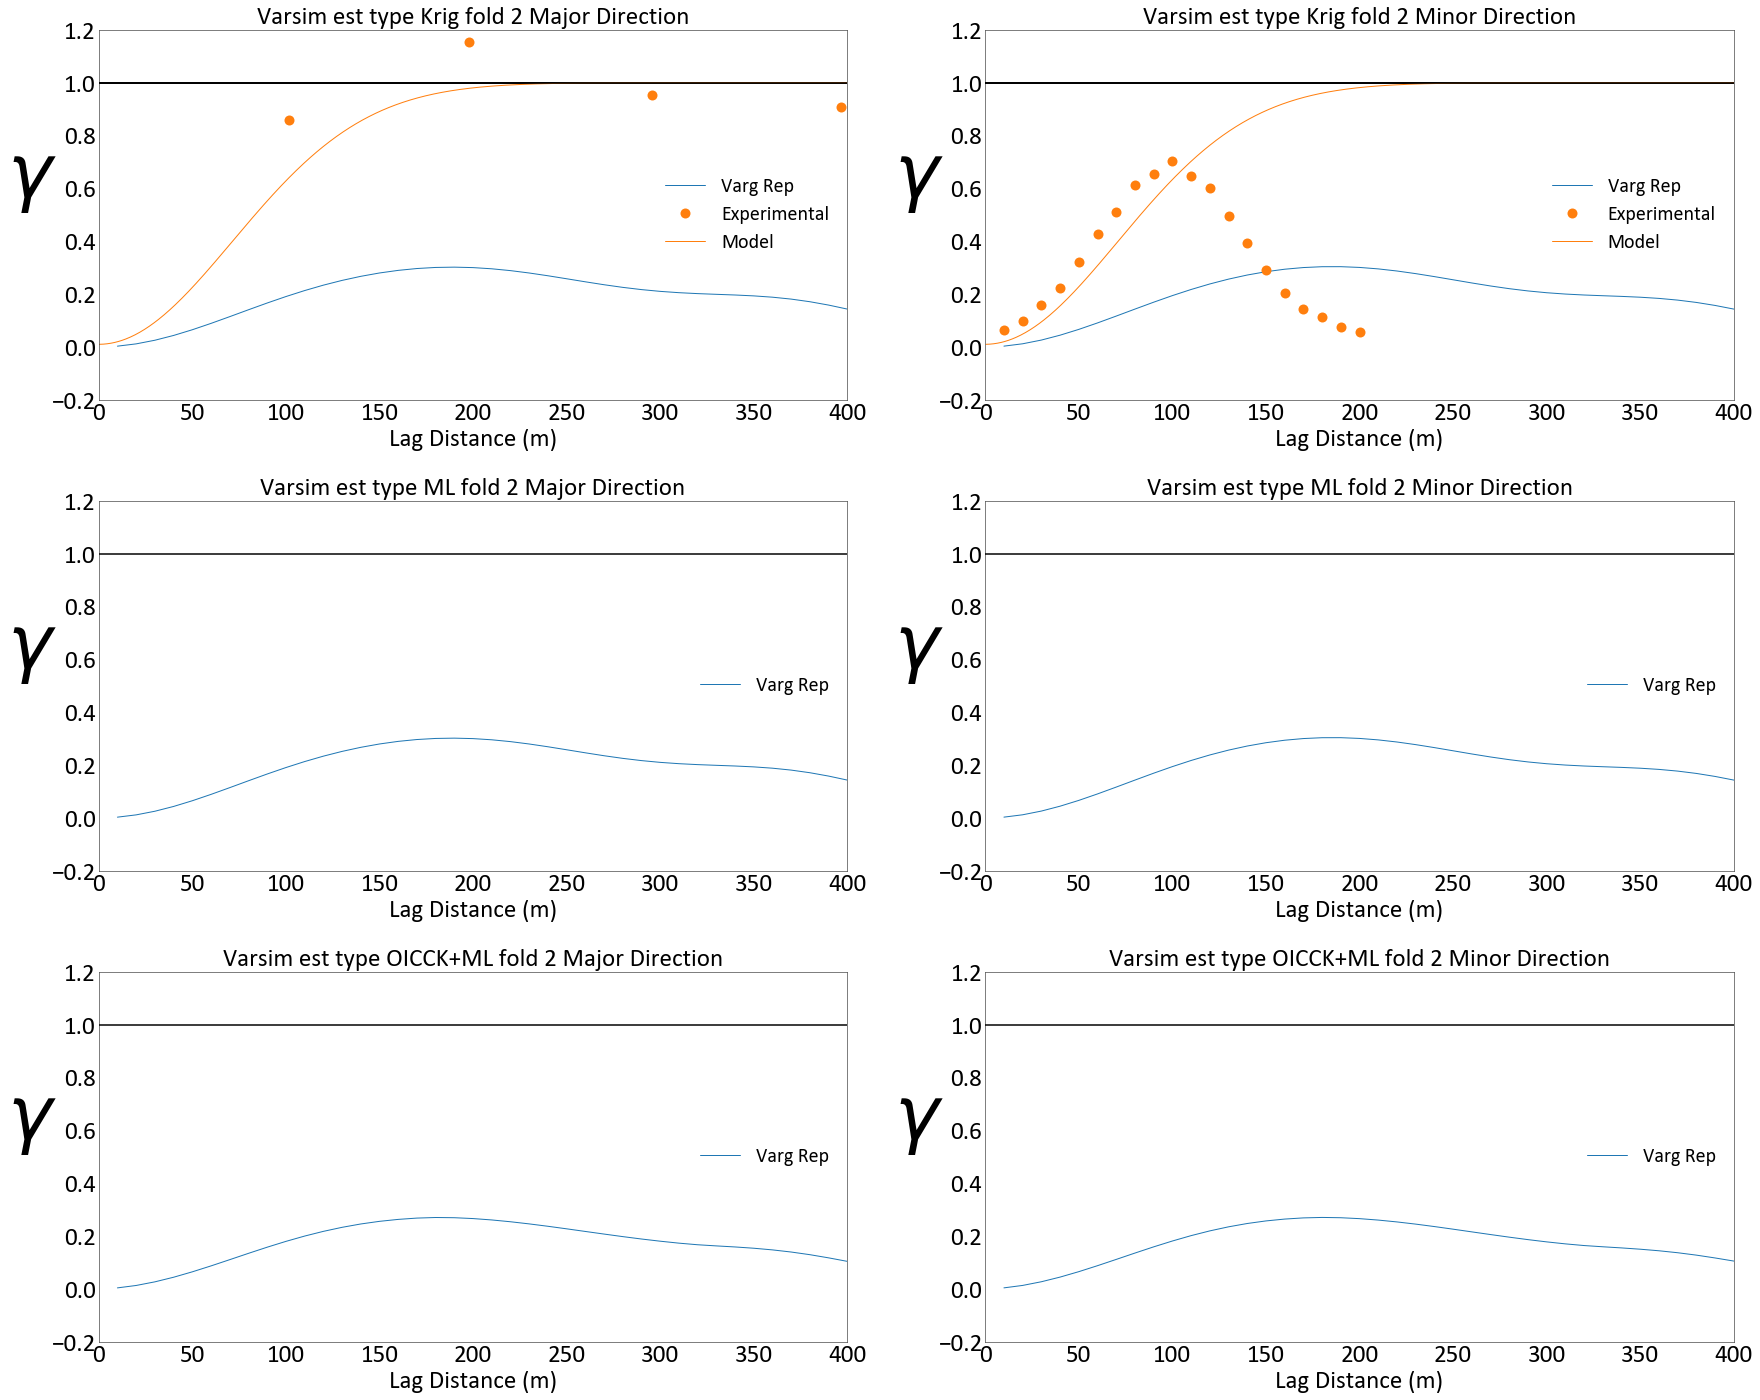

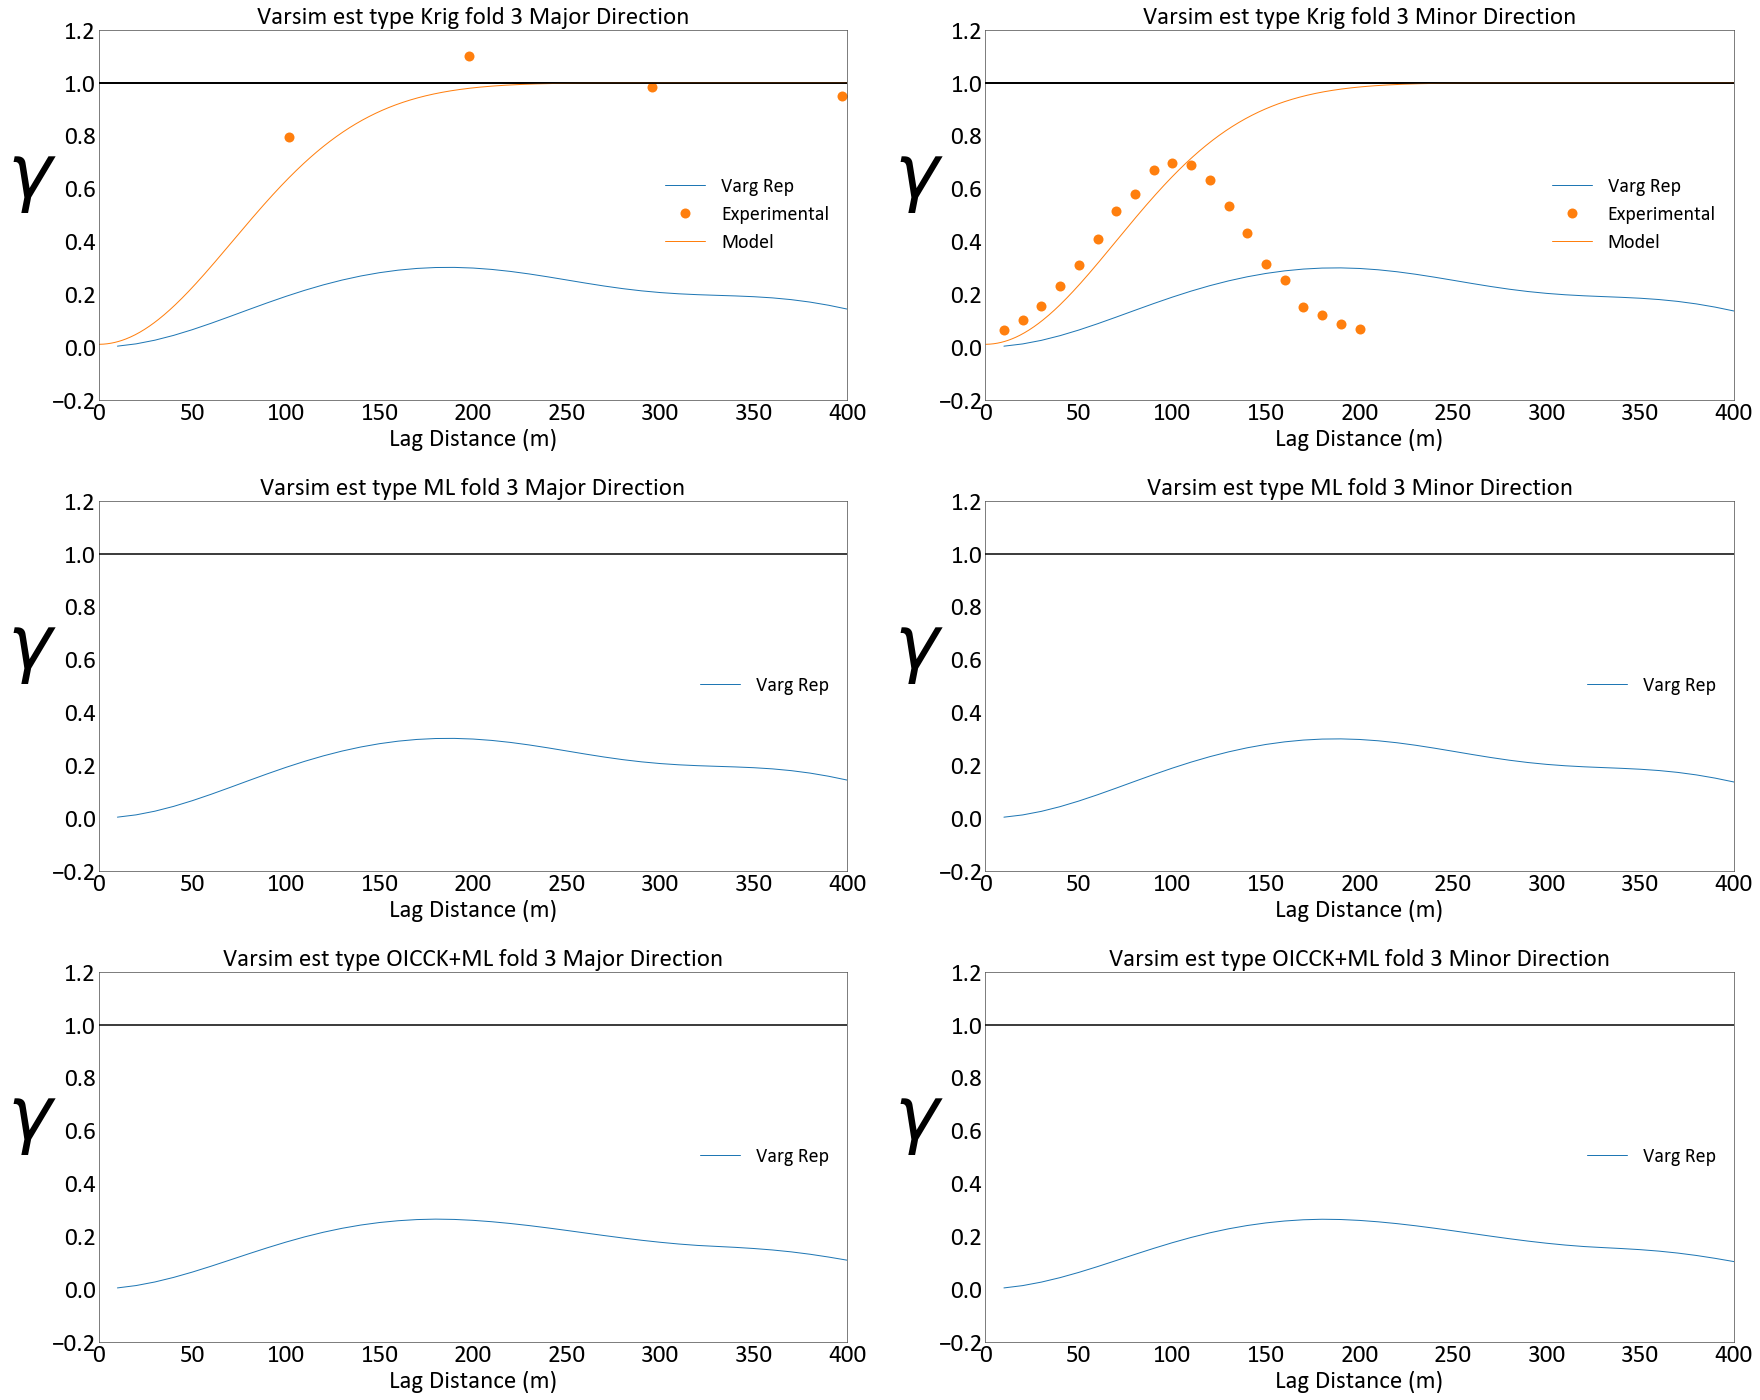

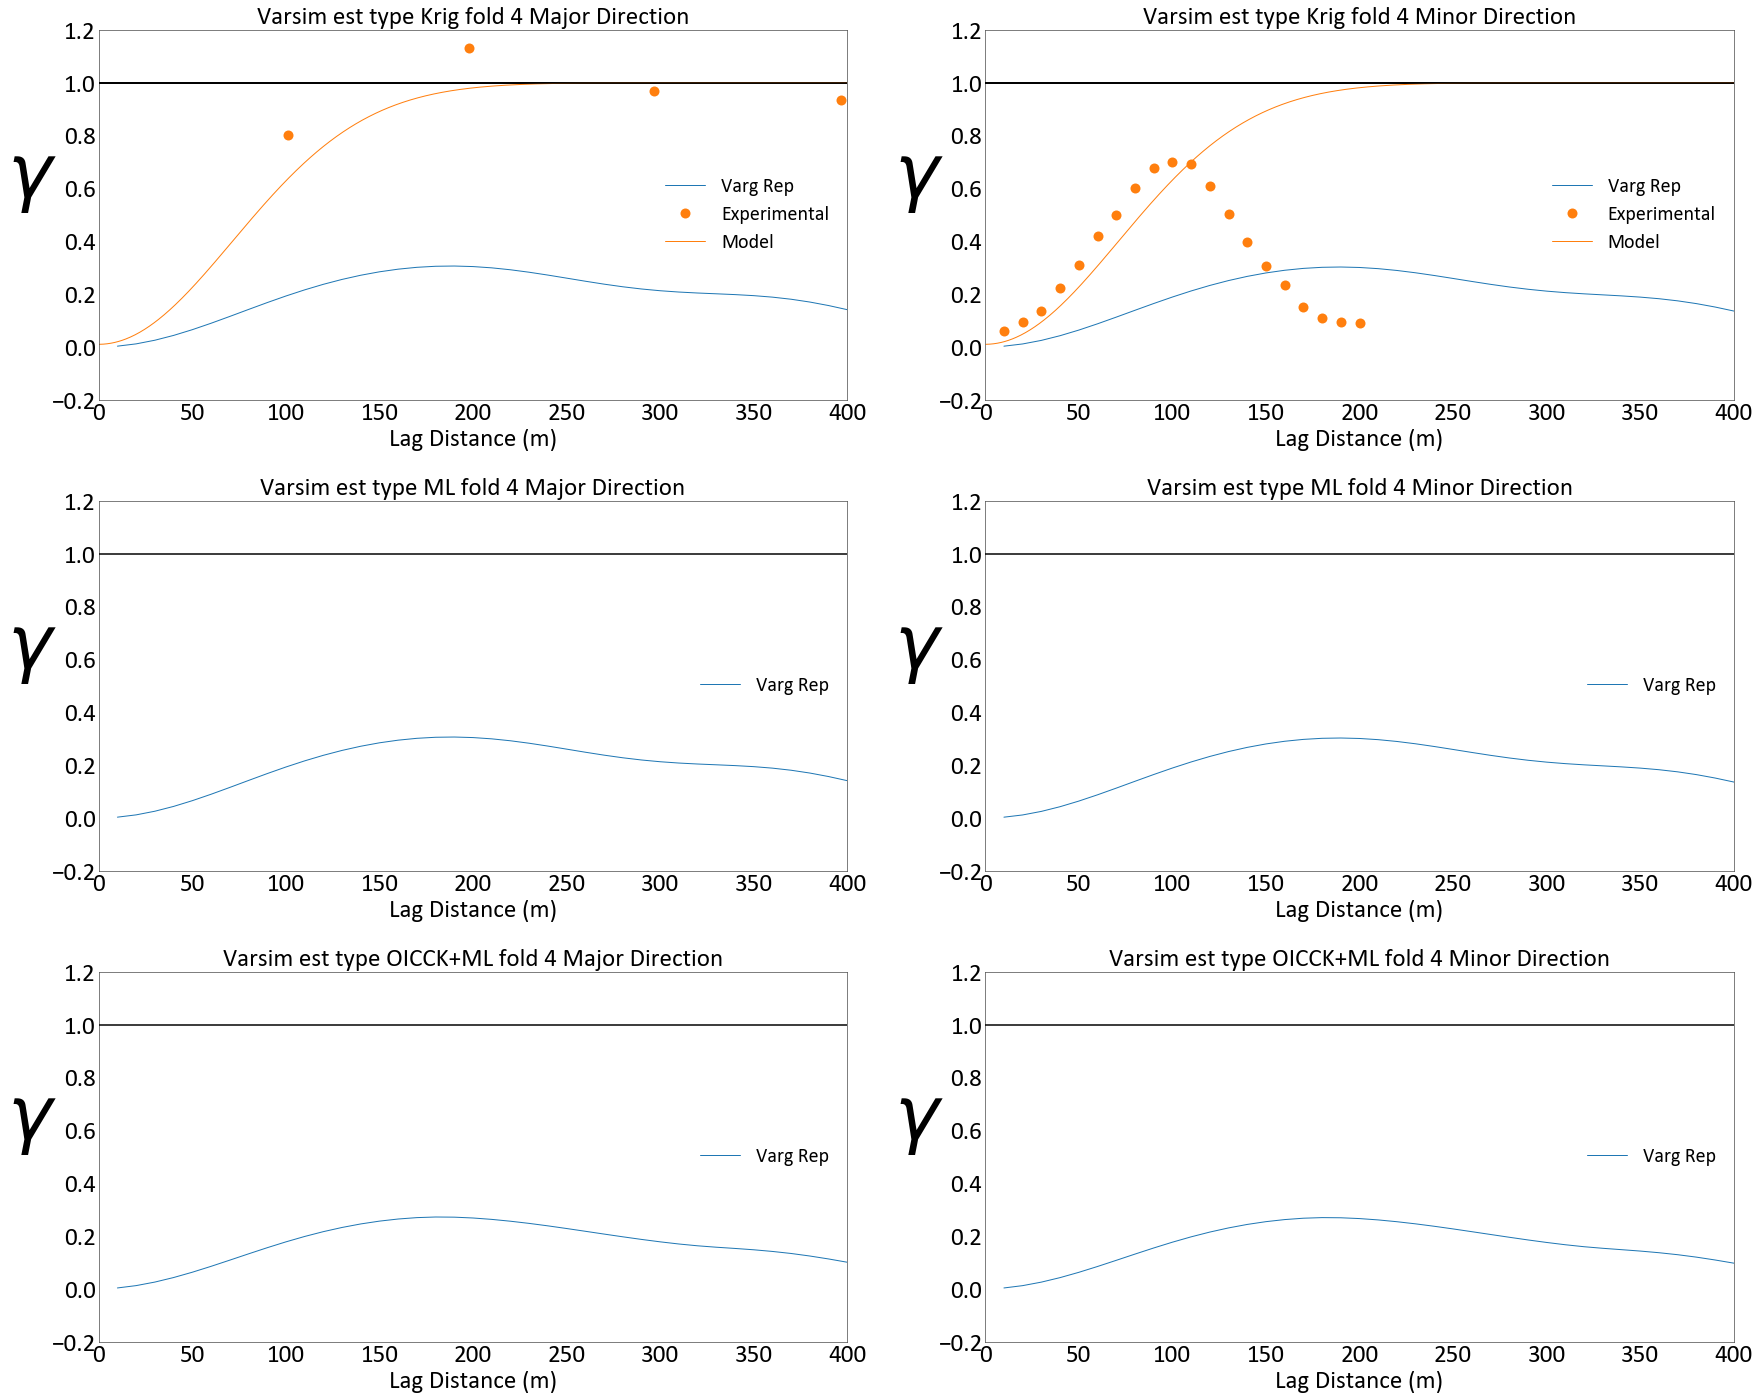

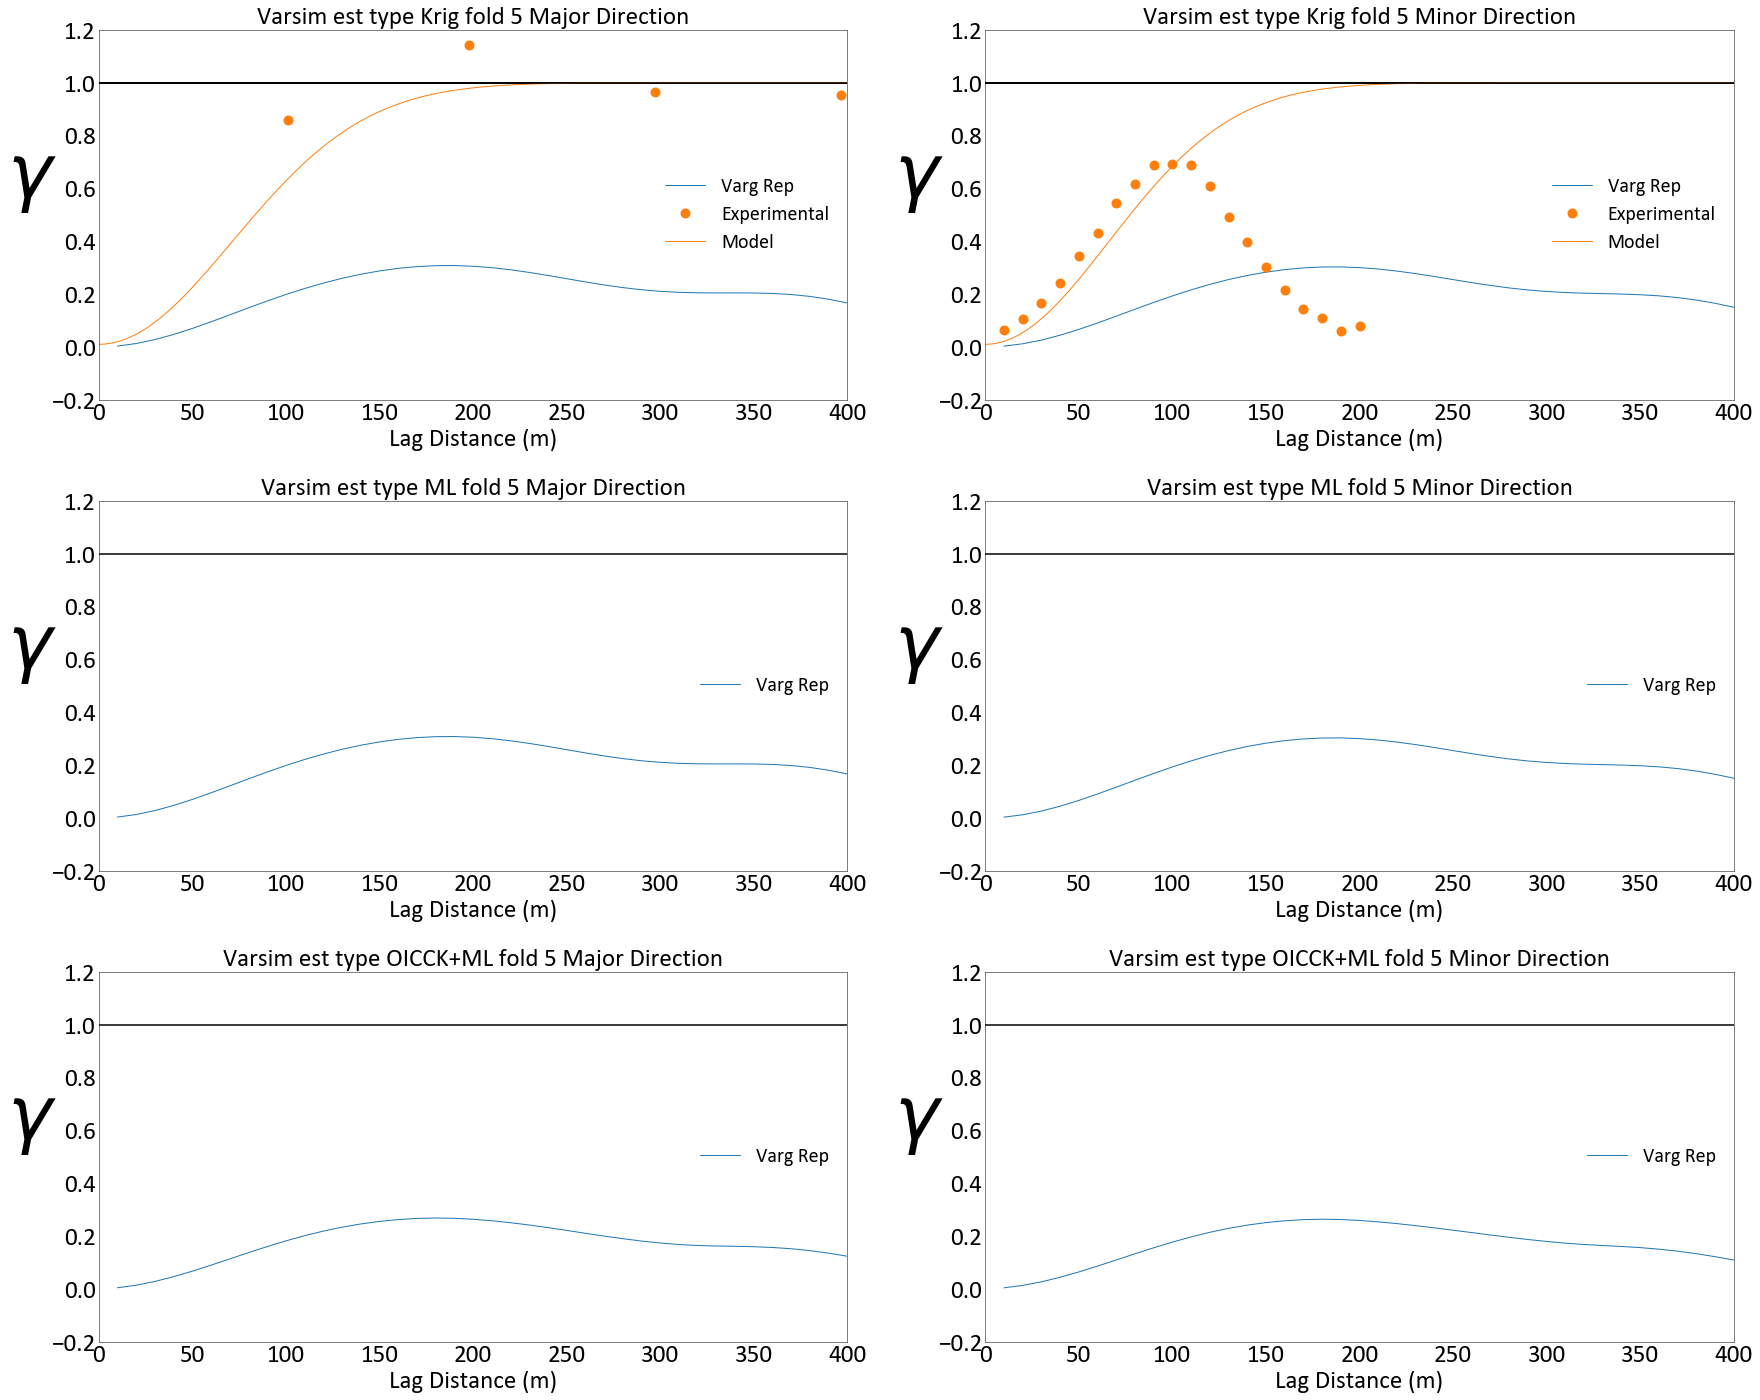

In [14]:
gs.set_style('pt25')
ylim = (-.2,1.2)
for fold in range(1,6):
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    f, axes = plt.subplots(3, 2, figsize=(25, 20))
    for p_type in list(['Krig','ML','OICCK+ML']):
        if p_type == 'Krig':
            predfile = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
            col = 1
        if p_type == 'OICCK+ML':
            predfile = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
            col = 3
        else:
            predfile = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
            col = 1
            
        varsim.run(varsimparstr.format(datafl = predfile,
                                       p_type = p_type,
                                       fold = fold,
                                       col = col,
                                       griddef = griddef),quiet=True,liveoutput=False)
        varsimfl =  gs.DataFile('./vargs/varsim_reals_{}_{}.out'.format(p_type,fold))
    

        if p_type == 'Krig':
            ax = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax =axes[0,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax.legend(loc=7,prop={'size': 20})
            ax.set_xlim(0, 400)
            
            ax2 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax =axes[0,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax2.legend(loc=7,prop={'size': 20})
            ax2.set_xlim(0, 400)
            
#             ax3 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax =axes[0,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
#             ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
#             ax3.legend(loc=7,prop={'size': 20})
#             ax3.set_xlim(0, 400)
            
        if p_type == 'ML':
            ax4 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[1,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax4.legend(loc=7,prop={'size': 20})
            ax4.set_xlim(0, 400)
            ax5 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[1,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax5.legend(loc=7,prop={'size': 20})
            ax5.set_xlim(0, 400)
#             ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
#             #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
#             ax6.legend(loc=7,prop={'size': 20})
#             ax6.set_xlim(0, 400)

        if p_type == 'OICCK+ML':
            ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[2,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax6.legend(loc=7,prop={'size': 20})
            ax6.set_xlim(0, 400)
            ax7 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[2,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax7.legend(loc=7,prop={'size': 20})
            ax7.set_xlim(0, 400)
#             ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
#             #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
#             ax6.legend(loc=7,prop={'size': 20})
#             ax6.set_xlim(0, 400)


    plt.tight_layout()    
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/varg_rep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()


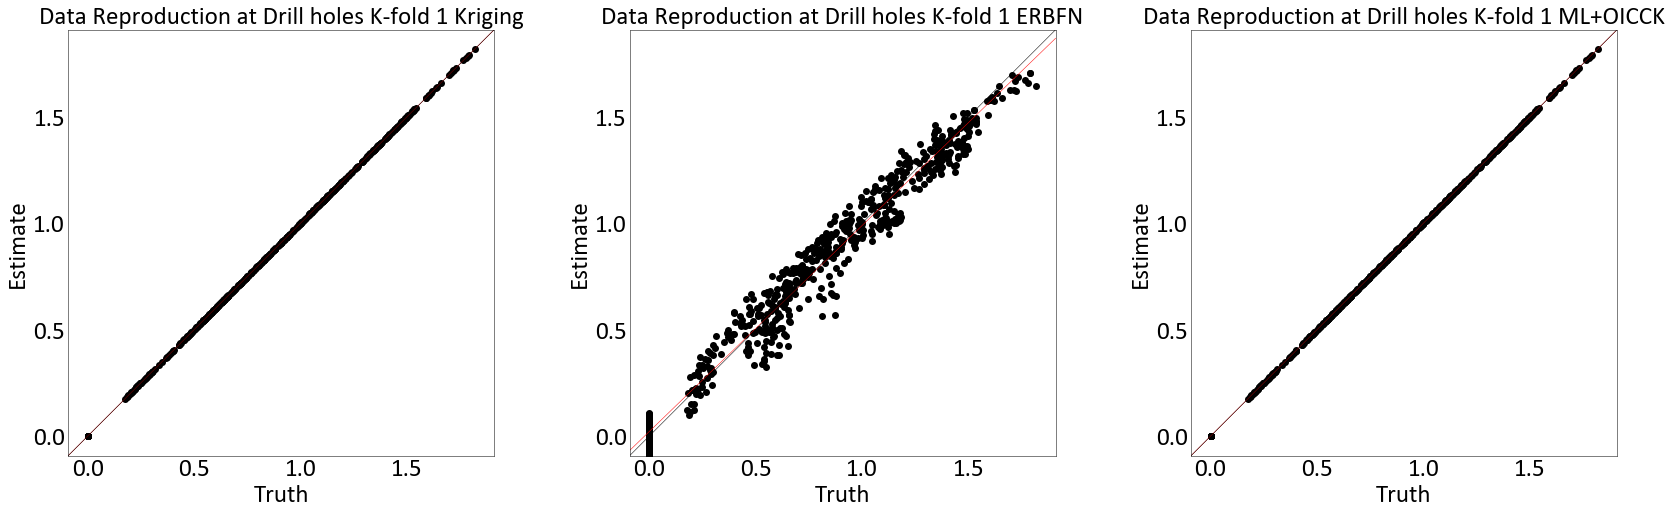

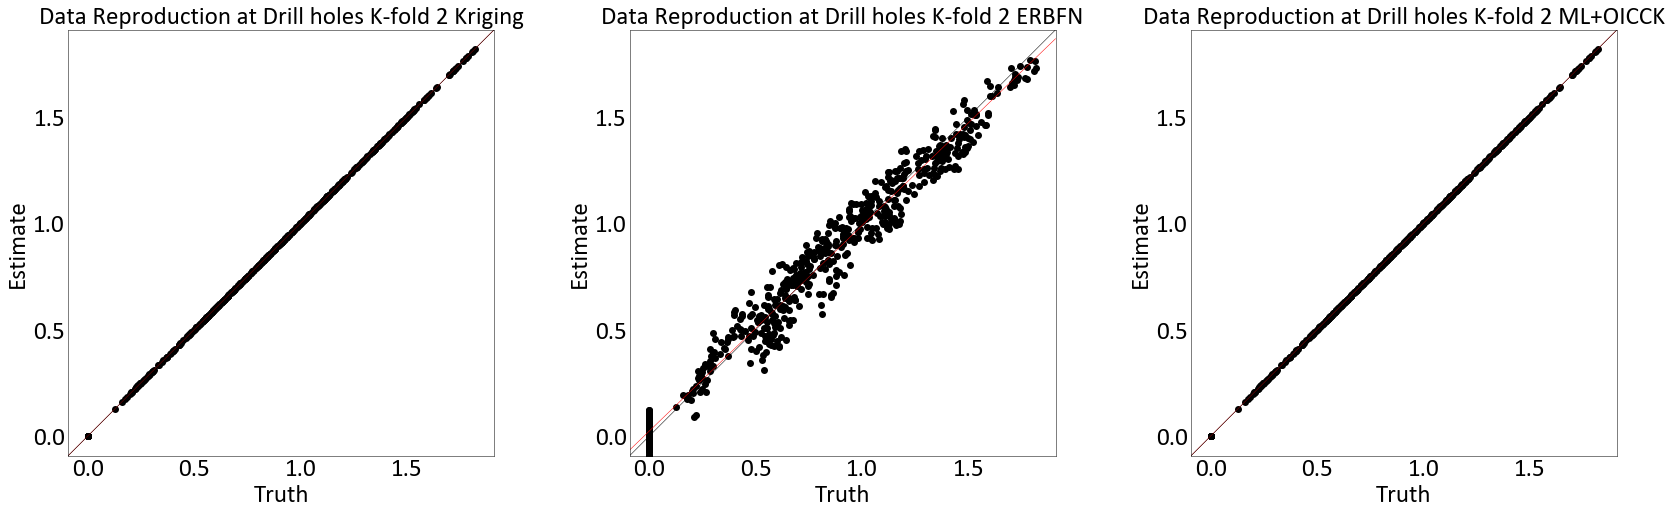

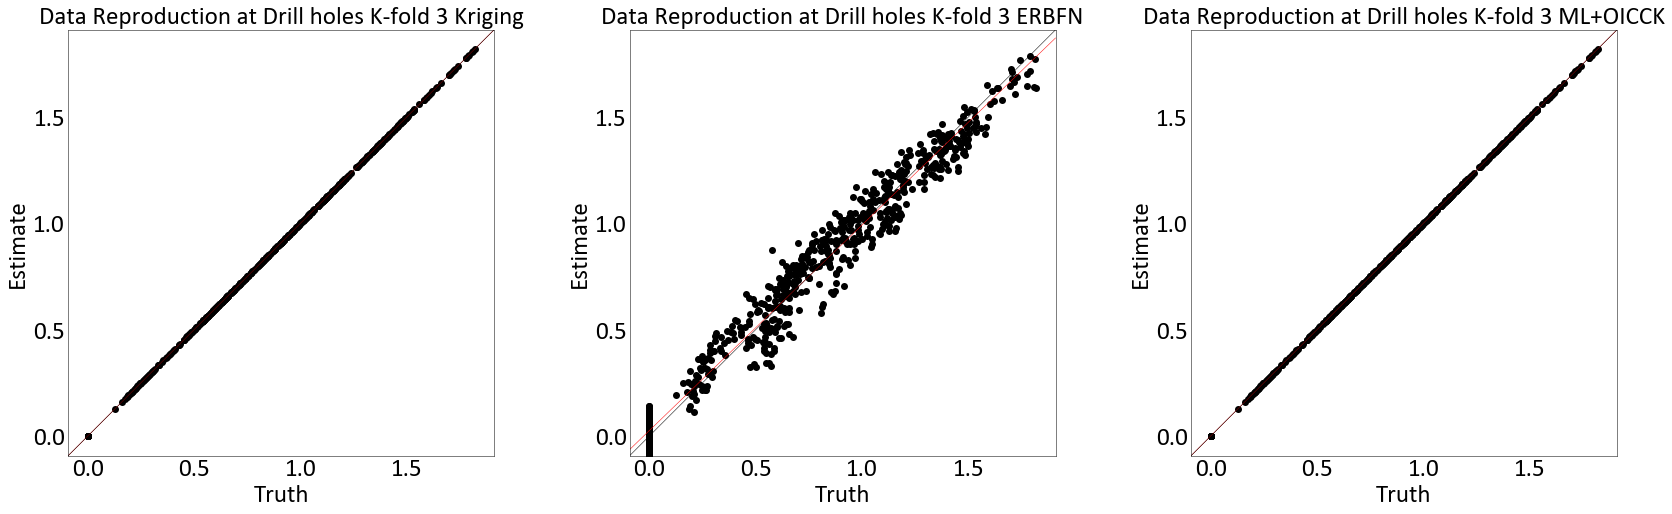

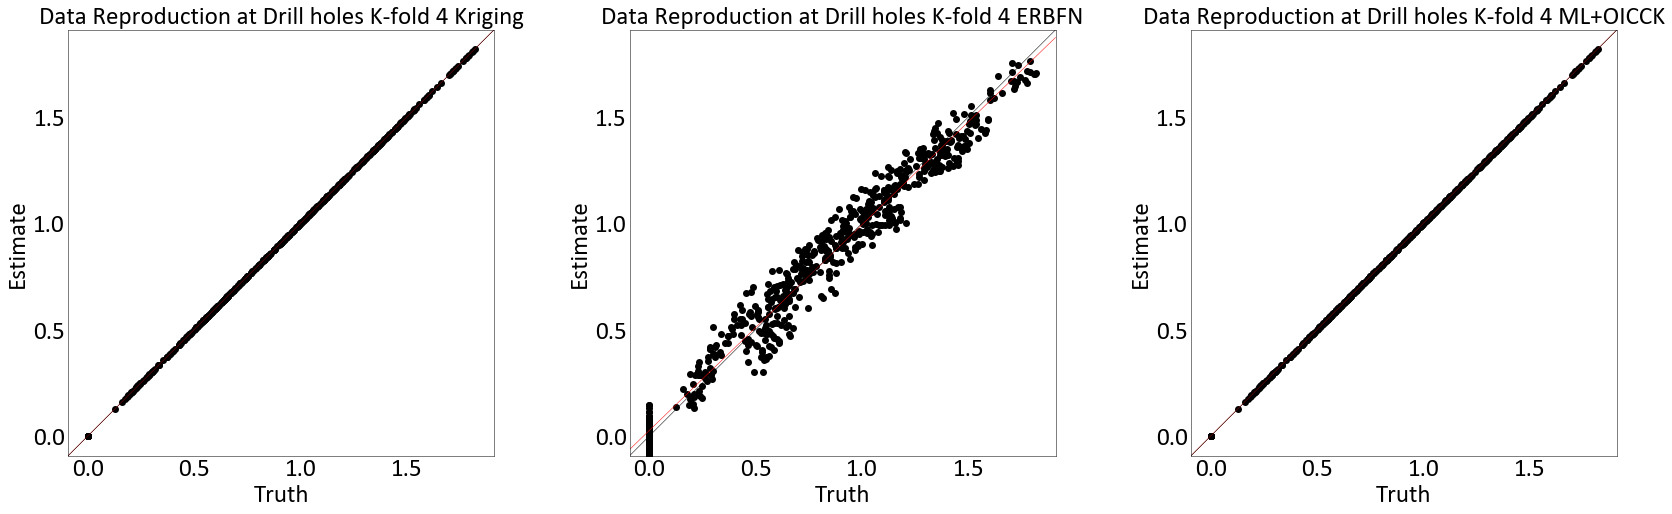

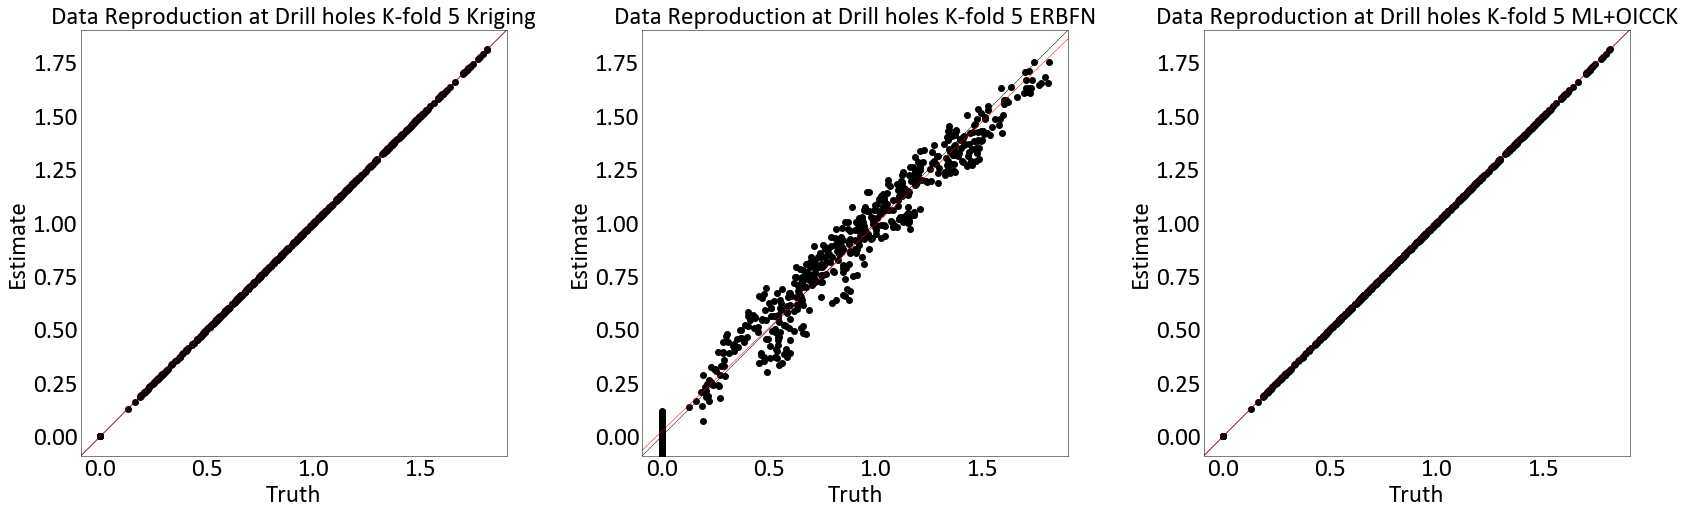

In [6]:
gs.set_style('pt25')
for fold in range (1,6):
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    Estimation_Data = gs.DataFile('./data/data_train_{}.dat'.format(fold),griddef=griddef)
    plt_data_ml = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
    plt_data_ml_icck = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
    plt_data_krig = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    idx,ingrid = griddef.coord_to_index1d(x=Estimation_Data.data['X'],y=Estimation_Data.data['Y'],z=Estimation_Data.data['Z'])
    realz_ml = plt_data_ml['0'][idx]
    realz_krig = plt_data_krig['Estimate'][idx]
    realz_ml_icck = plt_data_ml_icck['Back Transform'][idx]
    gs.scatxval(Estimation_Data.data['value'],realz_ml.values,xlabel='Truth', ylabel='Estimate',stat_blk=False,
                title = 'Data Reproduction at Drill holes K-fold {} ERBFN'.format(fold),dens=False,ax =axes[1])
    
    gs.scatxval(Estimation_Data.data['value'],realz_krig.values,xlabel='Truth', ylabel='Estimate',stat_blk=False,
                title = 'Data Reproduction at Drill holes K-fold {} Kriging'.format(fold),dens=False,ax =axes[0])
    gs.scatxval(Estimation_Data.data['value'],realz_ml_icck.values,xlabel='Truth', ylabel='Estimate',stat_blk=False,
                title = 'Data Reproduction at Drill holes K-fold {} ML+OICCK'.format(fold),dens=False,ax =axes[2])
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Drill_Hole_Reproduction_{}_{}.png'.format(plt_extent,fold),vlim=vlim)